In [3]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [4]:
info = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("/kaggle/input/g-research-crypto-forecasting/train.csv")

In [5]:
ctrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [4]:
info

Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin

In [5]:
# Labels for each cryptocurrency
crypto_labels = dict(zip(info["Asset_ID"], info["Asset_Name"]))

# Impute Missing Time Value
def c_time_sub(asset_id, data = ctrain):
    df = data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df = df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

for i in range(14):
    c = c_time_sub(asset_id = i)
    print("---------------------------")
    print(crypto_labels[i])
    print((c.index[1:] - c.index[:-1]).value_counts().head())
print("---------------------------")

---------------------------
Binance Coin
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Bitcoin
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Bitcoin Cash
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Cardano
timestamp
60    1803769
Name: count, dtype: int64
---------------------------
Dogecoin
timestamp
60    1285046
Name: count, dtype: int64
---------------------------
EOS.IO
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Ethereum
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Ethereum Classic
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
IOTA
timestamp
60    1772153
Name: count, dtype: int64
---------------------------
Litecoin
timestamp
60    1956959
Name: count, dtype: int64
---------------------------
Maker
timestamp
60    1770279
Name: count, dtype: int64
---------------------------
Monero
tim

In [6]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [7]:
%matplotlib inline
info_s=info.sort_values("Weight")
fig_index=px.bar(info_s,x="Asset_Name" , y="Weight", color="Weight", title="Popular Cryptocurrency Weight Distribution")
fig_index.update_layout(
    plot_bgcolor="black",
    paper_bgcolor="black",
    font_color="white"
)
fig_index.show(renderer="iframe")

In [8]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

all2021=pd.DataFrame([])
for asset_id, asset_name in zip(info.Asset_ID, info.Asset_Name):
    asset=ctrain[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    asset=asset.loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]
    asset=asset.reindex(range(asset.index[0],asset.index[-1]+60,60), method="pad")
    lret=log_return(asset.Close.fillna(0))[1:]
    all2021=all2021.join(lret,rsuffix=asset_name,how="outer")

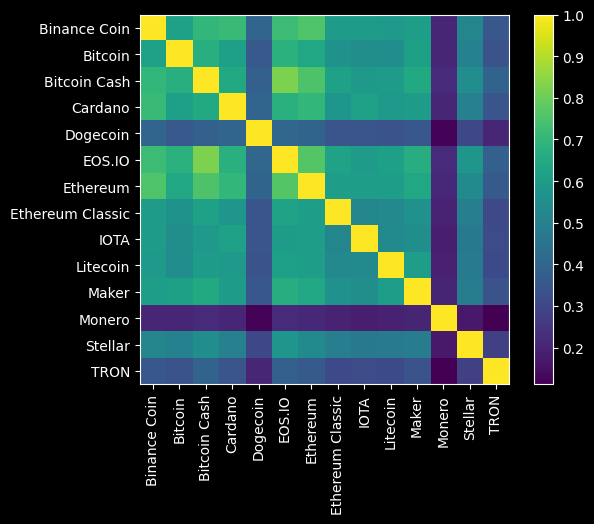

In [9]:
plt.style.use("dark_background")
plt.imshow(all2021.corr(), cmap="viridis");
plt.yticks(info.Asset_ID, info.Asset_Name.values)
plt.xticks(info.Asset_ID, info.Asset_Name.values,rotation="vertical");
plt.colorbar()

In [10]:
import pandas as pd

# Function to convert a date string to timestamp
def totimestamp(date_string):
    return pd.to_datetime(date_string).timestamp()

# Function to get data for specific time interval
def dur(start, end, data):
    df = data.loc[totimestamp(start): totimestamp(end)]
    return df

assets = info["Asset_ID"].values
crypto_data = {}
crypto_data_2021 = {}

# Iterate over each Asset_ID to process and store data
for asset_id in assets:
    imputed_data = c_time_sub(asset_id=asset_id, data=ctrain)
    crypto_data[asset_id] = imputed_data
    filtered_data = dur(start="01/01/2021", end="21/09/2021", data=imputed_data)
    crypto_data_2021[asset_id] = filtered_data


In [11]:
# Colors for each cryptocurrency
crypto_colors = {
    2: "#fede86",   # Bitcoin Cash
    0: "#f1a50d",   # Binance Coin
    1: "#fede86",   # Bitcoin
    5: "#9f65c8",   # EOS.IO
    7: "#8c8c8c",   # Ethereum Classic
    6: "#28a745",   # Ethereum
    9: "#27ae60",   # Litecoin
    11: "#e74c3c",  # Monero
    13: "#ff6f61",  # TRON
    12: "#f39c12",  # Stellar
    3: "#3498db",   # Cardano
    8: "#d35400",   # IOTA
    10: "#9b59b6",  # Maker
    4: "#e67e22",   # Dogecoin
}

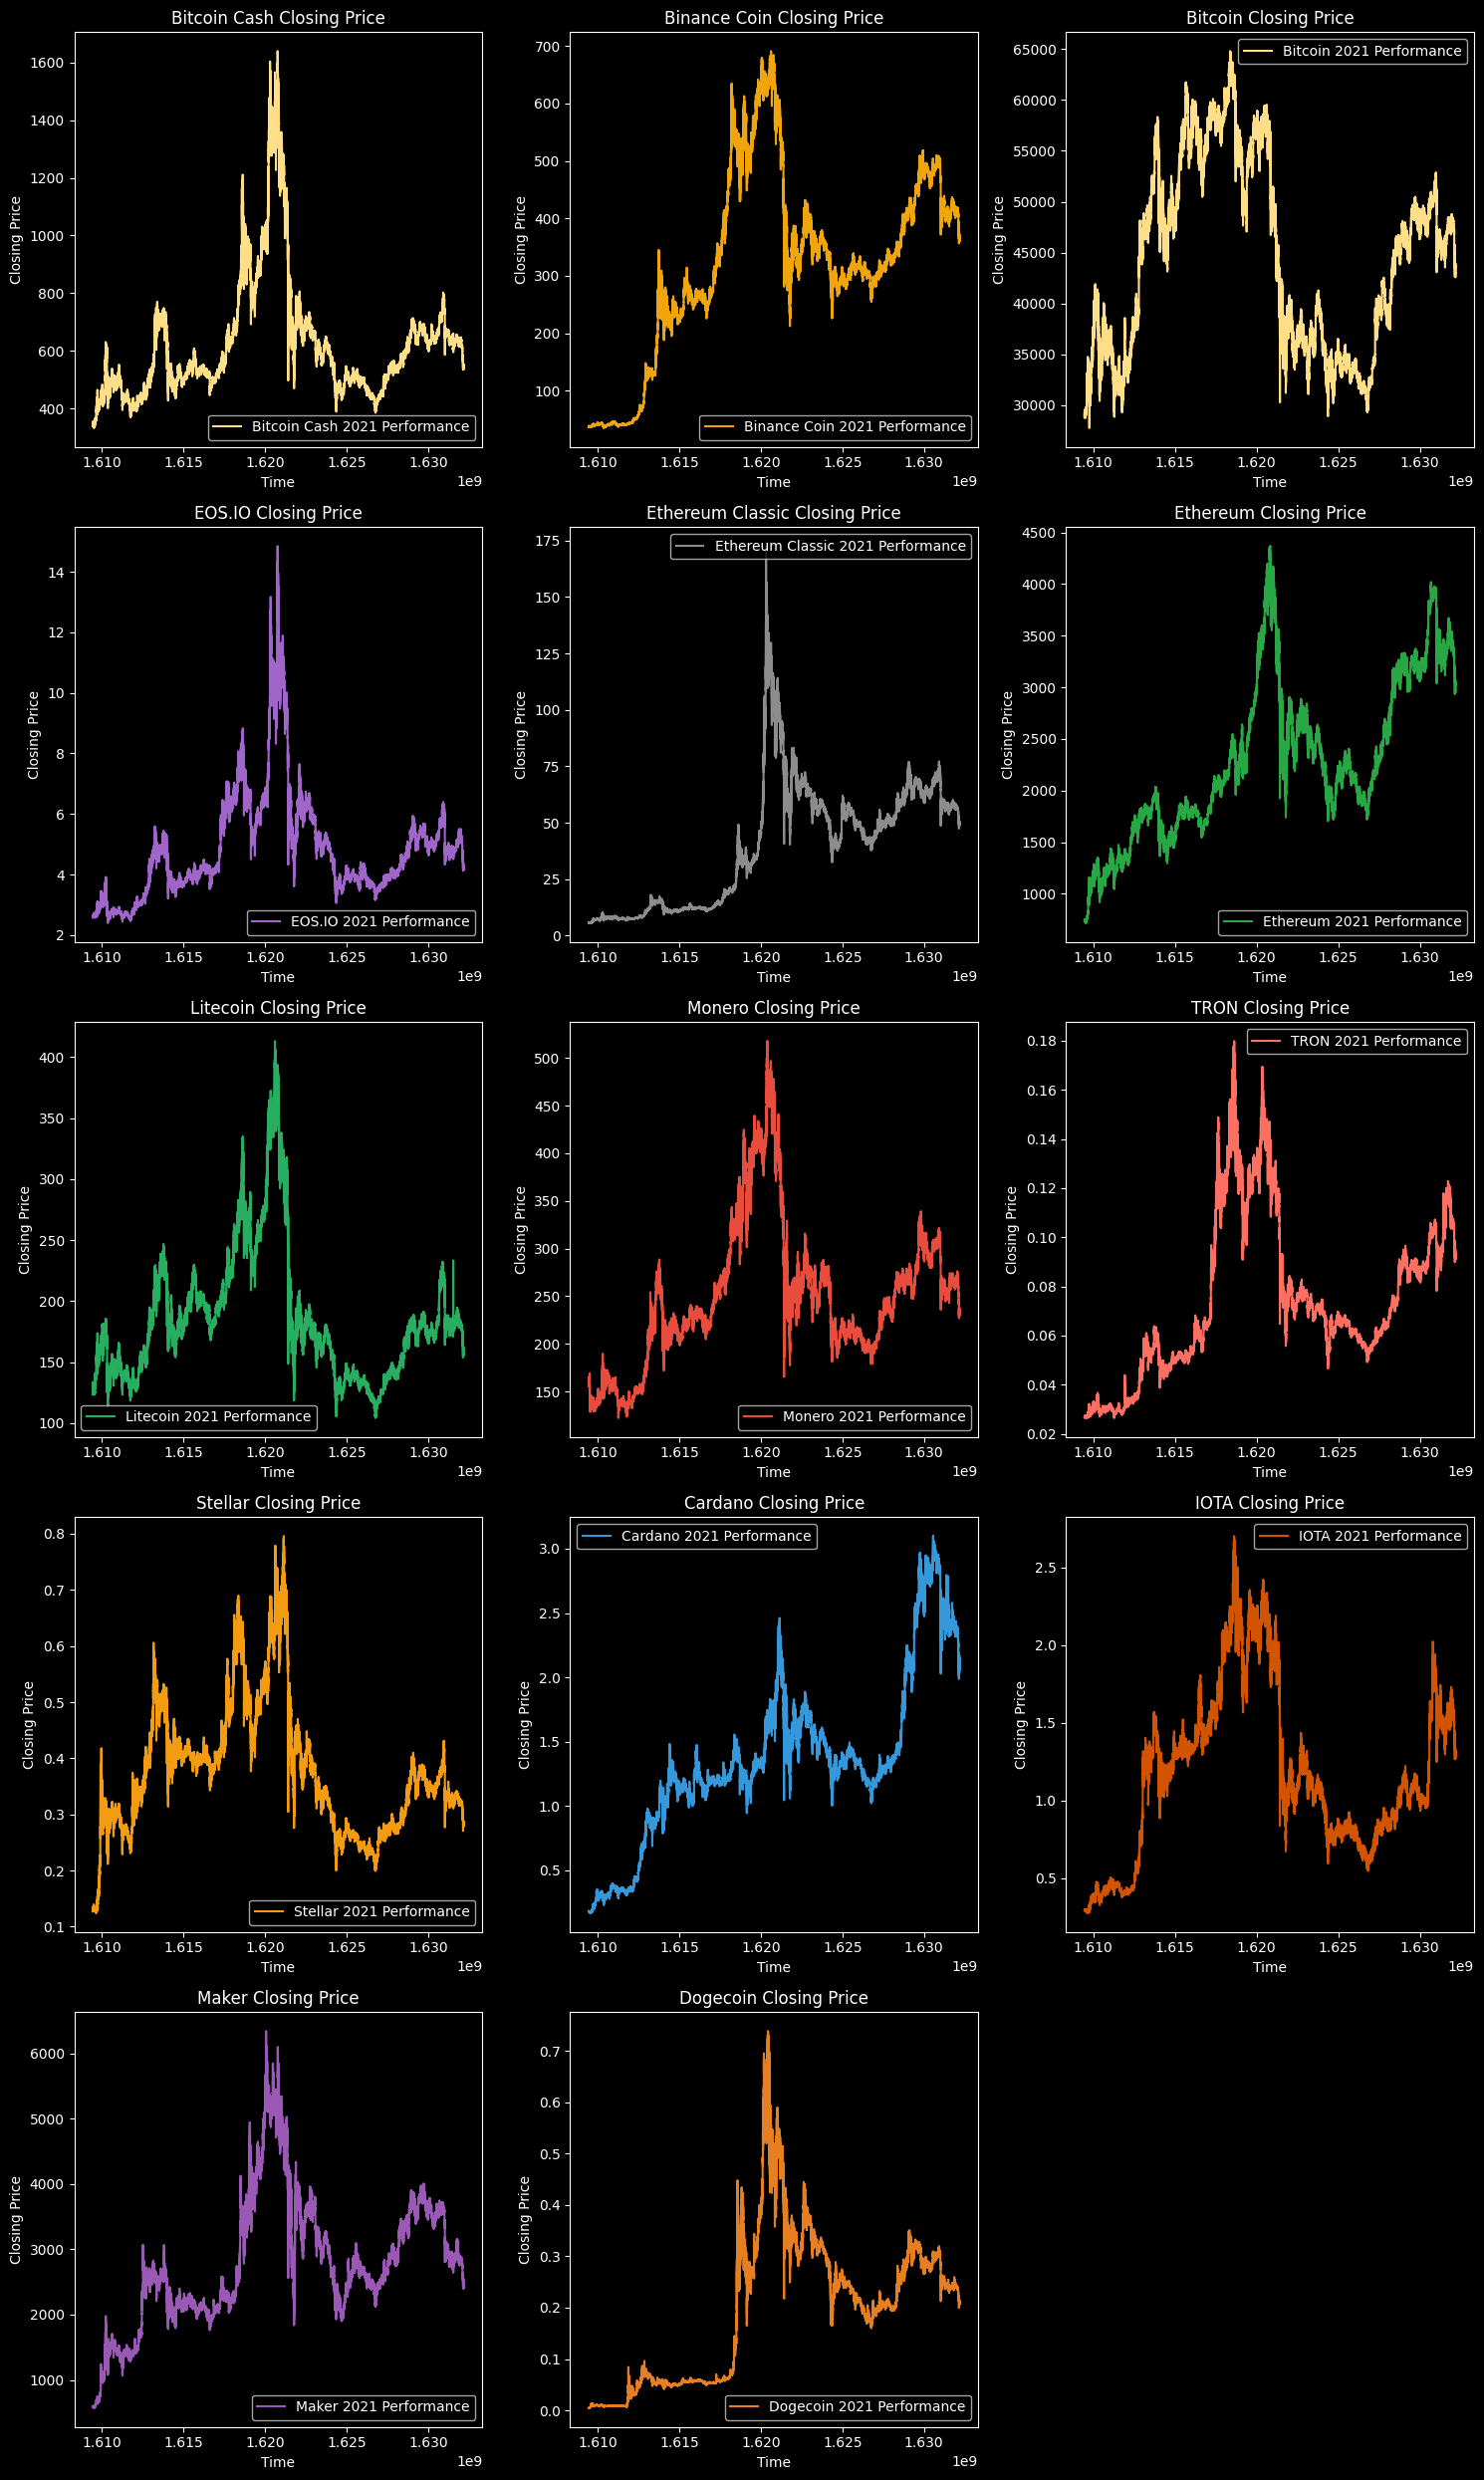

In [12]:
# Create subplots
num_cryptos = 14
rows = (num_cryptos + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each cryptocurrency
for idx, (asset_id, data) in enumerate(crypto_data_2021.items()):
    asset_name = crypto_labels[asset_id]
    axes[idx].plot(
        data["Close"], label=f"{asset_name} 2021 Performance", color=crypto_colors[asset_id]
    )
    axes[idx].set_title(f"{asset_name} Closing Price")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel("Closing Price")
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[num_cryptos:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# # Data Selection
# def crypto_sub(asset_id ,data= ctrain ):
#     df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
#     df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
#     df = df.set_index('timestamp')
#     return df

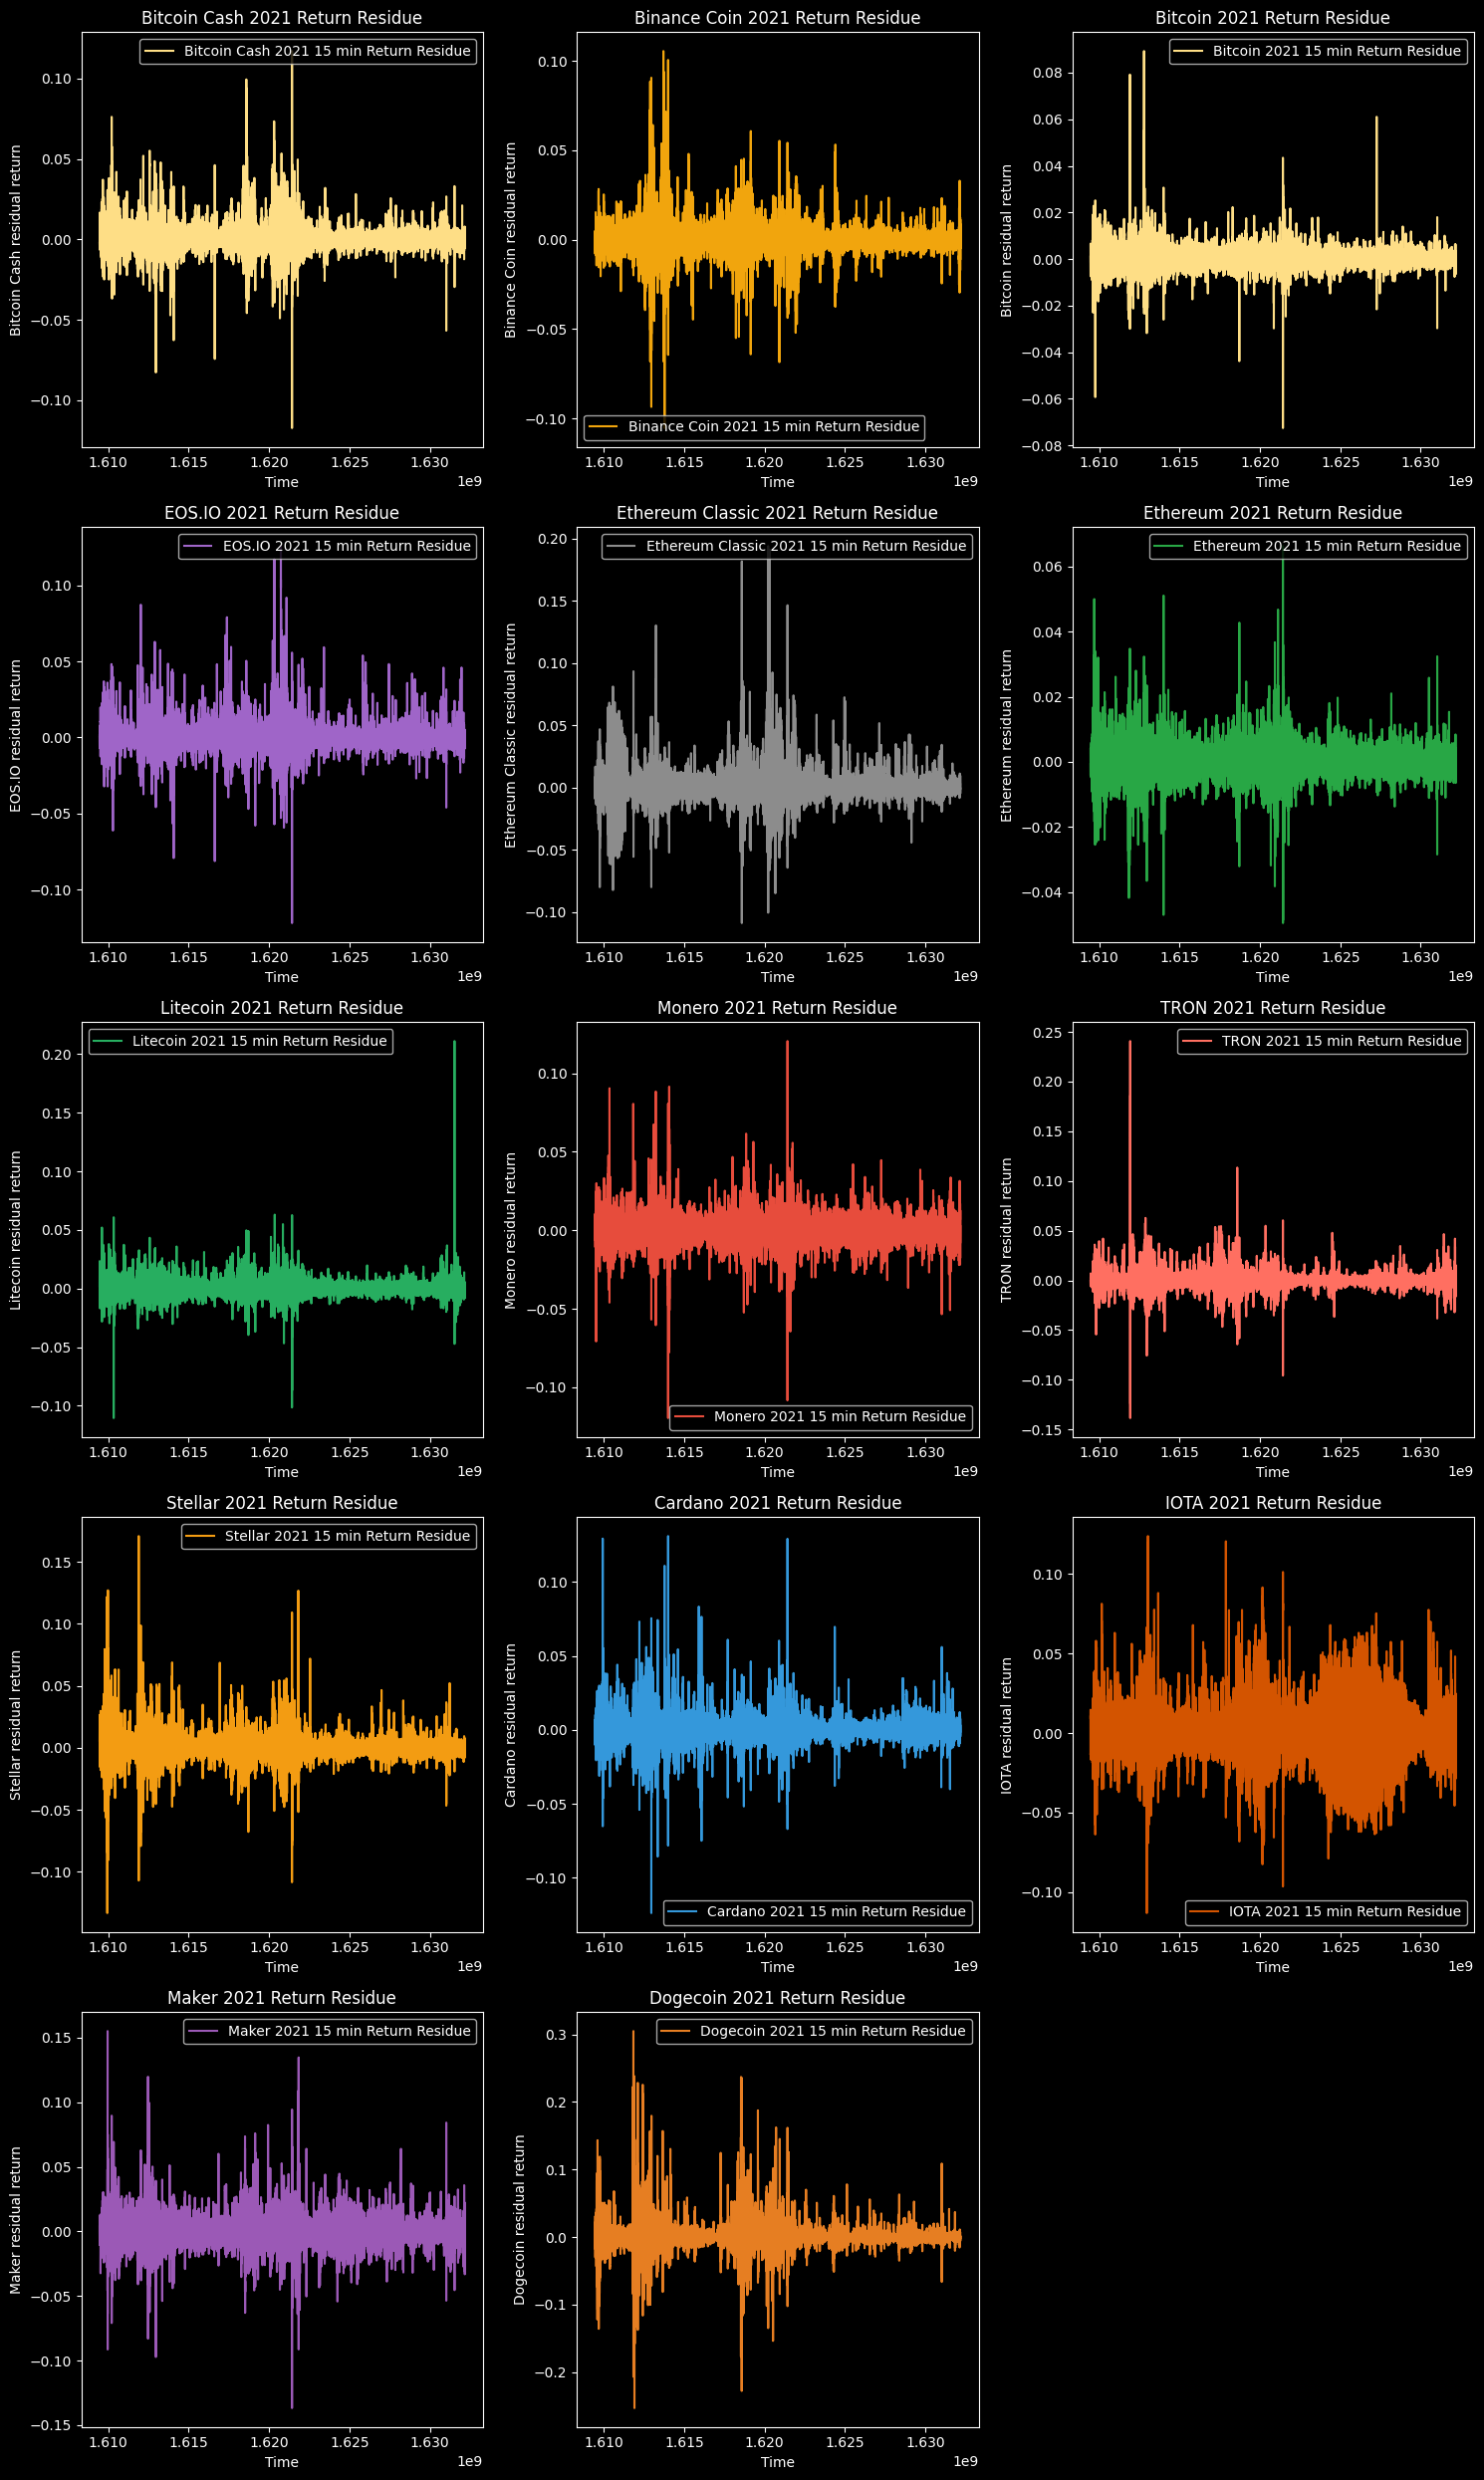

In [14]:
# Create subplots
num_cryptos = 14
rows = (num_cryptos + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each cryptocurrency
for idx, (asset_id, data) in enumerate(crypto_data_2021.items()):
    asset_name = crypto_labels[asset_id]
    axes[idx].plot(
        data["Target"], label=f"{asset_name} 2021 15 min Return Residue", 
        color=crypto_colors[asset_id]
    )
    axes[idx].set_title(f"{asset_name} 2021 Return Residue")
    axes[idx].set_xlabel("Time")
    axes[idx].set_ylabel(f"{asset_name} residual return")
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[num_cryptos:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
# Function to Subset the Price variables
def mini_data(data):
    return data[["Close", "Low", "High", "Open"]]

# Subset data for all cryptocurrencies
crypto_data_mini = {
    asset_id: mini_data(data) for asset_id, data in crypto_data.items()
}

for i in range(num_cryptos):
    print(crypto_labels[i])
    print(crypto_data_mini[i].head())
    print("")

Binance Coin
             Close     Low    High    Open
timestamp                                 
1514764860  8.5300  8.5300  8.5300  8.5300
1514764920  8.5145  8.5145  8.5300  8.5300
1514764980  8.4848  8.4848  8.5299  8.5065
1514765040  8.5009  8.4744  8.5066  8.5009
1514765100  8.4560  8.4560  8.5007  8.5007

Bitcoin
                Close       Low     High       Open
timestamp                                          
1514764860  13850.176  13666.11  14013.8  13835.194
1514764920  13828.102  13680.00  14052.3  13835.036
1514764980  13801.314  13601.00  14000.4  13823.900
1514765040  13768.040  13576.28  13999.0  13802.512
1514765100  13724.914  13554.44  13955.9  13766.000

Bitcoin Cash
                  Close      Low    High         Open
timestamp                                            
1514764860  2374.590000  2357.14  2399.5  2376.580000
1514764920  2372.286667  2354.20  2400.9  2374.553333
1514764980  2372.063333  2353.70  2401.9  2371.633333
1514765040  2370.566667  2344

Binance Coin Seasonal Decomposition


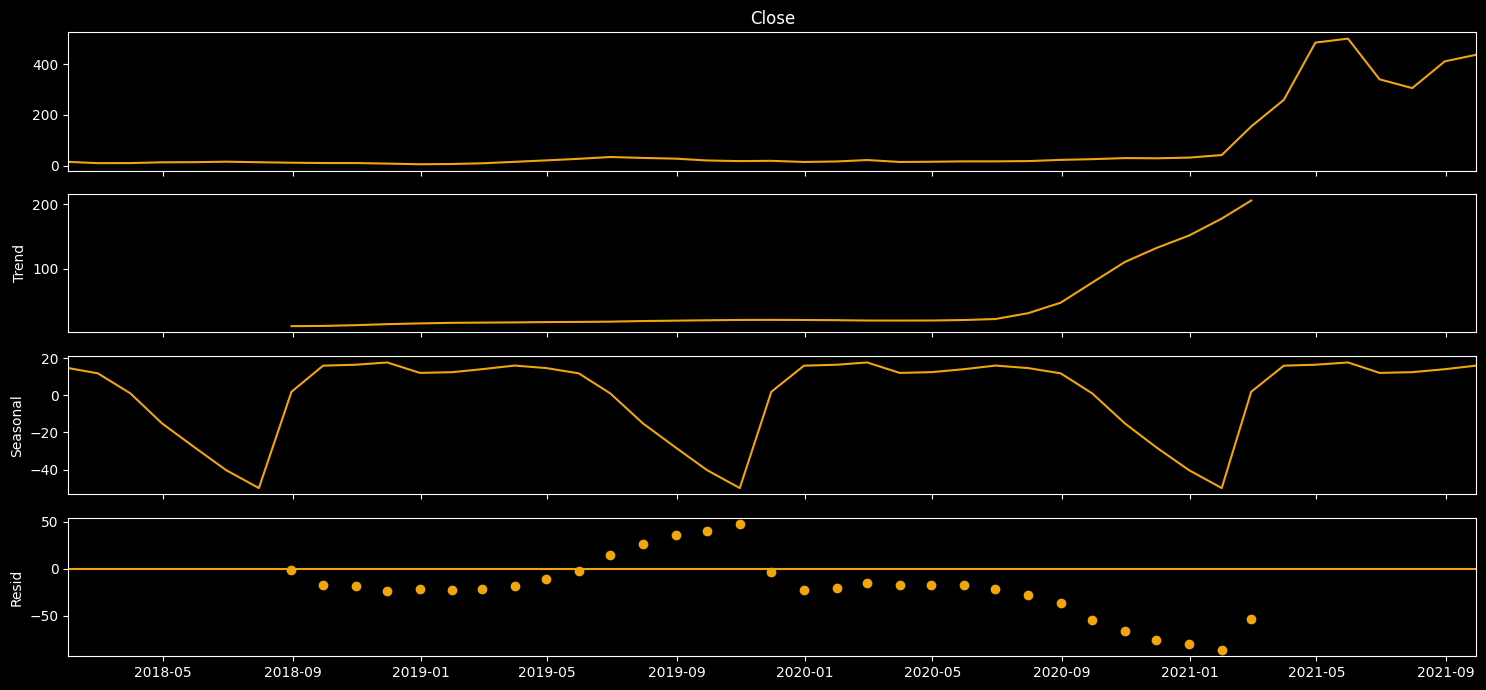

Bitcoin Seasonal Decomposition


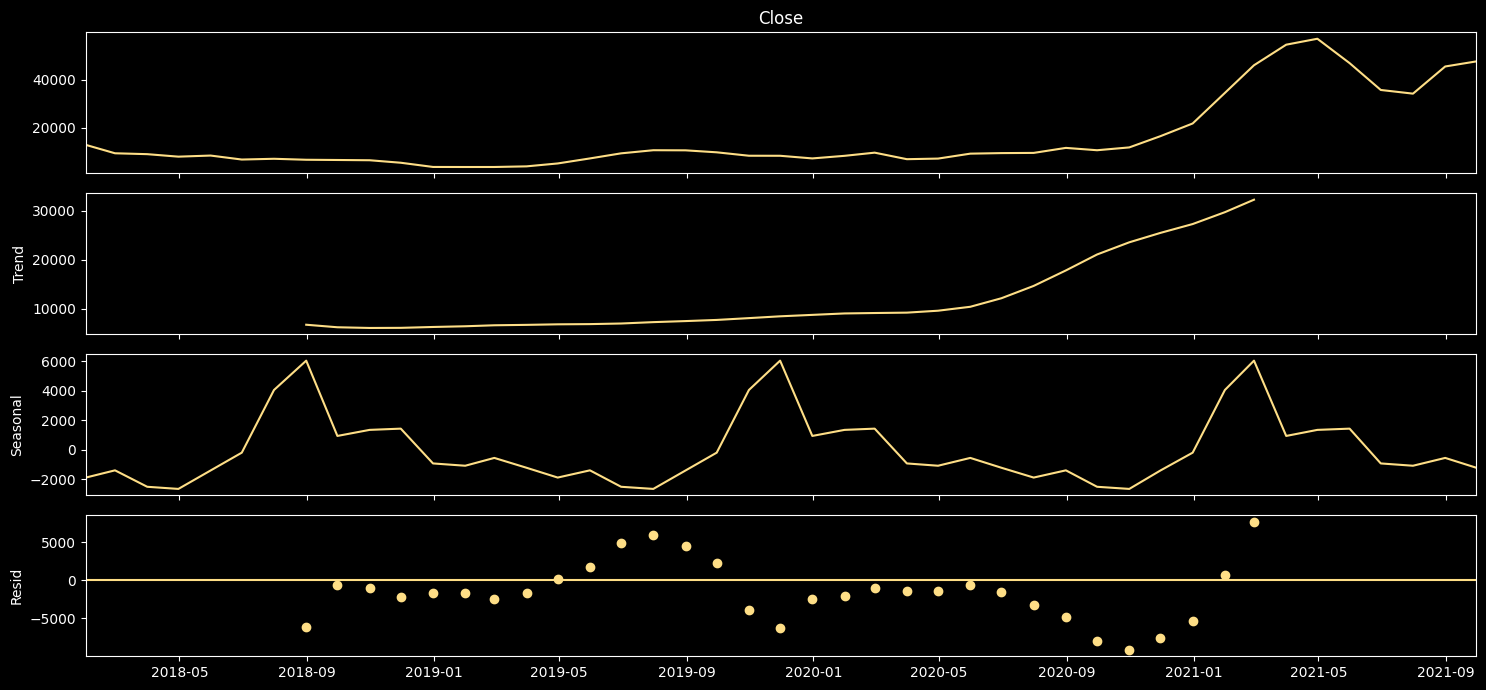

Bitcoin Cash Seasonal Decomposition


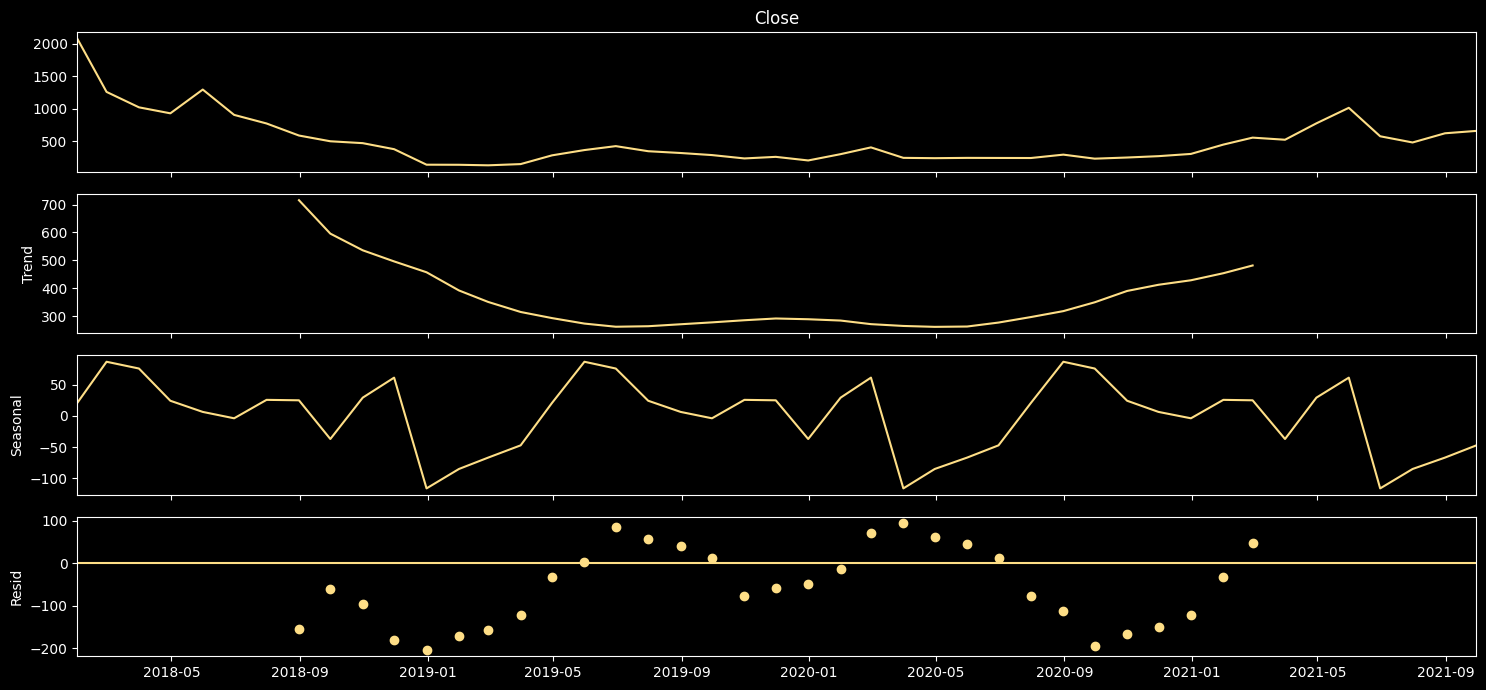

Cardano Seasonal Decomposition


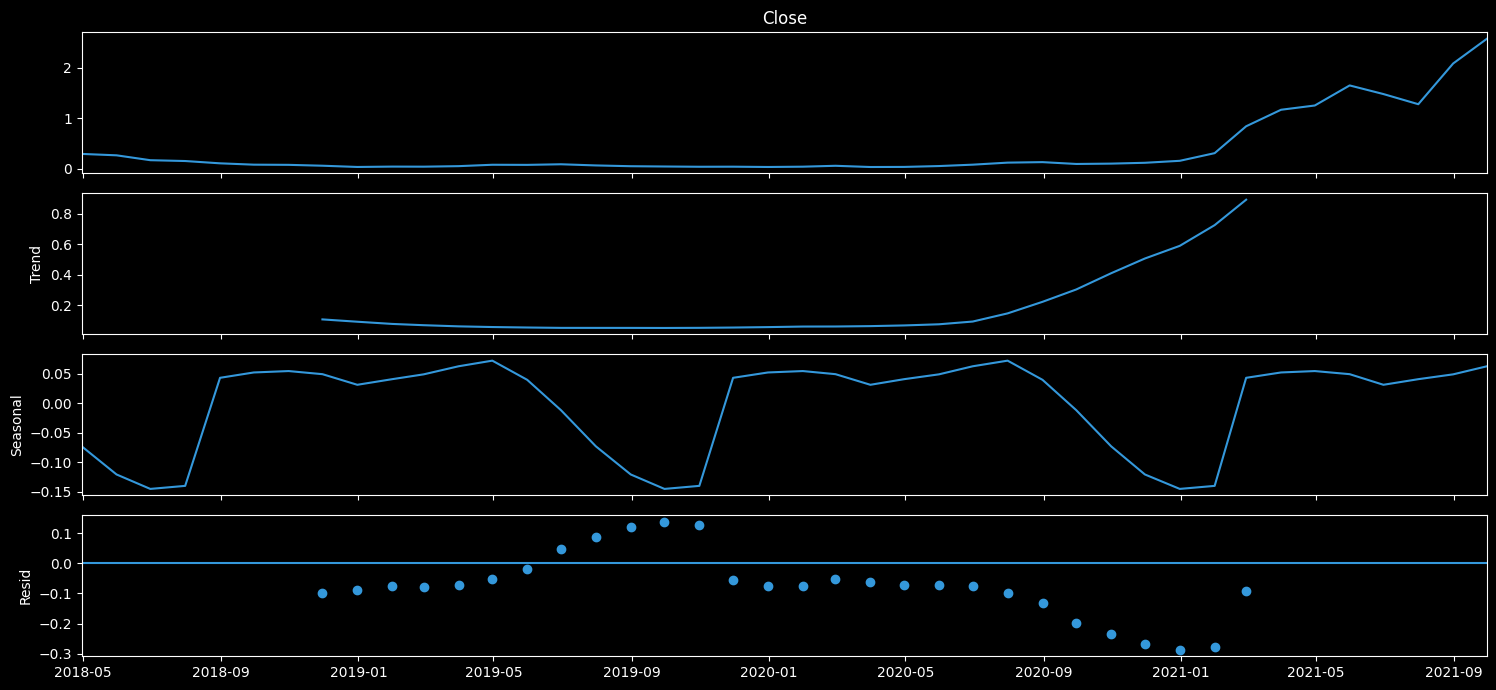

Dogecoin Seasonal Decomposition


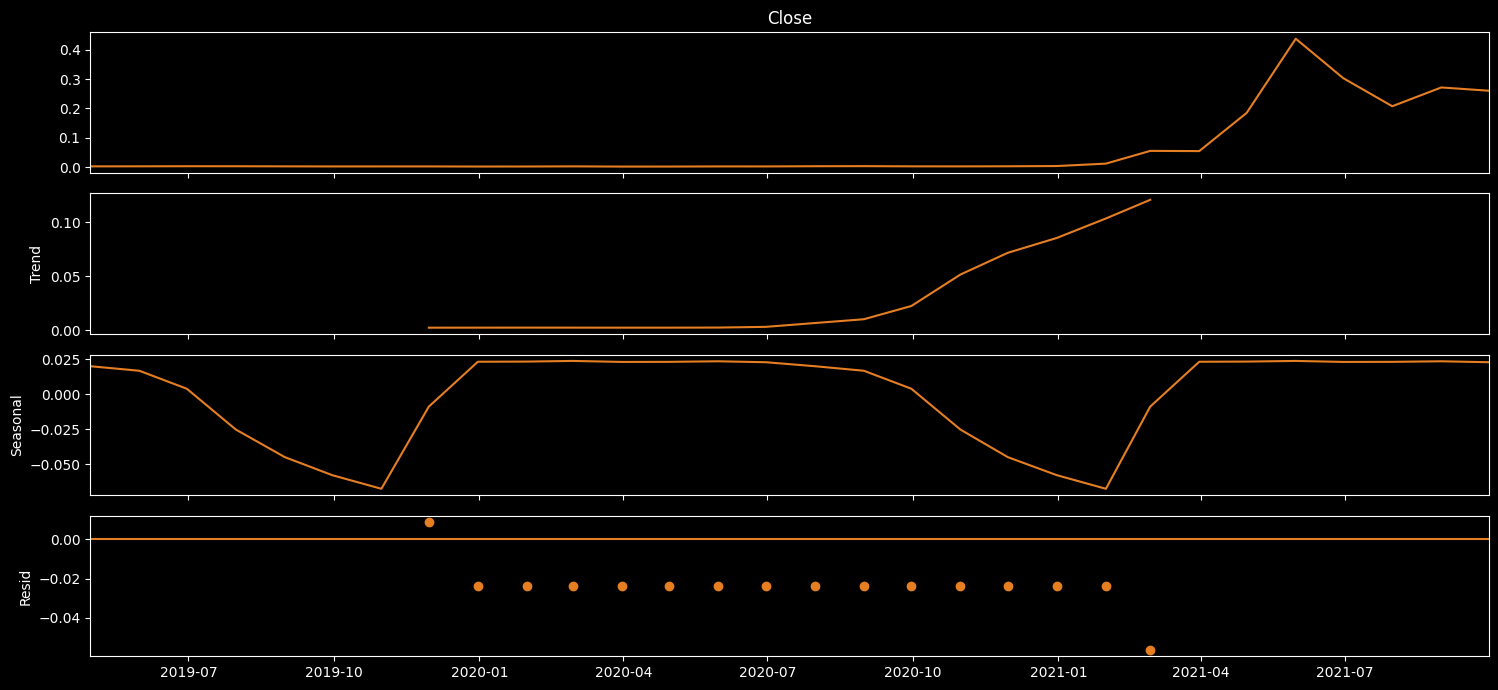

EOS.IO Seasonal Decomposition


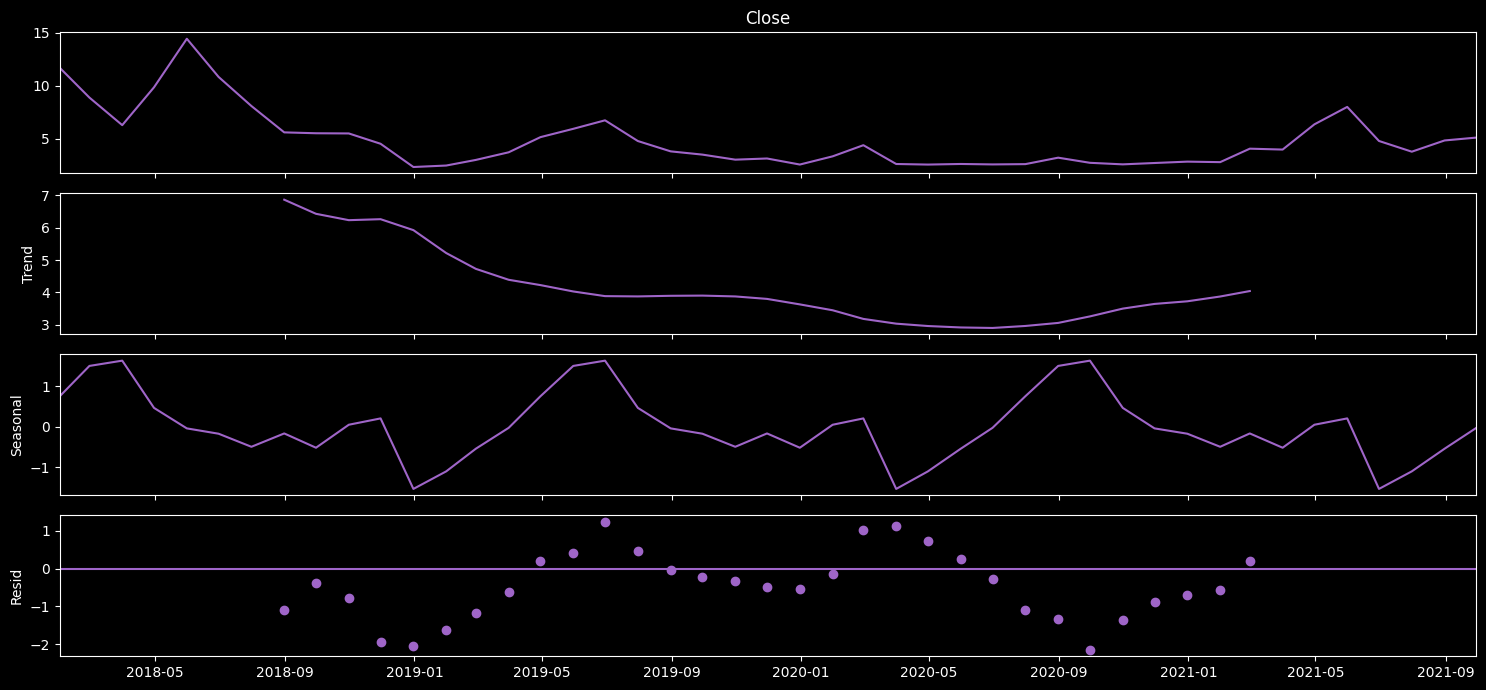

Ethereum Seasonal Decomposition


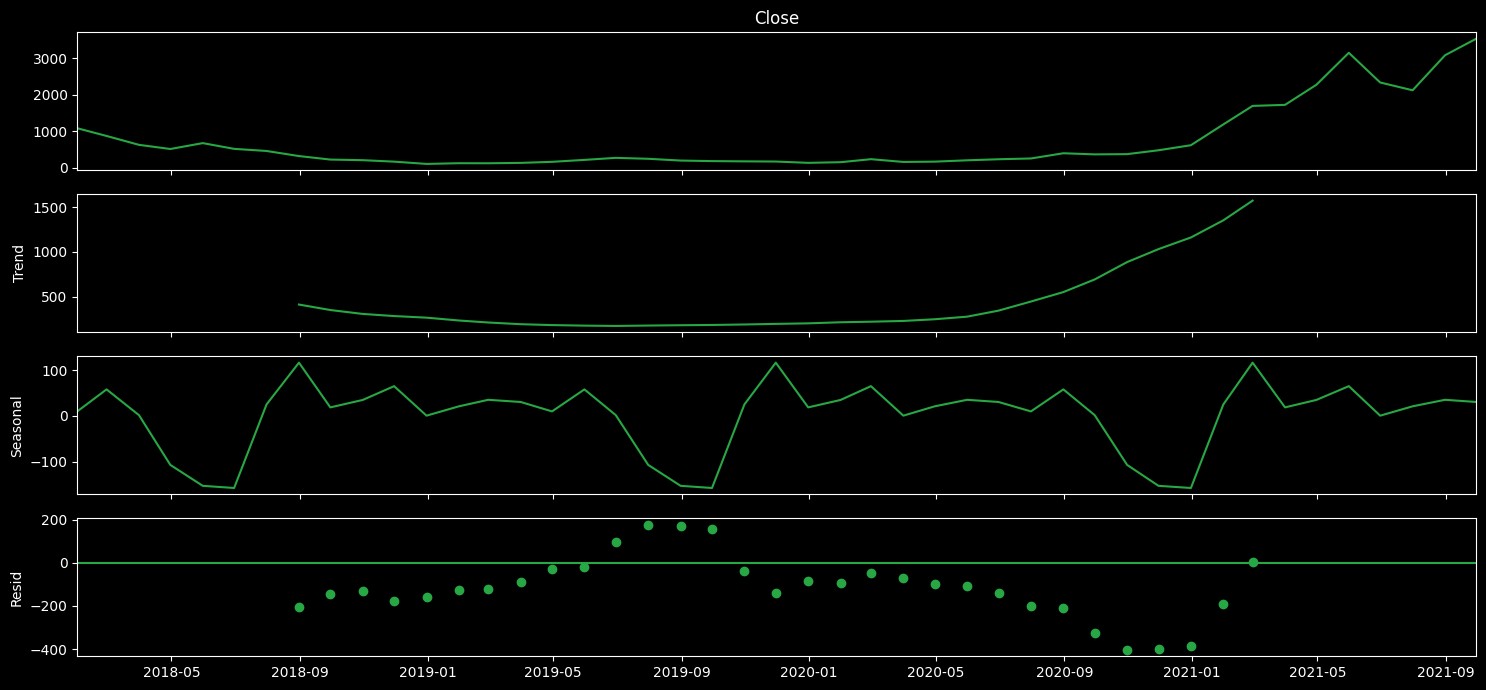

Ethereum Classic Seasonal Decomposition


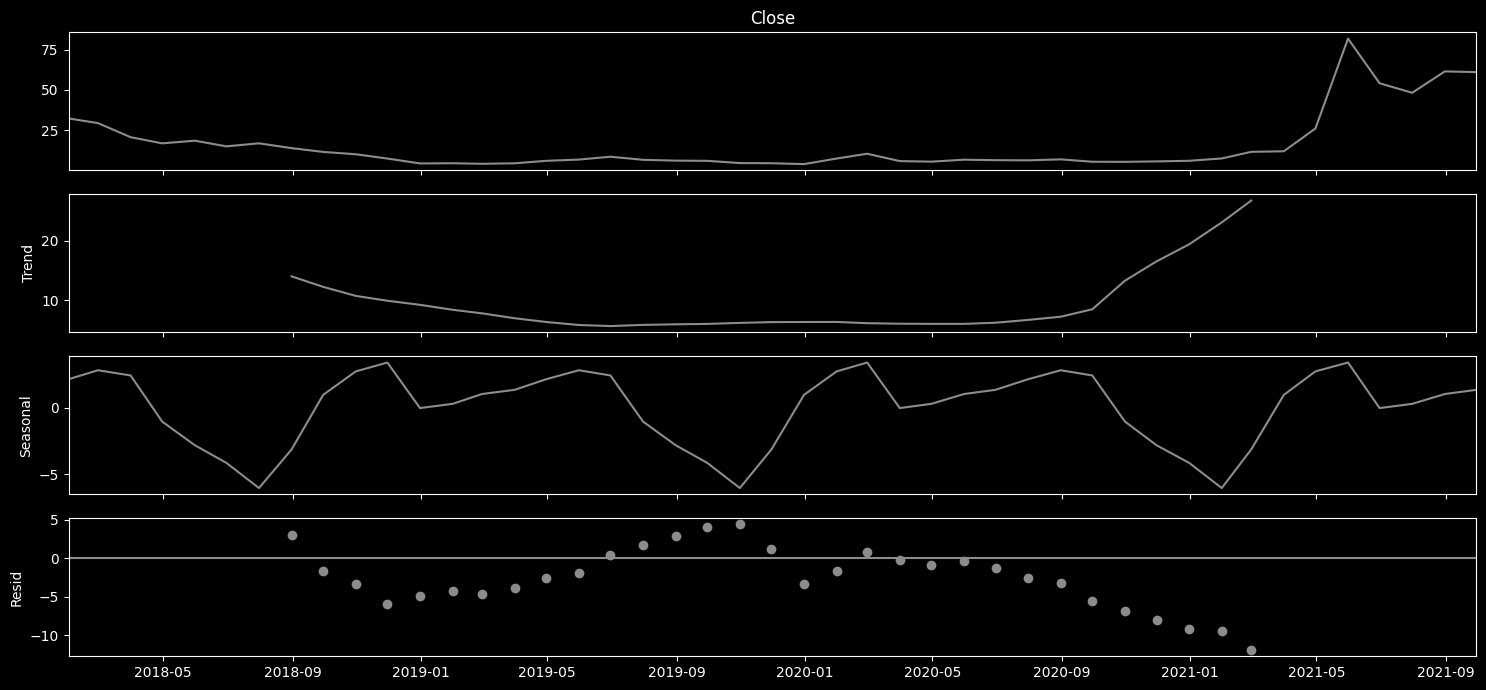

IOTA Seasonal Decomposition


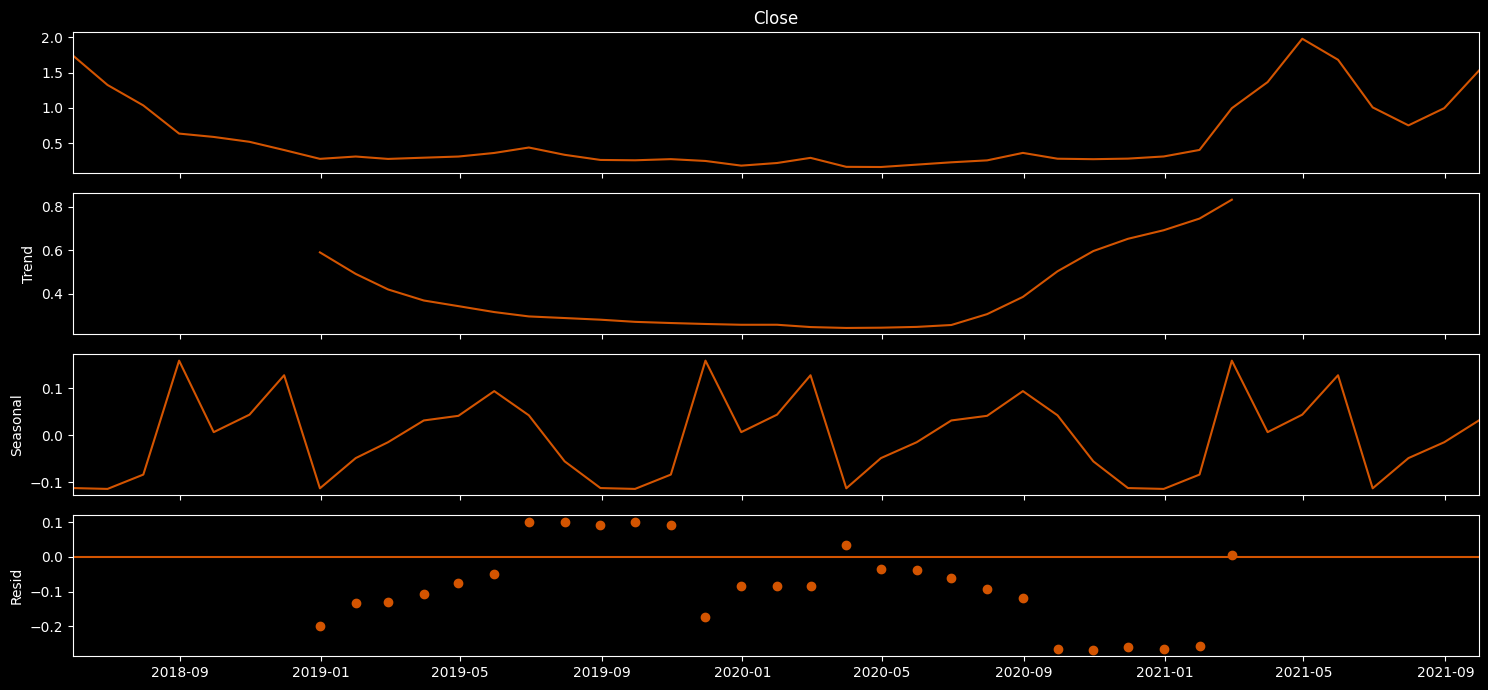

Litecoin Seasonal Decomposition


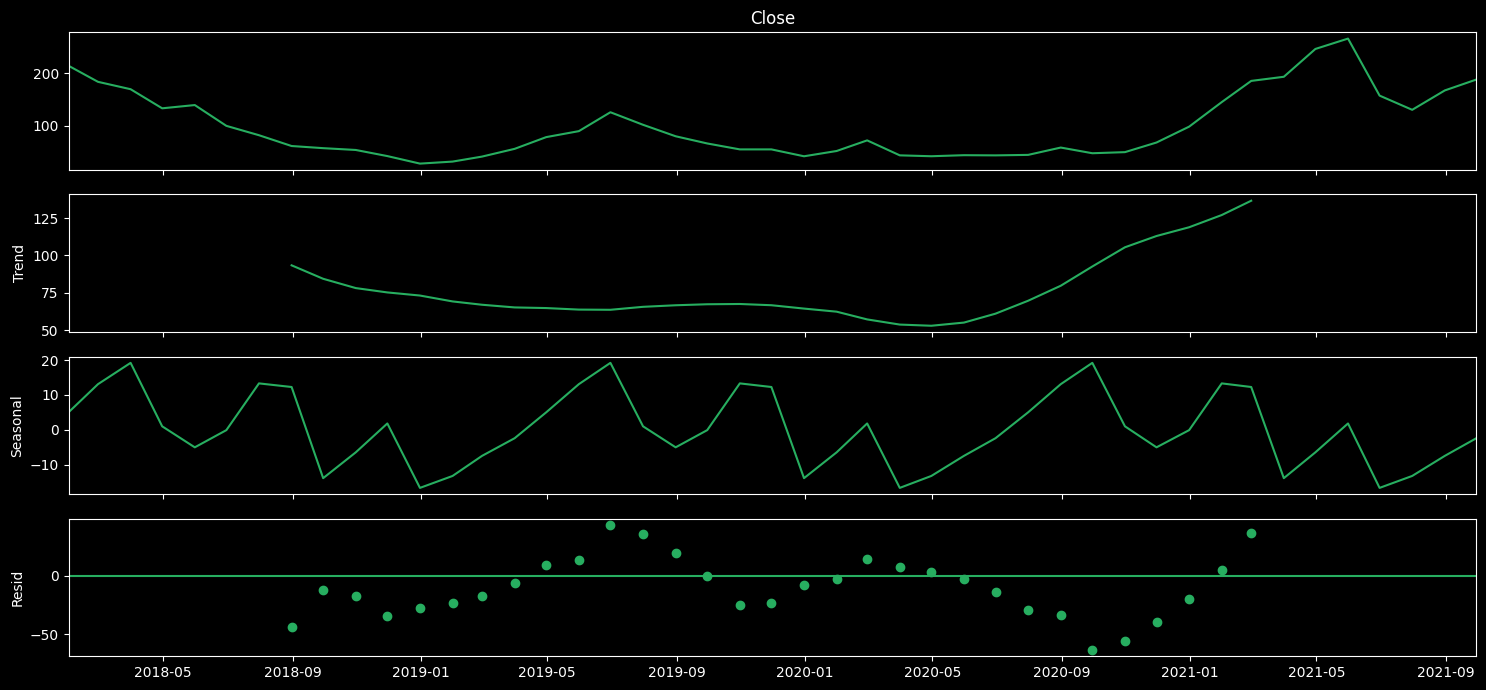

Maker Seasonal Decomposition


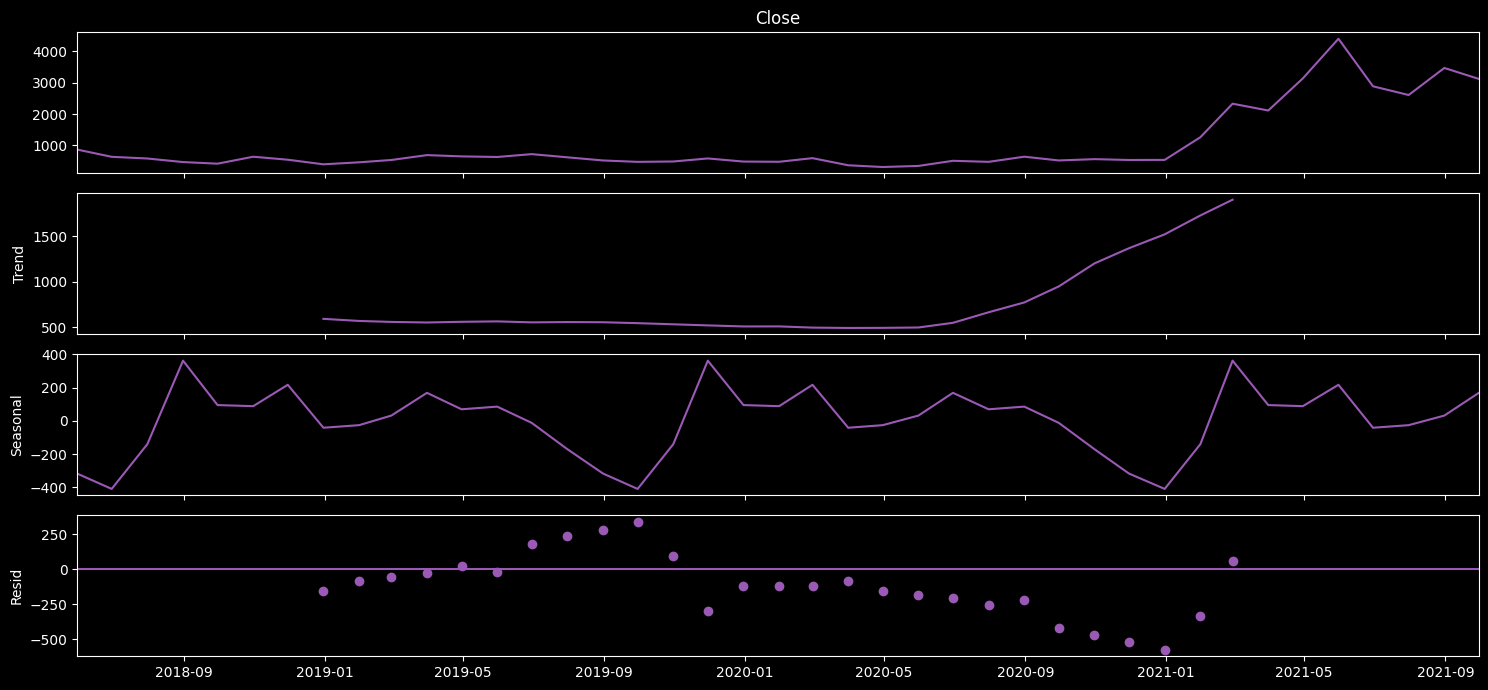

Monero Seasonal Decomposition


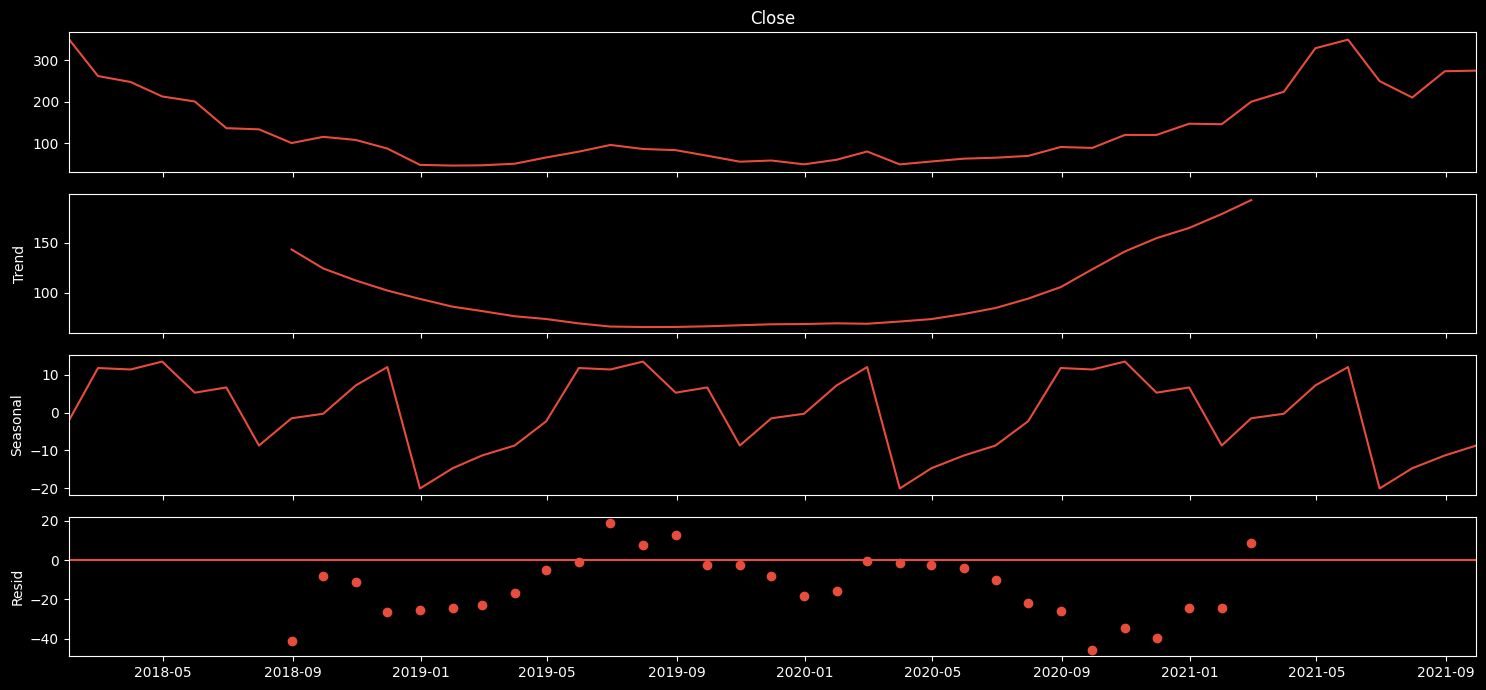

Stellar Seasonal Decomposition


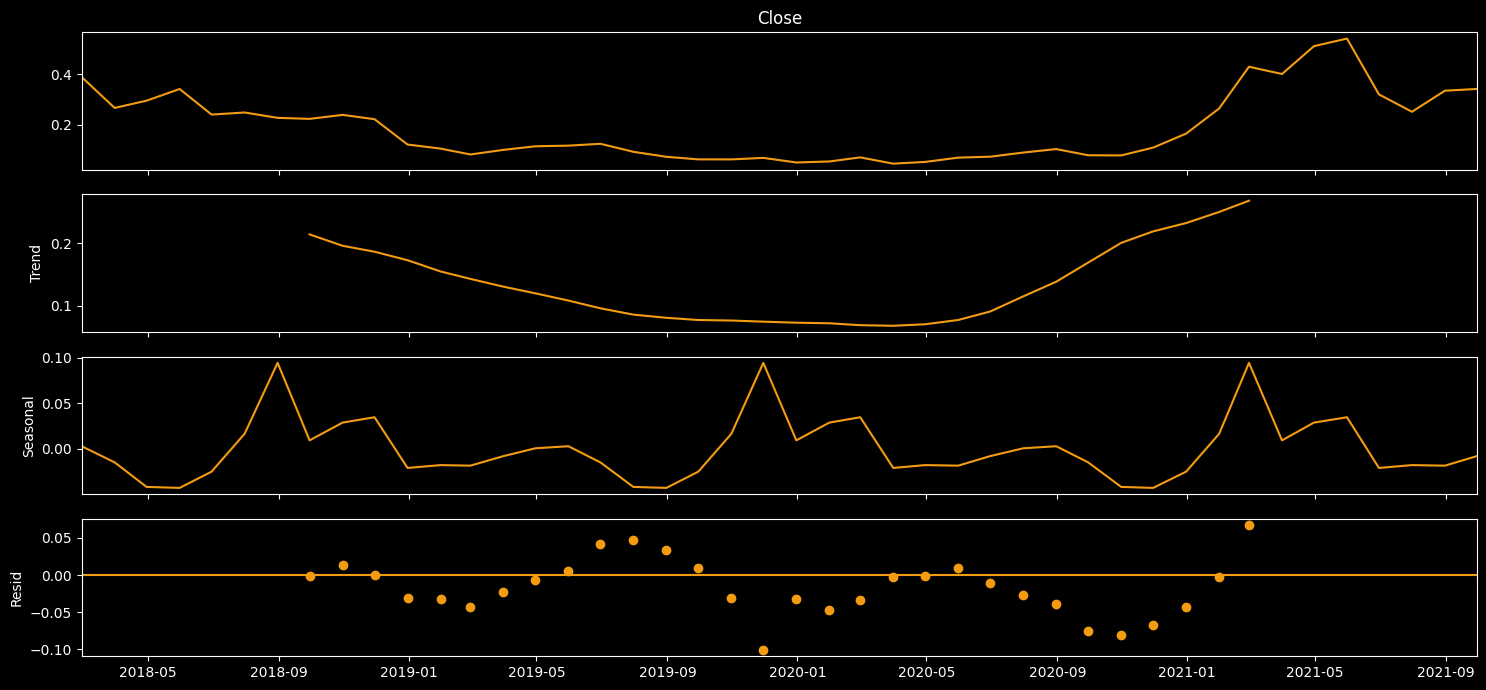

TRON Seasonal Decomposition


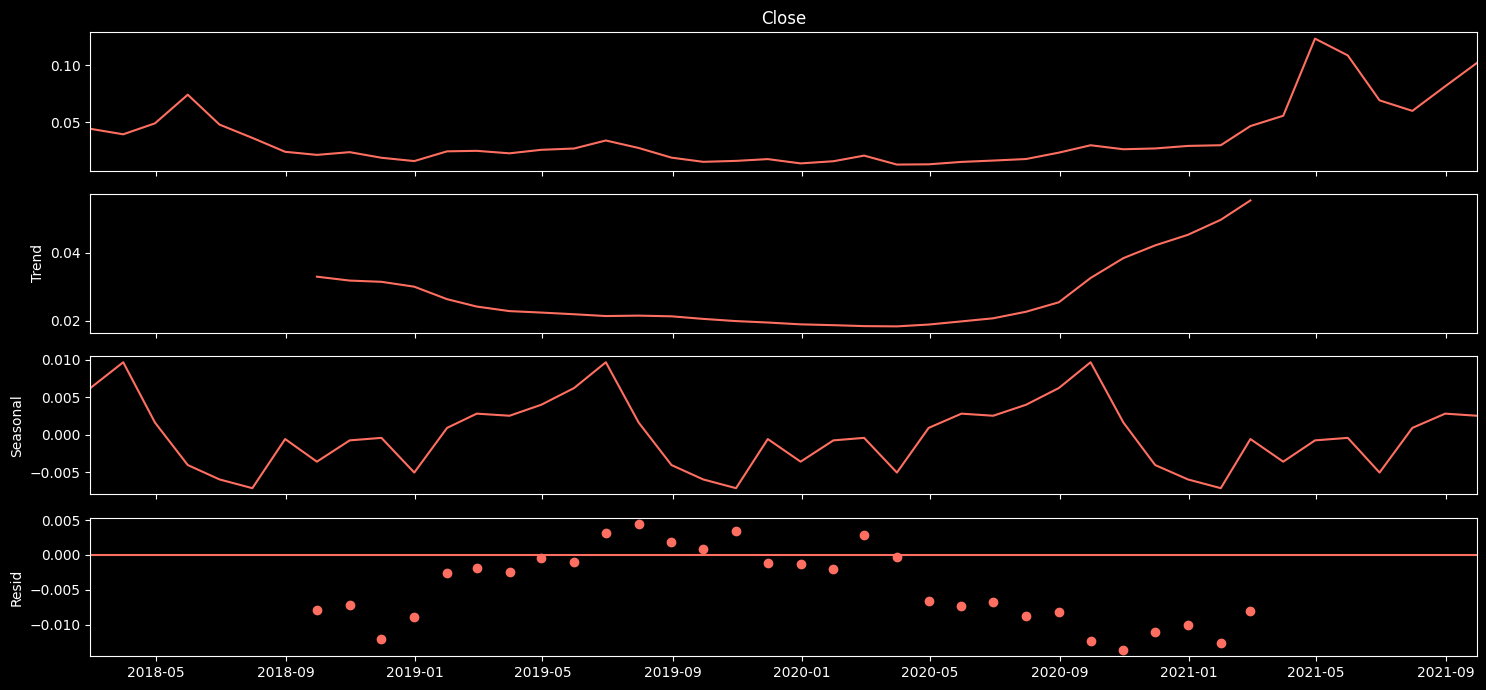

In [27]:
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label, color):
    # Ensure the index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data = data.set_index(pd.to_datetime(data.index, unit="s"))  # Convert index to datetime

    # Resample and calculate the mean (e.g., weekly frequency)
    df = data.resample("M").mean()
    
    # Seasonal decomposition
    fig = seasonal_decompose(df["Close"], model="additive", period=15).plot()  # 52 weeks in a year

    for ax in fig.get_axes():
        for line in ax.lines:
            line.set_color(color)
    
    print(label)
    return plt.show()

for i in range(14):
    season_df(data=crypto_data_mini[i], label=f"{crypto_labels[i]} Seasonal Decomposition", color=crypto_colors[i])


Results for Bitcoin Cash:
  parameters         aic
0     (0, 0) -115.315711
1     (0, 1) -114.467532
3     (1, 0) -114.348611
4     (1, 1) -113.011202
2     (0, 2) -112.660127
Best model for Bitcoin Cash:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  58.658
Date:                Thu, 21 Nov 2024   AIC                           -115.316
Time:                        11:56:52   BIC                           -113.532
Sample:                    01-31-2018   HQIC                          -114.654
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigm

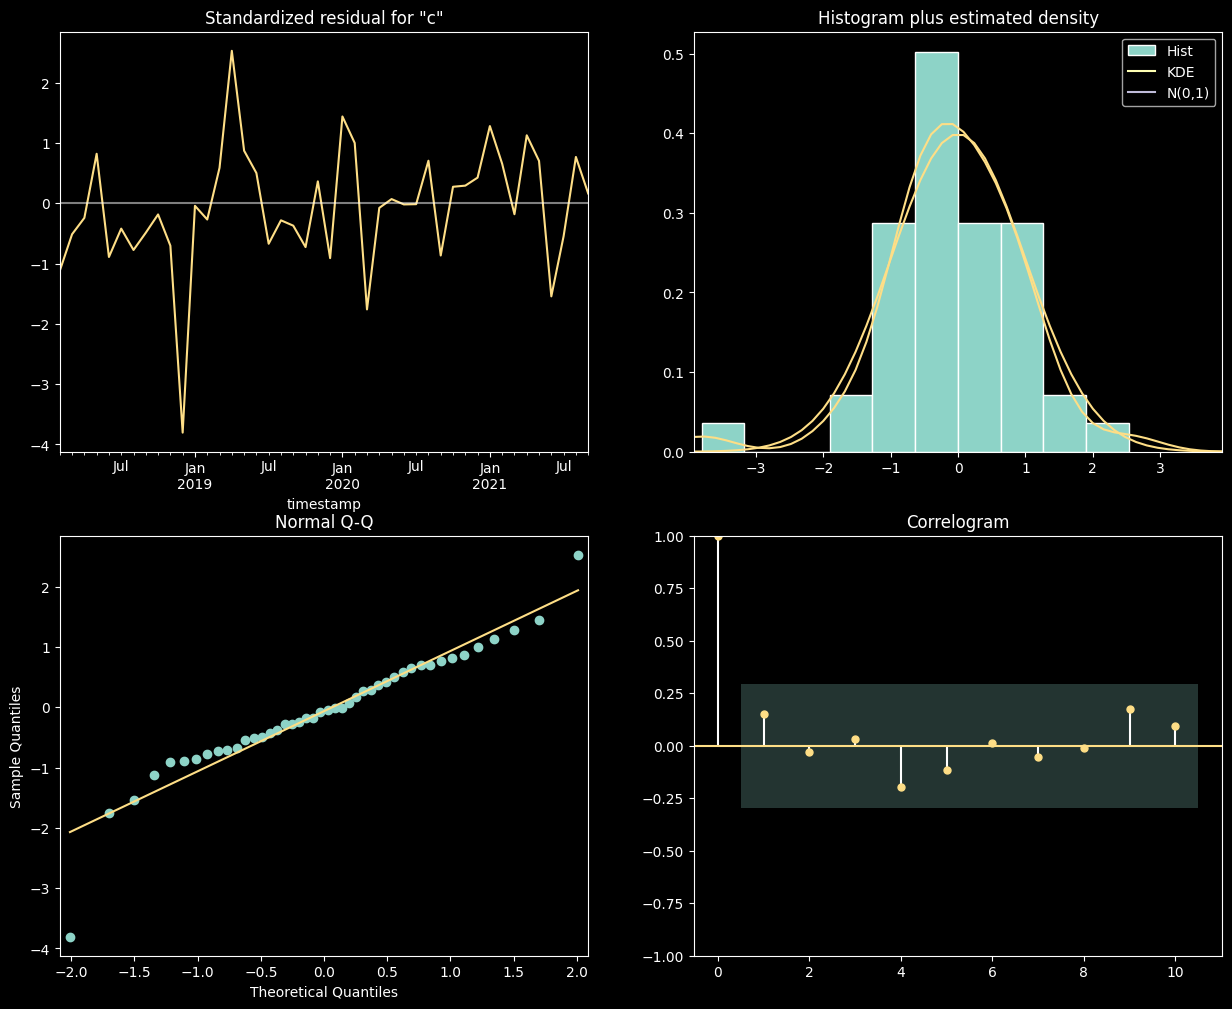


Results for Binance Coin:
  parameters         aic
1     (0, 1) -132.091536
3     (1, 0) -130.374969
4     (1, 1) -130.165852
2     (0, 2) -130.149722
6     (2, 0) -129.530960
Best model for Binance Coin:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  68.046
Date:                Thu, 21 Nov 2024   AIC                           -132.092
Time:                        11:56:54   BIC                           -128.523
Sample:                    01-31-2018   HQIC                          -130.768
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L

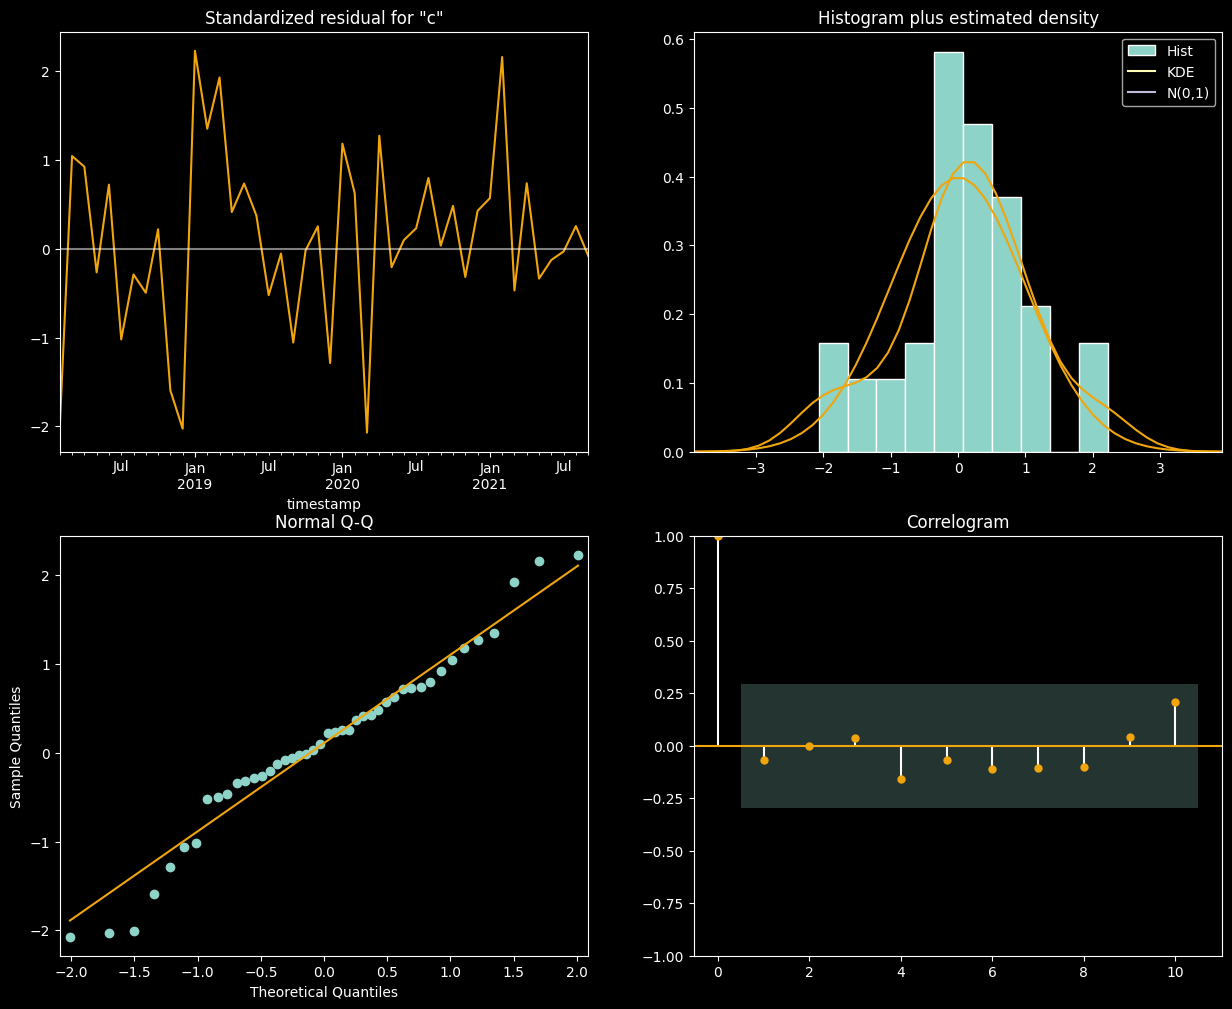


Results for Bitcoin:
  parameters         aic
3     (1, 0) -446.120713
1     (0, 1) -445.330888
6     (2, 0) -444.157793
4     (1, 1) -444.142173
2     (0, 2) -443.595924
Best model for Bitcoin:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 225.060
Date:                Thu, 21 Nov 2024   AIC                           -446.121
Time:                        11:56:56   BIC                           -442.552
Sample:                    01-31-2018   HQIC                          -444.797
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         

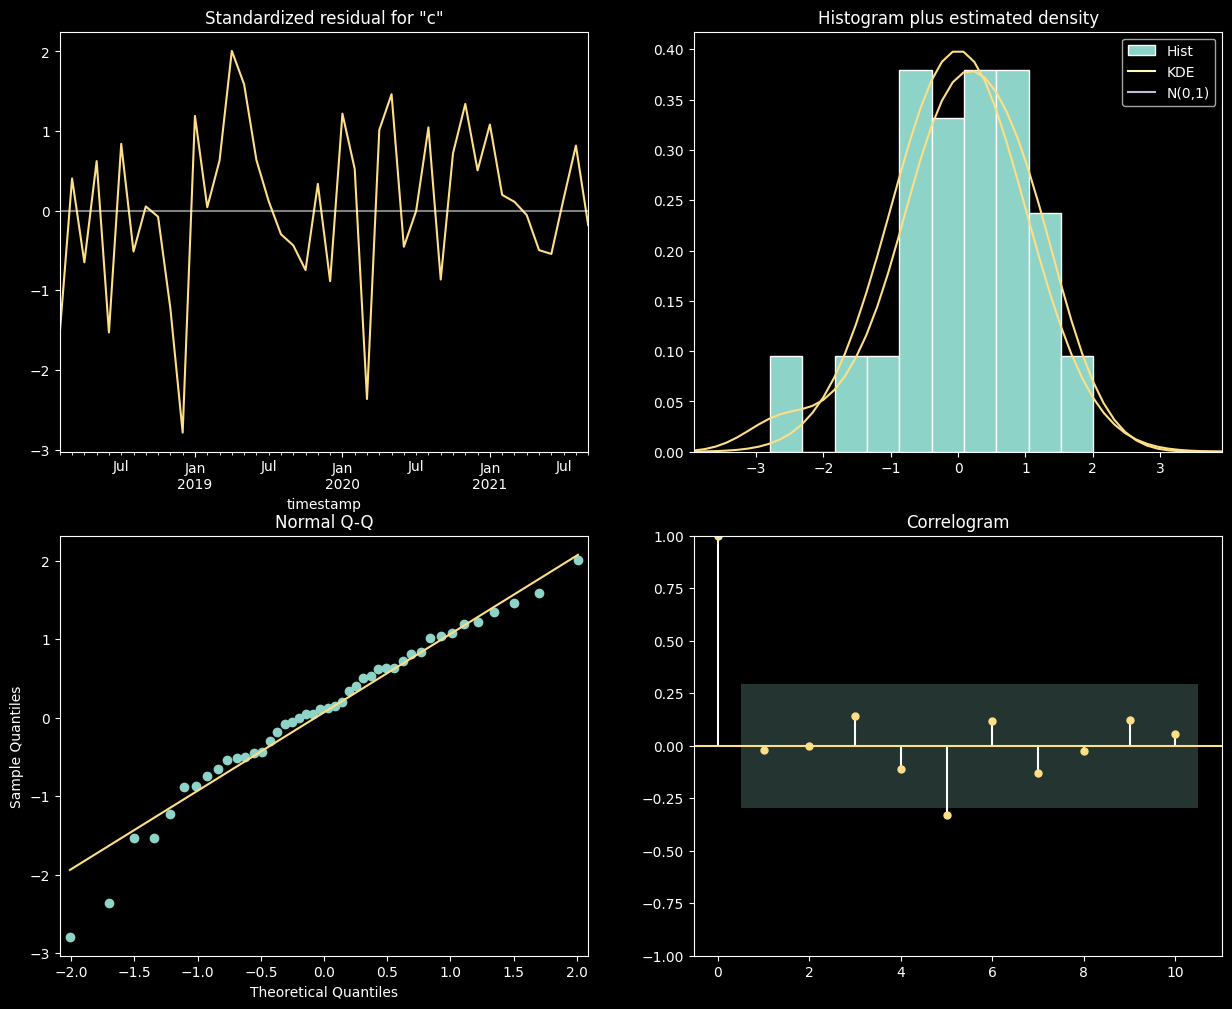


Results for EOS.IO:
  parameters        aic
0     (0, 0) -95.921195
2     (0, 2) -94.372447
1     (0, 1) -94.314501
3     (1, 0) -94.163433
6     (2, 0) -93.940532
Best model for EOS.IO:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  48.961
Date:                Thu, 21 Nov 2024   AIC                            -95.921
Time:                        11:56:58   BIC                            -94.137
Sample:                    01-31-2018   HQIC                           -95.260
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0063 

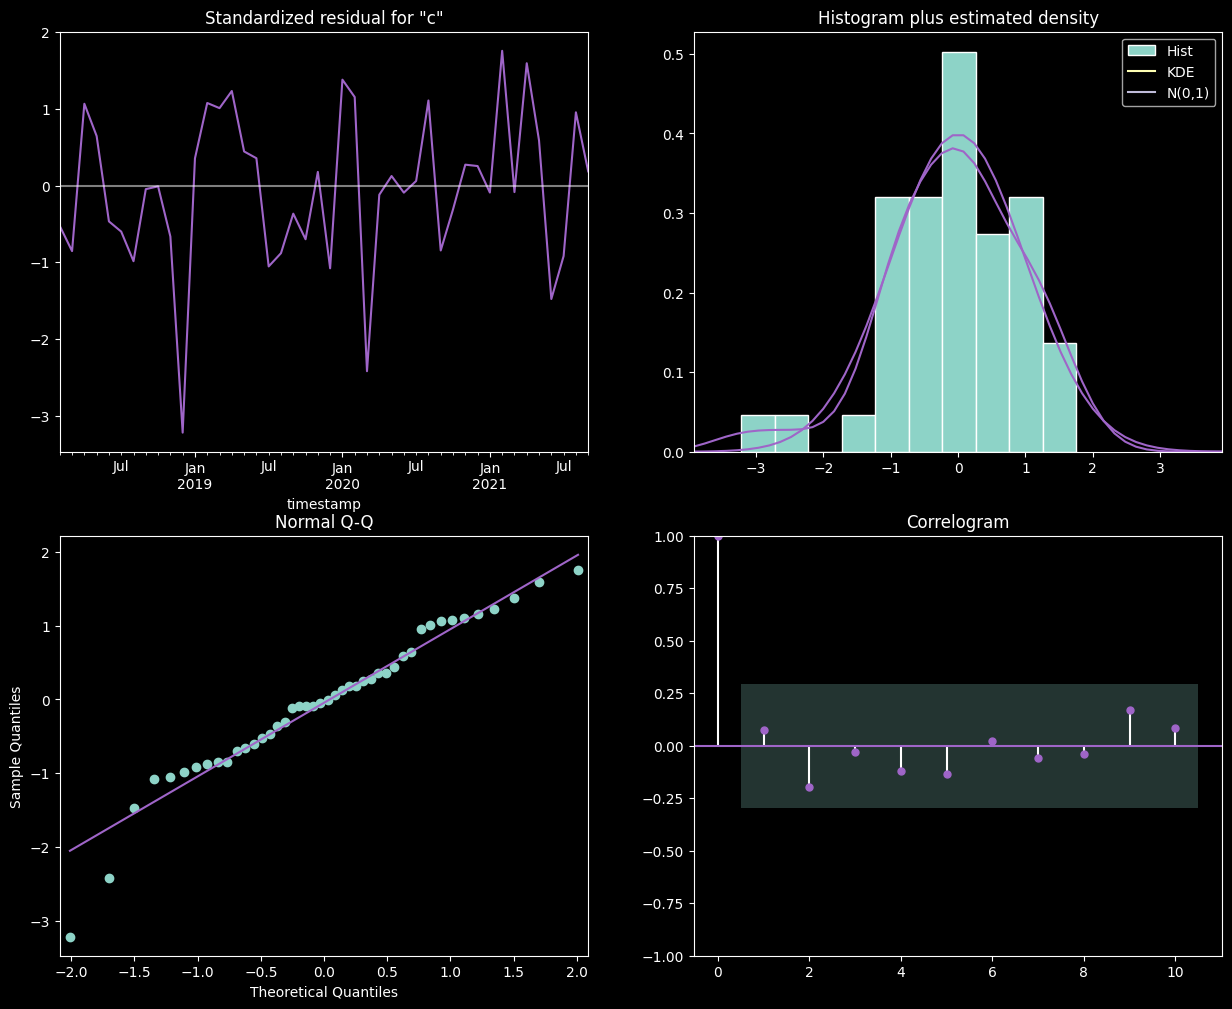


Results for Ethereum Classic:
  parameters         aic
0     (0, 0) -125.953629
1     (0, 1) -125.343231
4     (1, 1) -125.092193
3     (1, 0) -125.005828
2     (0, 2) -124.329775
Best model for Ethereum Classic:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  63.977
Date:                Thu, 21 Nov 2024   AIC                           -125.954
Time:                        11:57:00   BIC                           -124.169
Sample:                    01-31-2018   HQIC                          -125.292
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

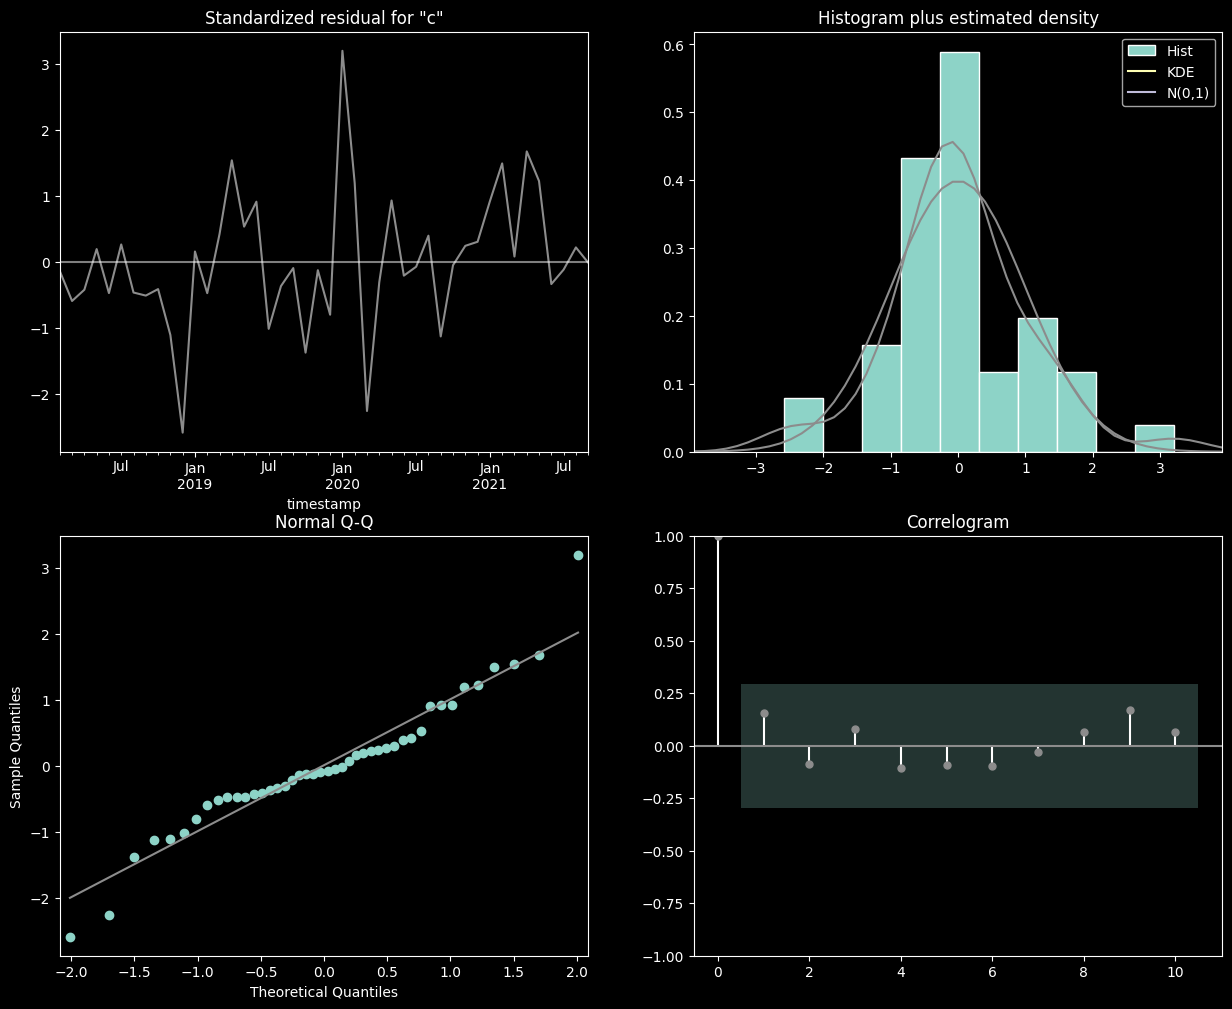


Results for Ethereum:
  parameters         aic
0     (0, 0) -237.239959
1     (0, 1) -236.844826
3     (1, 0) -236.796161
4     (1, 1) -235.557851
2     (0, 2) -234.943504
Best model for Ethereum:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 119.620
Date:                Thu, 21 Nov 2024   AIC                           -237.240
Time:                        11:57:02   BIC                           -235.456
Sample:                    01-31-2018   HQIC                          -236.578
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      

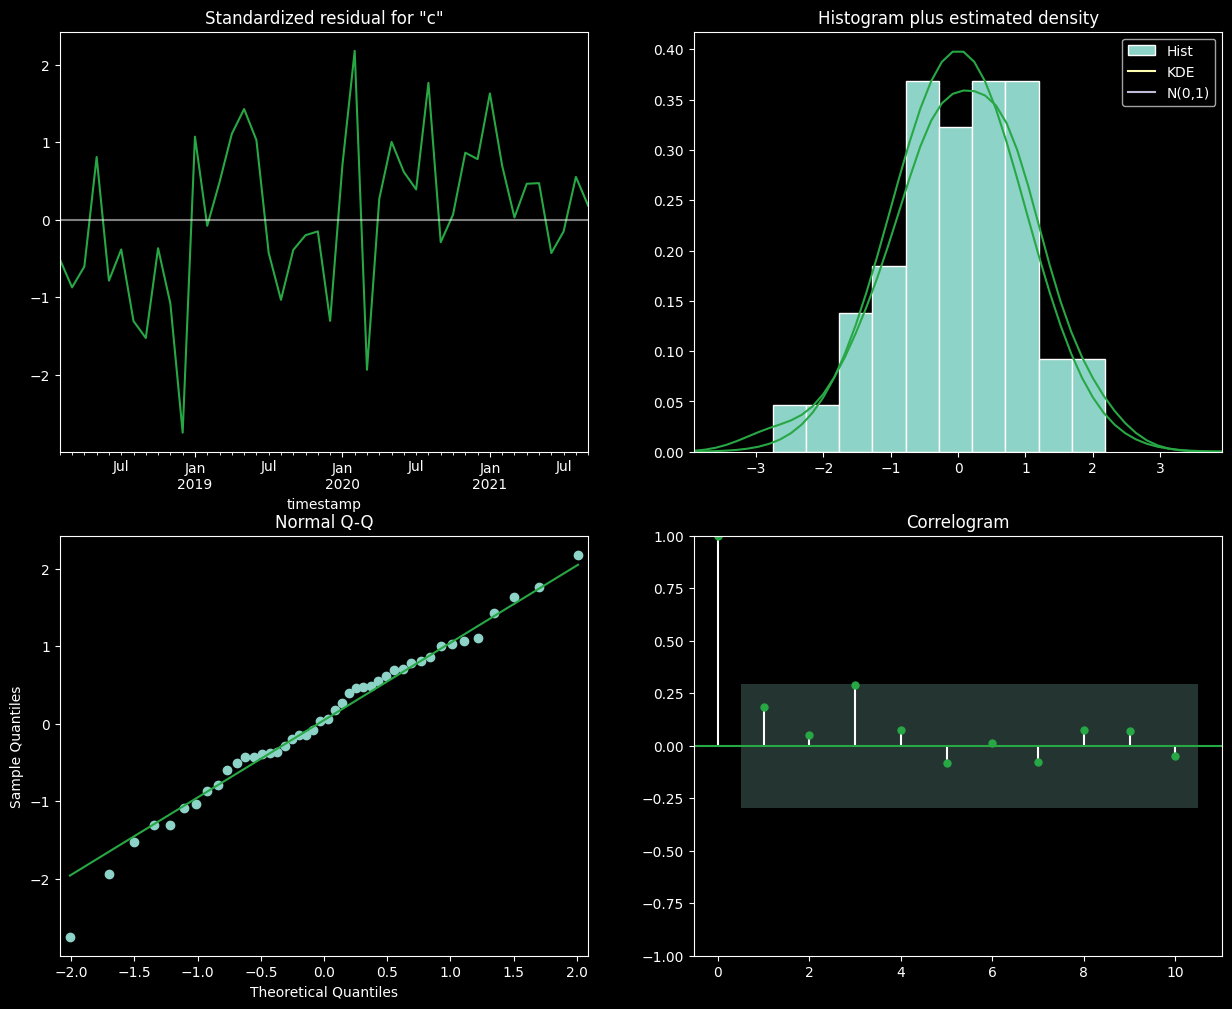


Results for Litecoin:
  parameters         aic
1     (0, 1) -119.695478
3     (1, 0) -119.313606
4     (1, 1) -117.799428
2     (0, 2) -117.745284
6     (2, 0) -117.399083
Best model for Litecoin:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  61.848
Date:                Thu, 21 Nov 2024   AIC                           -119.695
Time:                        11:57:04   BIC                           -116.127
Sample:                    01-31-2018   HQIC                          -118.372
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1       

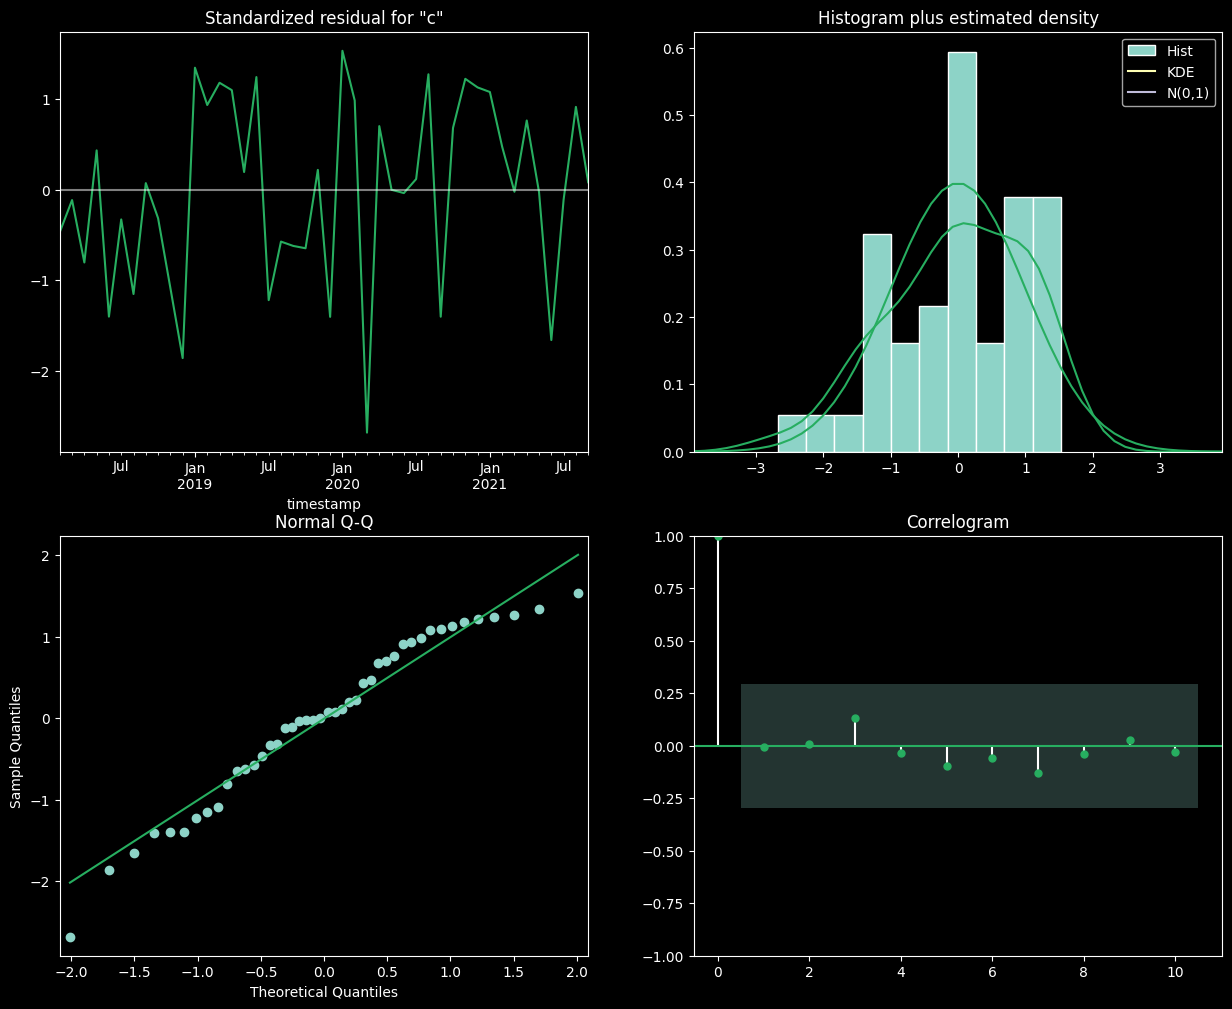


Results for Monero:
  parameters         aic
0     (0, 0) -156.380812
3     (1, 0) -154.681907
1     (0, 1) -154.625697
2     (0, 2) -153.256644
6     (2, 0) -153.246906
Best model for Monero:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  79.190
Date:                Thu, 21 Nov 2024   AIC                           -156.381
Time:                        11:57:06   BIC                           -154.597
Sample:                    01-31-2018   HQIC                          -155.719
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0

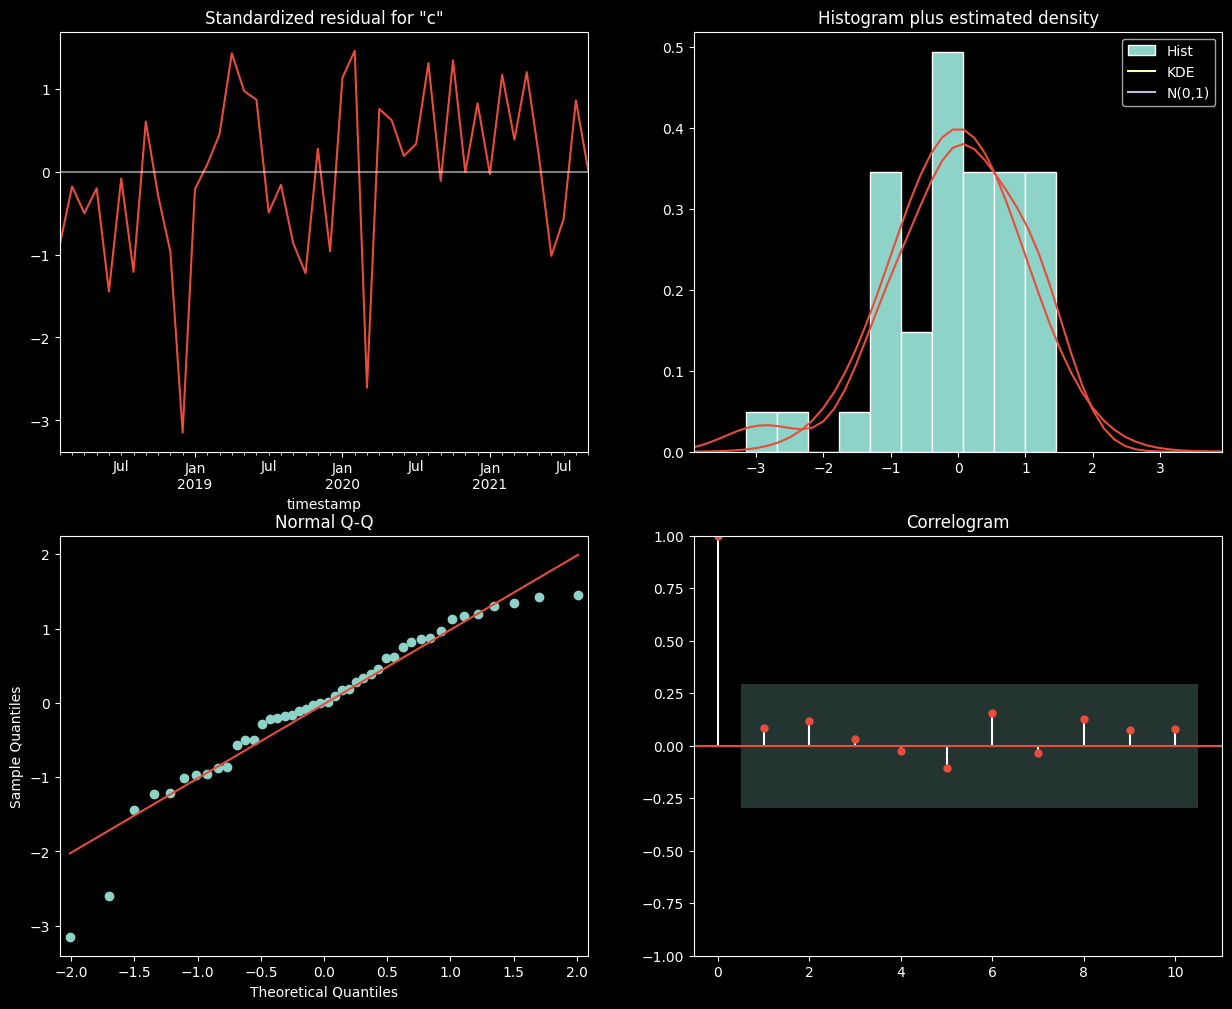


Results for TRON:
  parameters         aic
0     (0, 0)  201.216289
2     (0, 2)  201.224381
4     (1, 1)  202.071343
7     (2, 1)  202.366753
6     (2, 0)  202.604159
Best model for TRON:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   44
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -99.608
Date:                Thu, 21 Nov 2024   AIC                            201.216
Time:                        11:57:07   BIC                            202.977
Sample:                    02-28-2018   HQIC                           201.866
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.019

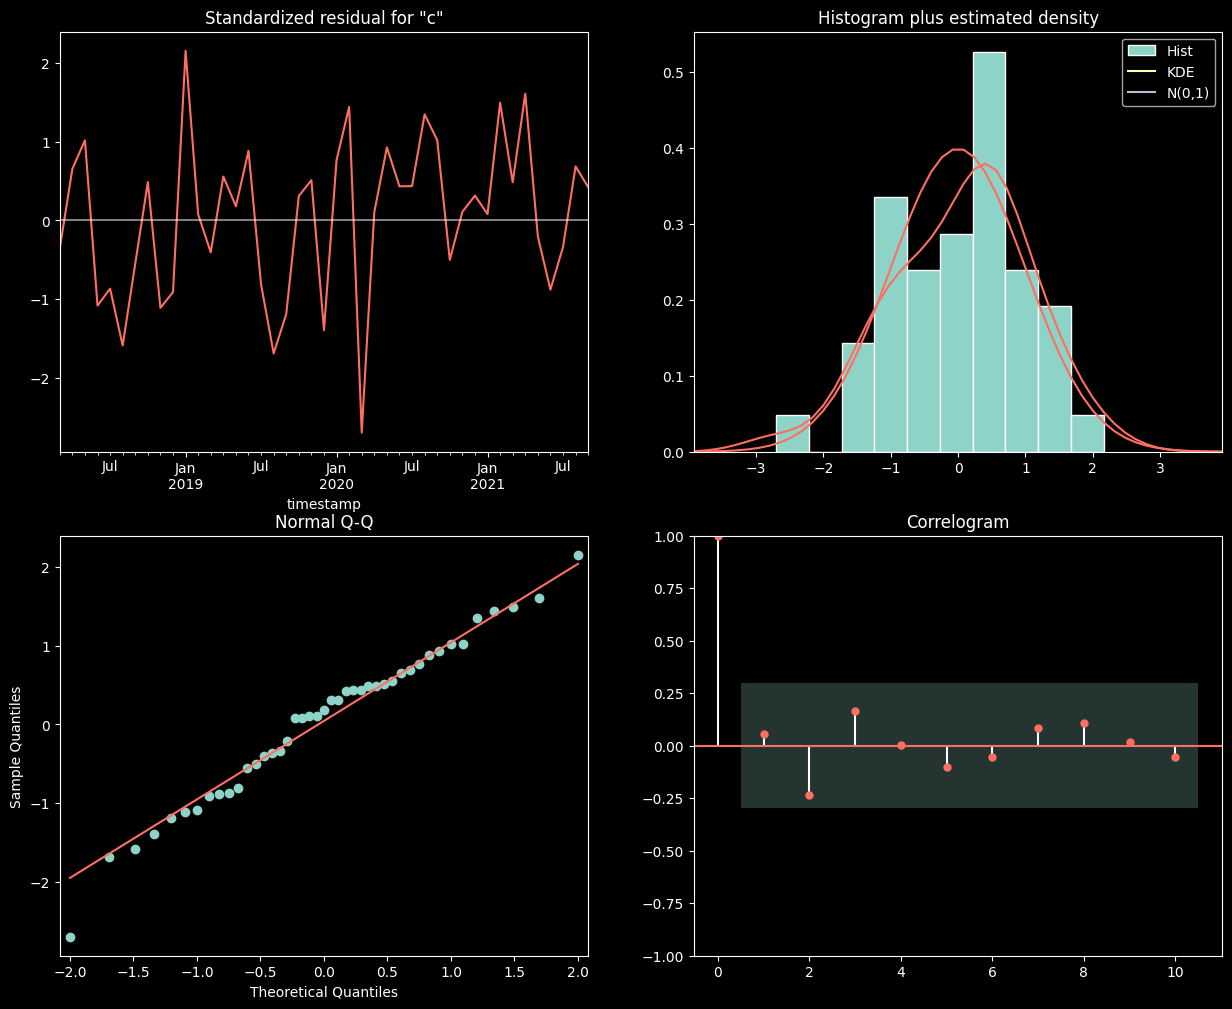


Results for Stellar:
  parameters        aic
0     (0, 0)  31.168212
1     (0, 1)  31.303084
8     (2, 2)  31.462194
4     (1, 1)  31.653452
3     (1, 0)  31.761391
Best model for Stellar:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   44
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -14.584
Date:                Thu, 21 Nov 2024   AIC                             31.168
Time:                        11:57:09   BIC                             32.929
Sample:                    02-28-2018   HQIC                            31.818
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.115

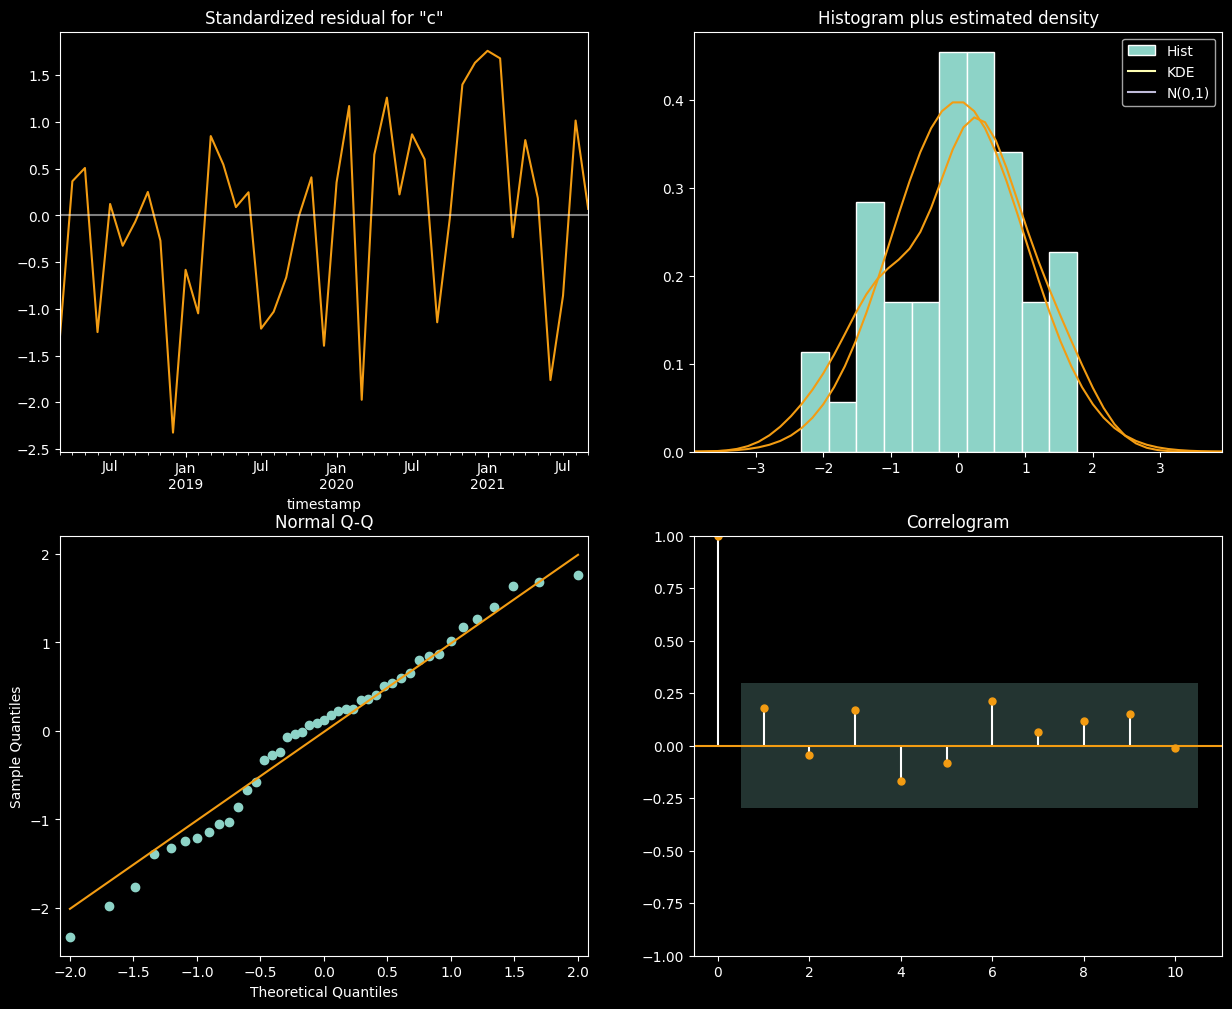


Results for Cardano:
  parameters         aic
1     (0, 1)  120.460587
3     (1, 0)  120.609300
0     (0, 0)  120.888716
4     (1, 1)  121.132030
2     (0, 2)  122.169007
Best model for Cardano:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   42
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -58.230
Date:                Thu, 21 Nov 2024   AIC                            120.461
Time:                        11:57:10   BIC                            123.888
Sample:                    04-30-2018   HQIC                           121.709
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         

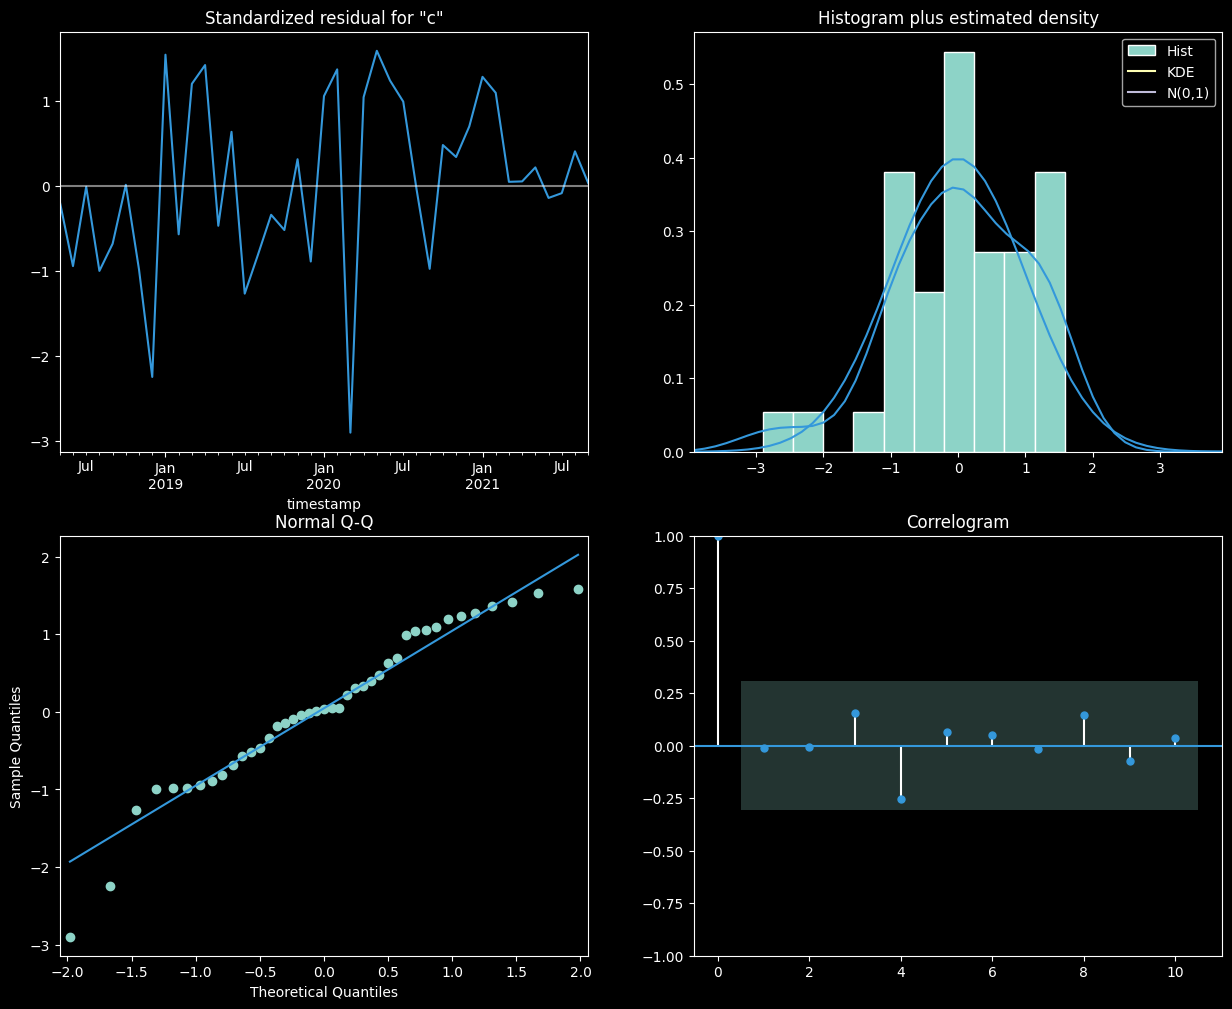


Results for IOTA:
  parameters        aic
0     (0, 0)  59.681022
1     (0, 1)  60.644647
3     (1, 0)  61.051129
2     (0, 2)  61.486049
6     (2, 0)  61.653449
Best model for IOTA:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   41
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -28.841
Date:                Thu, 21 Nov 2024   AIC                             59.681
Time:                        11:57:12   BIC                             61.370
Sample:                    05-31-2018   HQIC                            60.292
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2476     

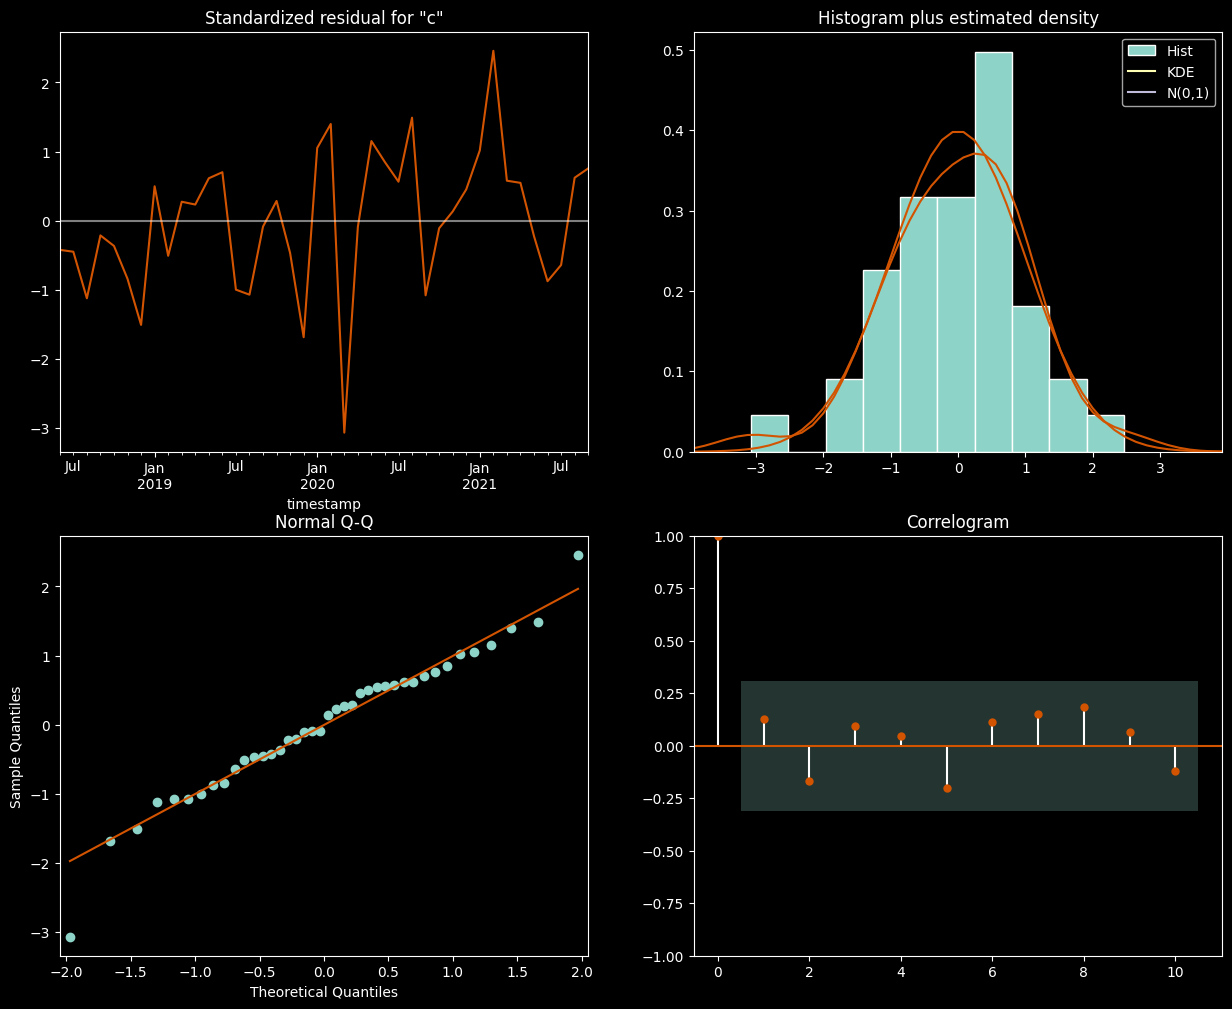


Results for Maker:
  parameters         aic
0     (0, 0) -550.759486
2     (0, 2) -549.140839
6     (2, 0) -549.037416
3     (1, 0) -548.771909
1     (0, 1) -548.730409
Best model for Maker:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   41
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 276.380
Date:                Thu, 21 Nov 2024   AIC                           -550.759
Time:                        11:57:13   BIC                           -549.071
Sample:                    05-31-2018   HQIC                          -550.149
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.691e

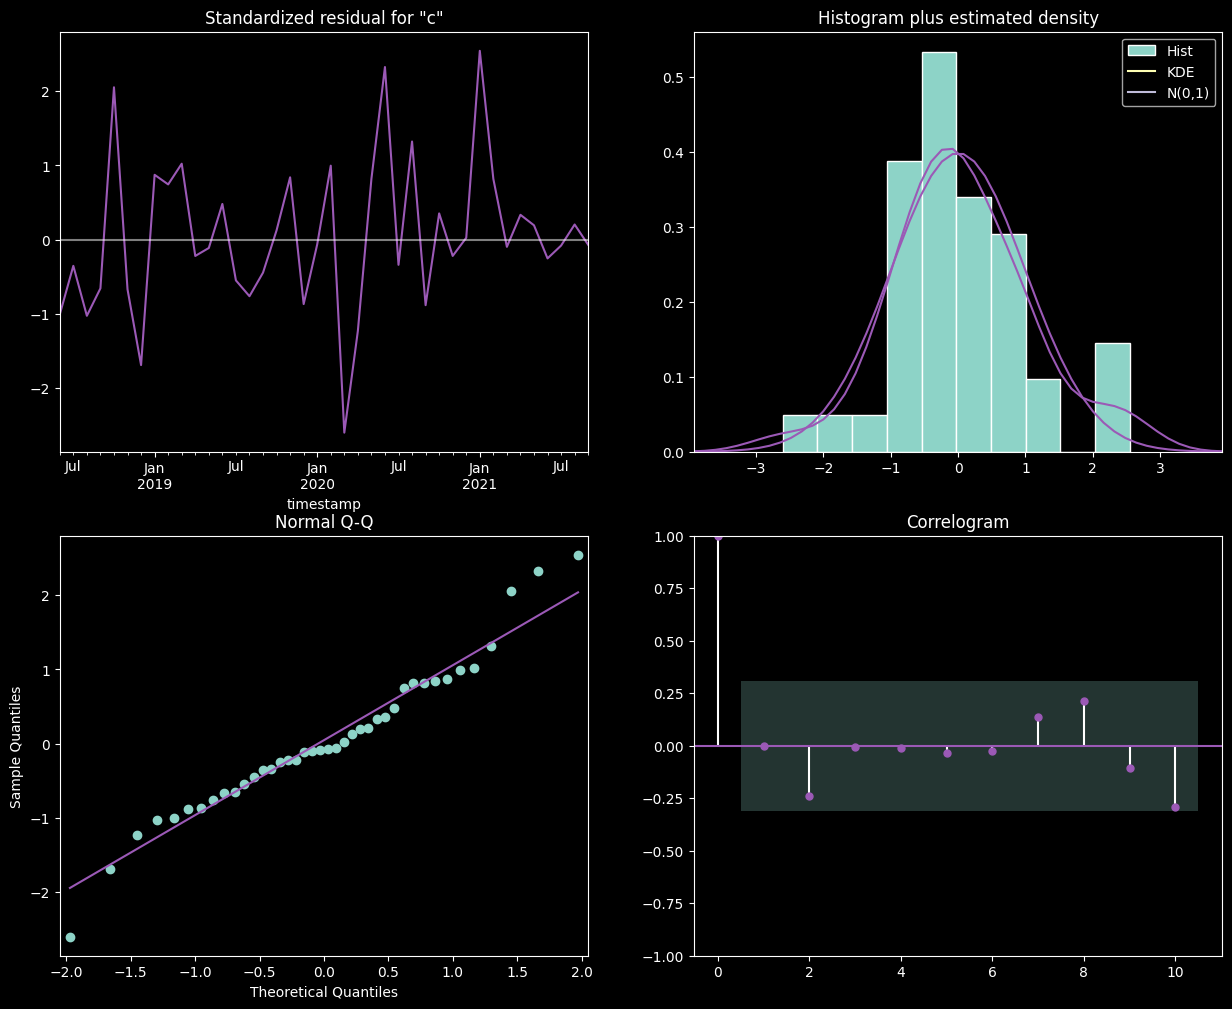


Results for Dogecoin:
  parameters         aic
4     (1, 1)  196.810267
1     (0, 1)  196.996143
2     (0, 2)  197.011016
7     (2, 1)  198.773424
5     (1, 2)  198.796583
Best model for Dogecoin:
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   30
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -95.405
Date:                Thu, 21 Nov 2024   AIC                            196.810
Time:                        11:57:15   BIC                            200.912
Sample:                    04-30-2019   HQIC                           198.095
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

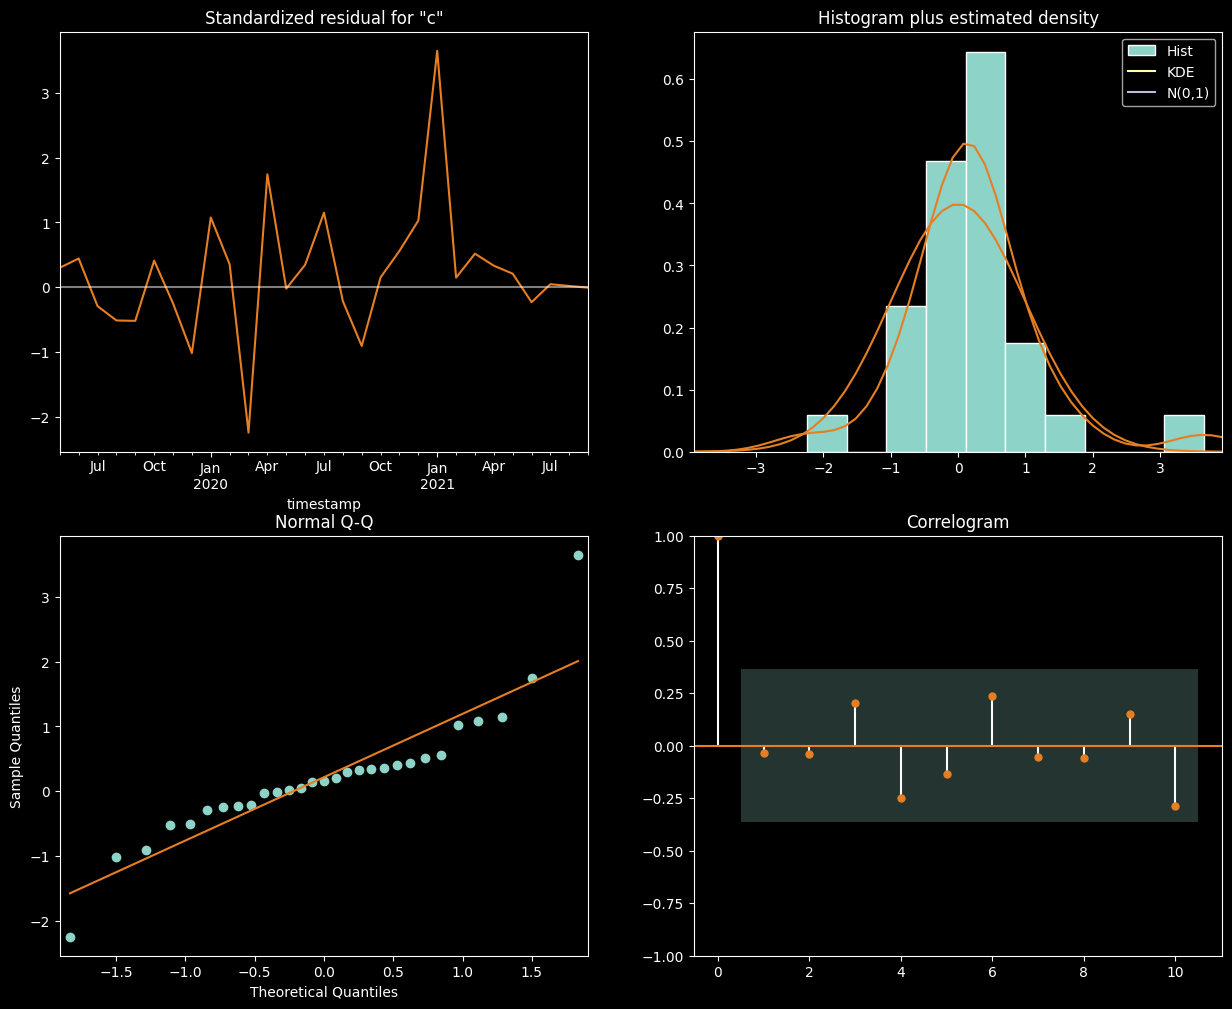

In [35]:
# Function to perform Box-Cox Transformation and SARIMAX Model Selection
def process_crypto_data(crypto_data, label, color):
    if not pd.api.types.is_datetime64_any_dtype(crypto_data.index):
        crypto_data.index = pd.to_datetime(crypto_data.index, unit='s')  # Convert to datetime index
    
    # Apply Box-Cox transformation to the "Close" column
    crypto_month = crypto_data.resample("M").mean()  # Resample to monthly frequency
    crypto_month["close_box"], lmbda = stats.boxcox(crypto_month.Close)

    # Define parameters for SARIMAX
    qs = range(0, 3)
    ps = range(0, 3)
    d = 1
    parameters = product(ps, qs)
    parameters_list = list(parameters)

    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    
    for param in parameters_list:
        try:
            model = SARIMAX(crypto_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print(f'Bad parameter combination: {param} for {label}')
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    # Create a result table and print the best model
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(f"\nResults for {label}:")
    print(result_table.sort_values(by='aic', ascending=True).head())
    print(f"Best model for {label}:")
    print(best_model.summary())

    # Plot diagnostics
    best_model.plot_diagnostics(figsize=(15, 12))
    for ax in plt.gcf().get_axes():
        for line in ax.get_lines():
            line.set_color(color)
    plt.show()

# Loop through the `crypto_data_mini` dictionary and process each cryptocurrency
for asset_id, crypto_data in crypto_data_mini.items():
    process_crypto_data(crypto_data, label=crypto_labels[asset_id], color=crypto_colors[asset_id])


In [36]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

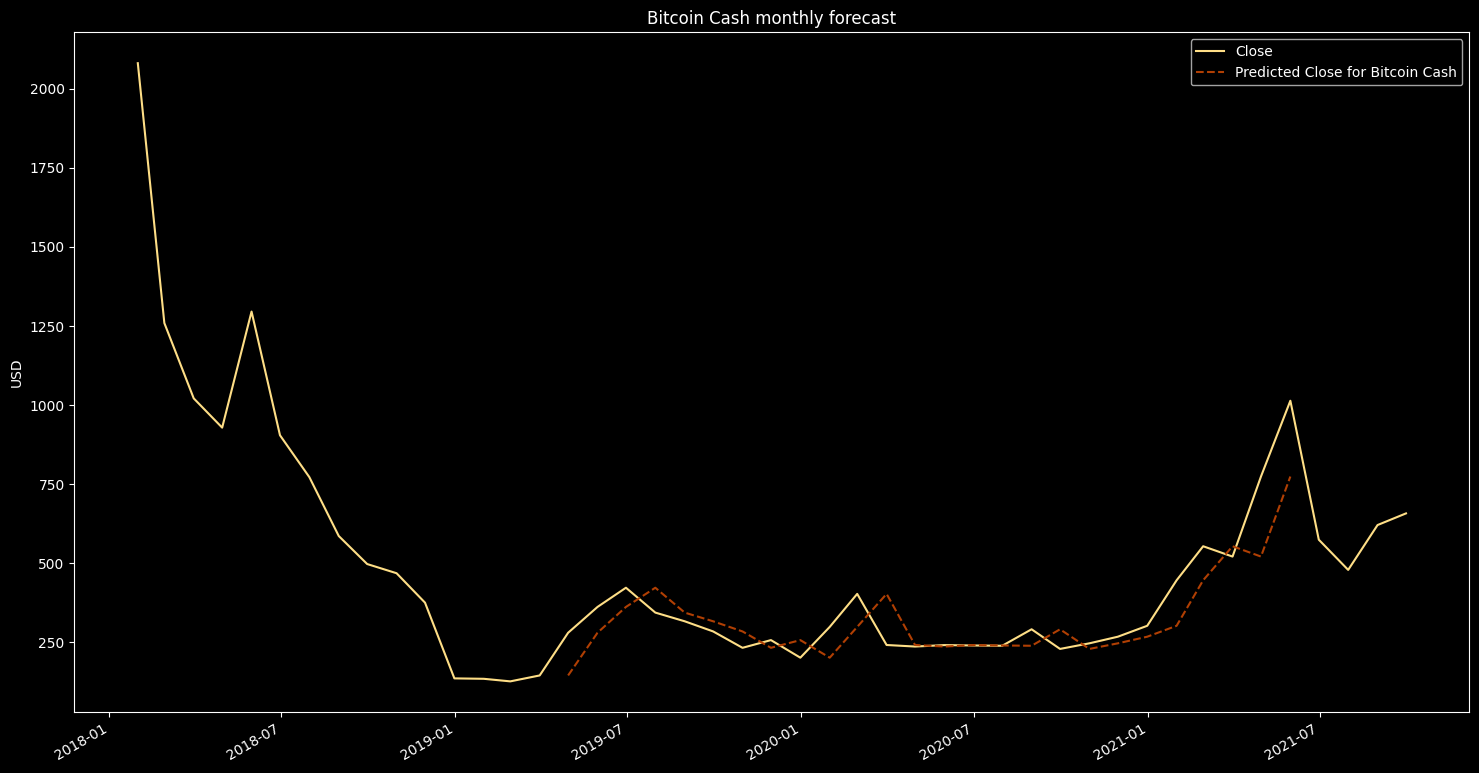

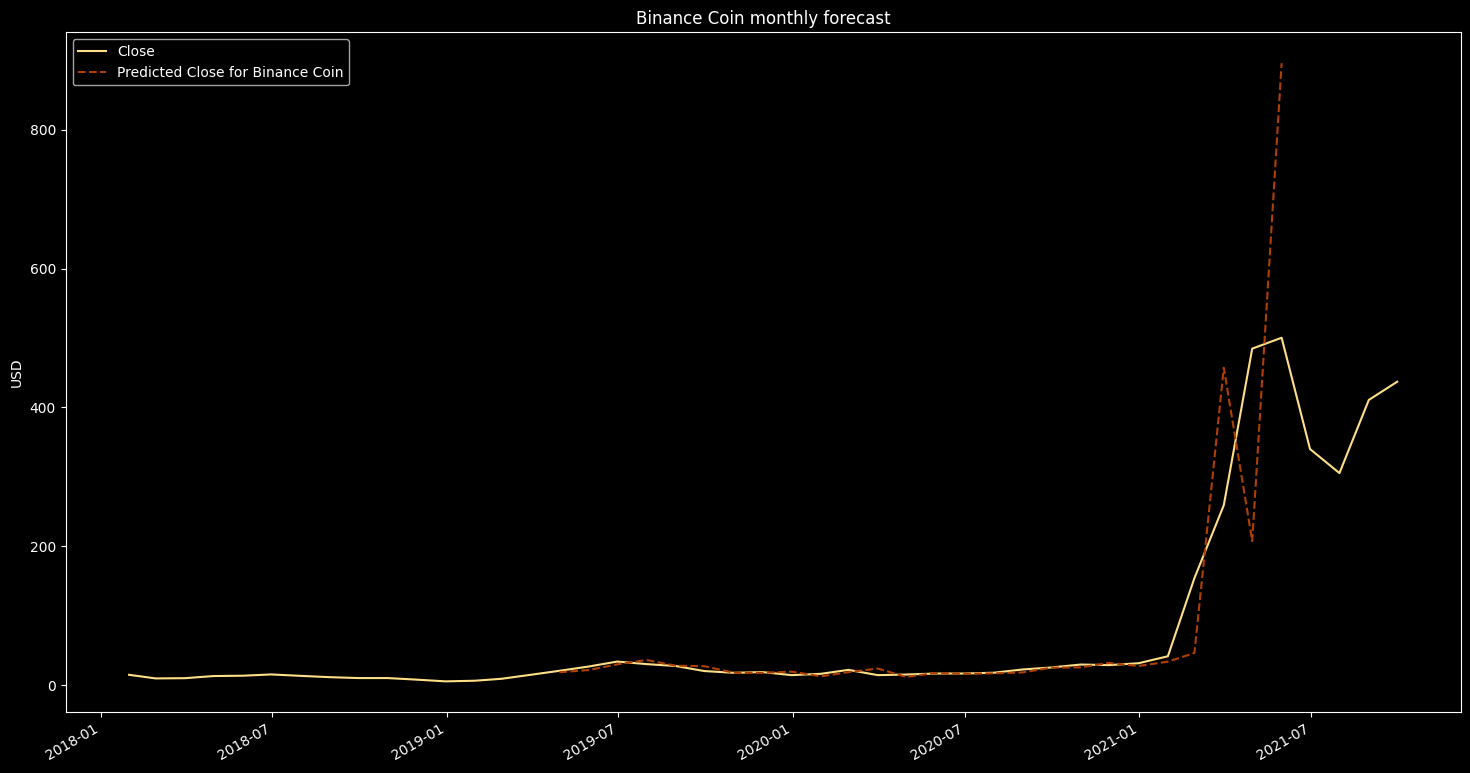

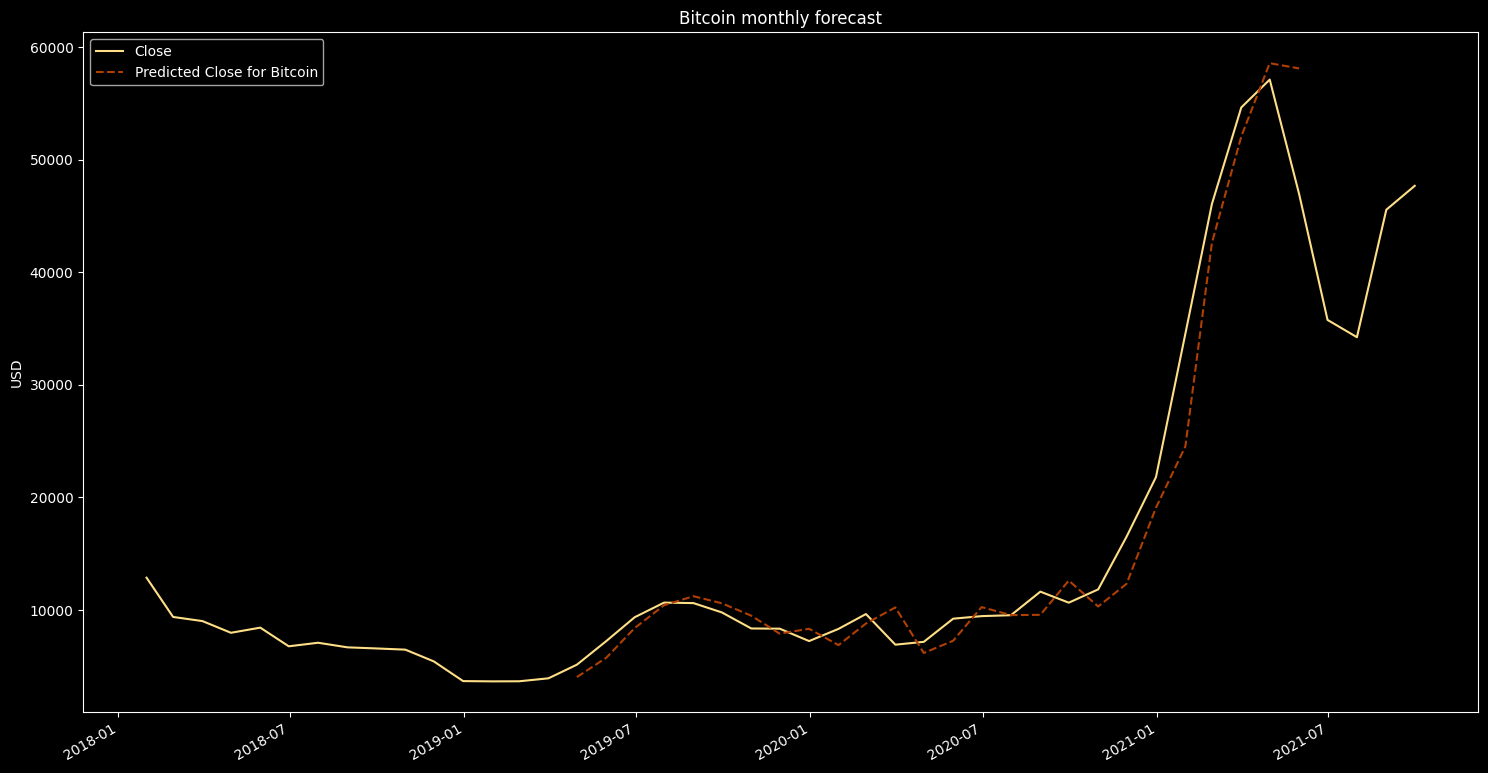

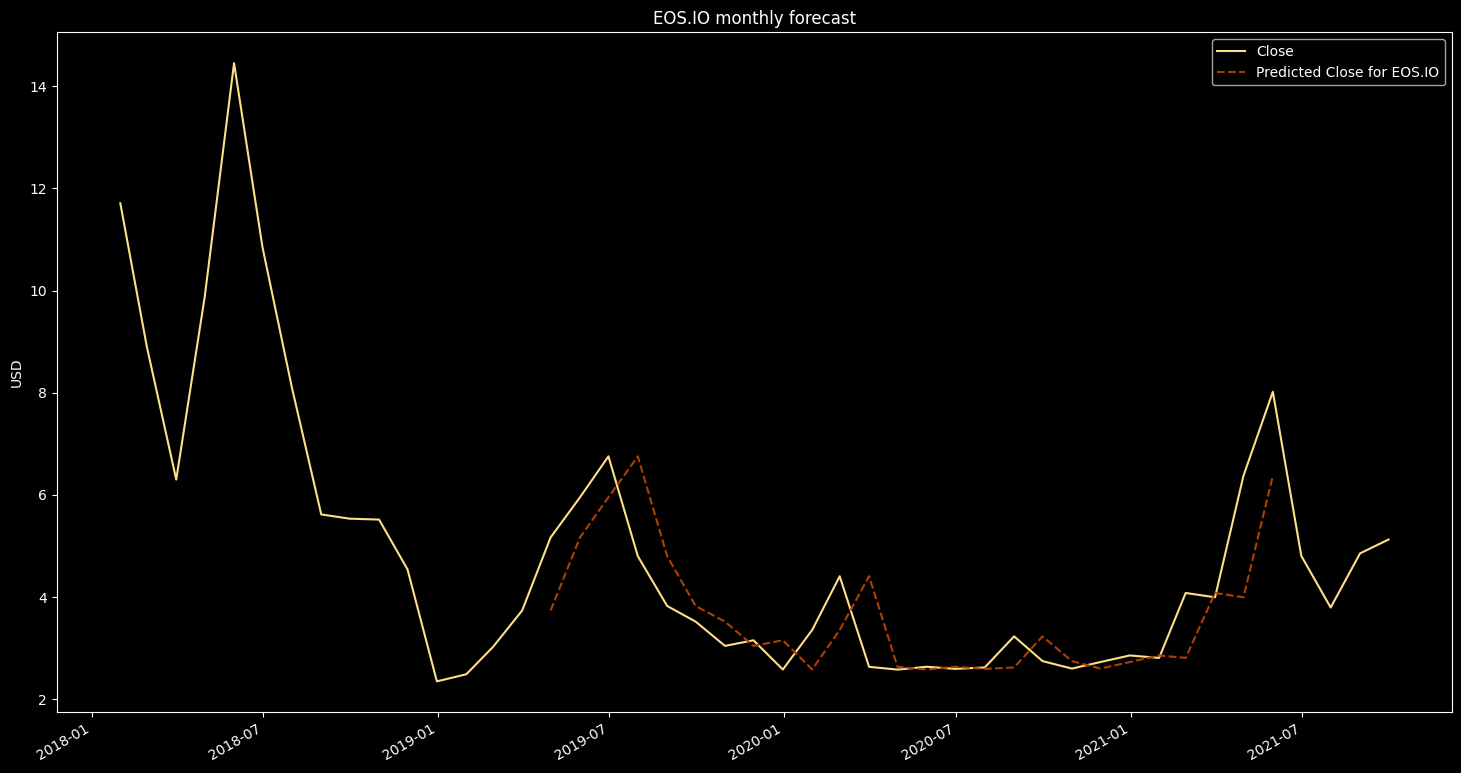

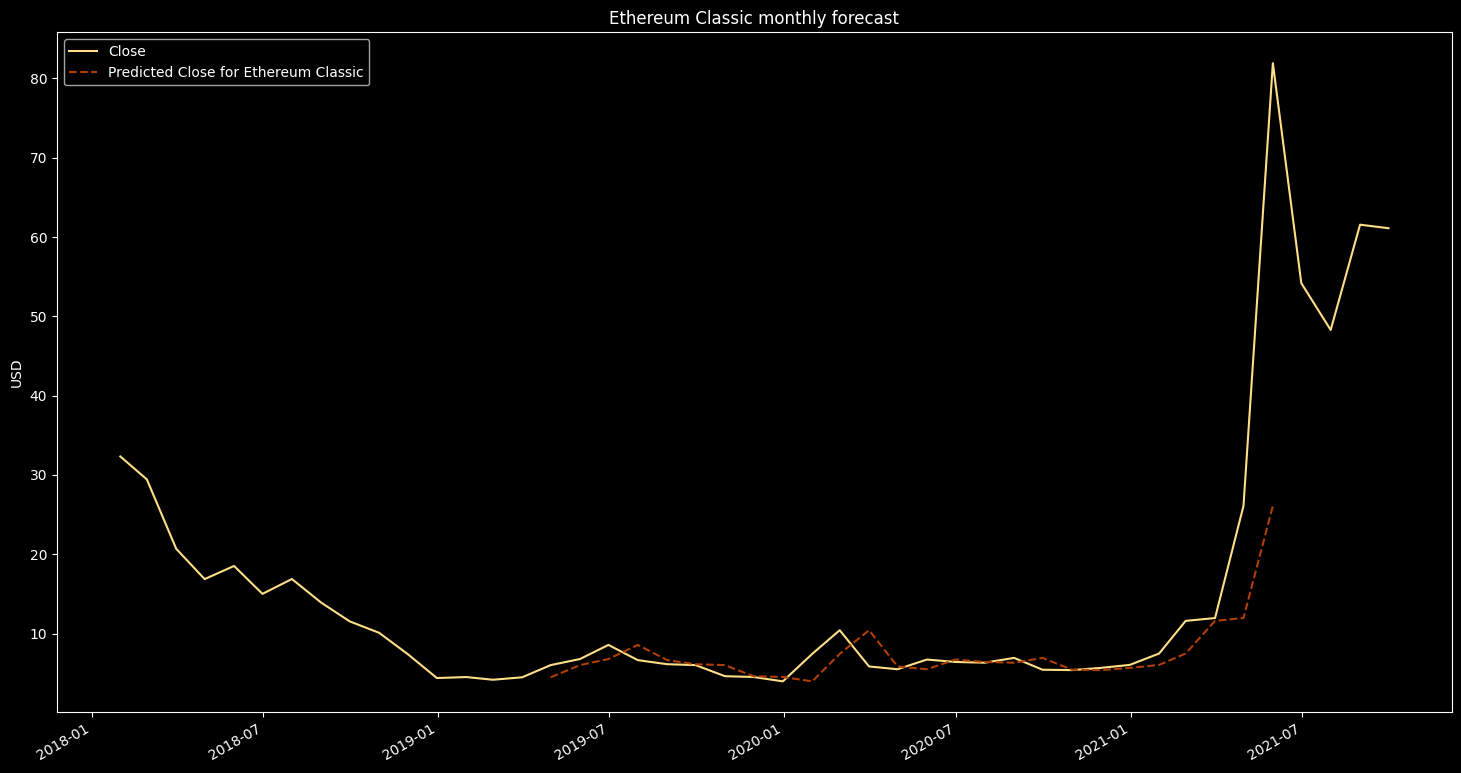

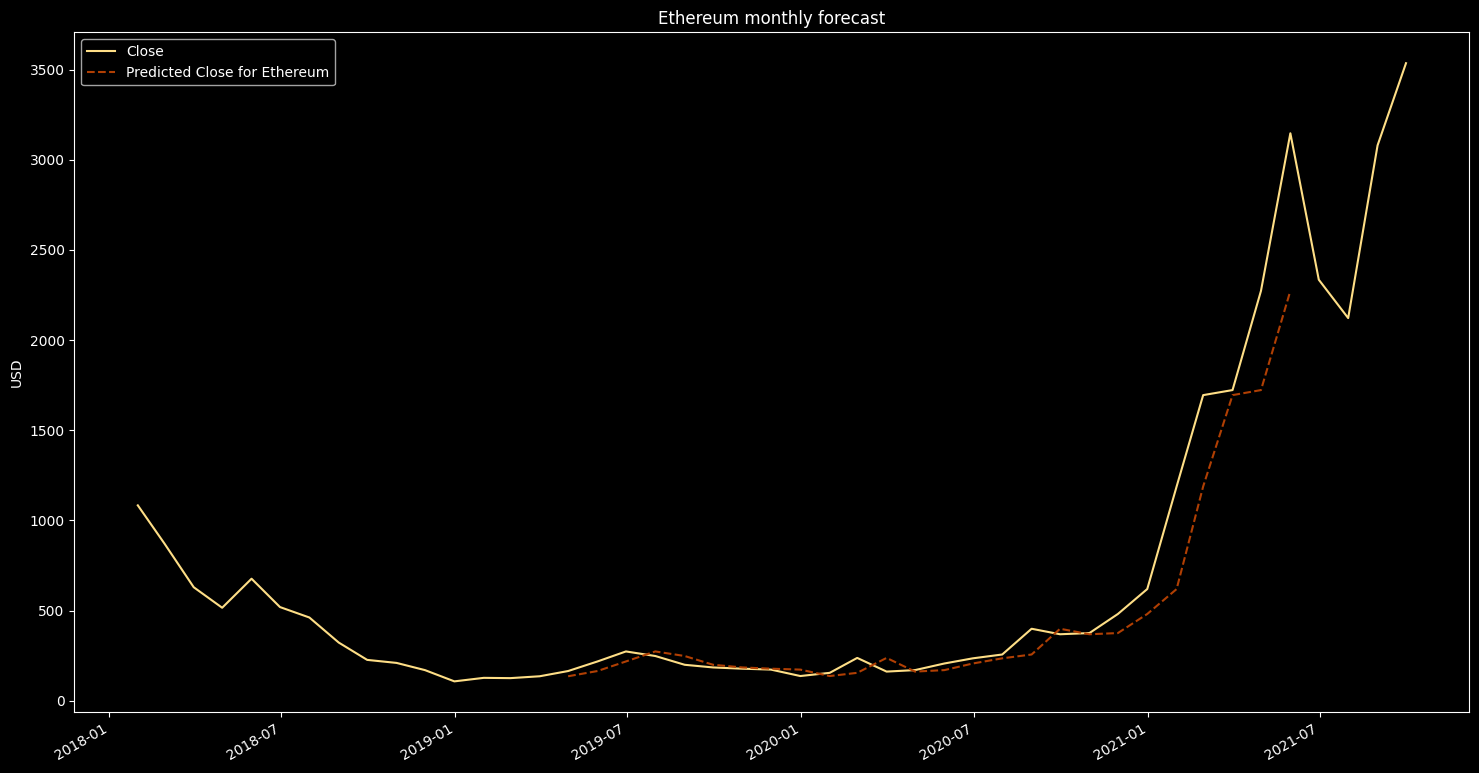

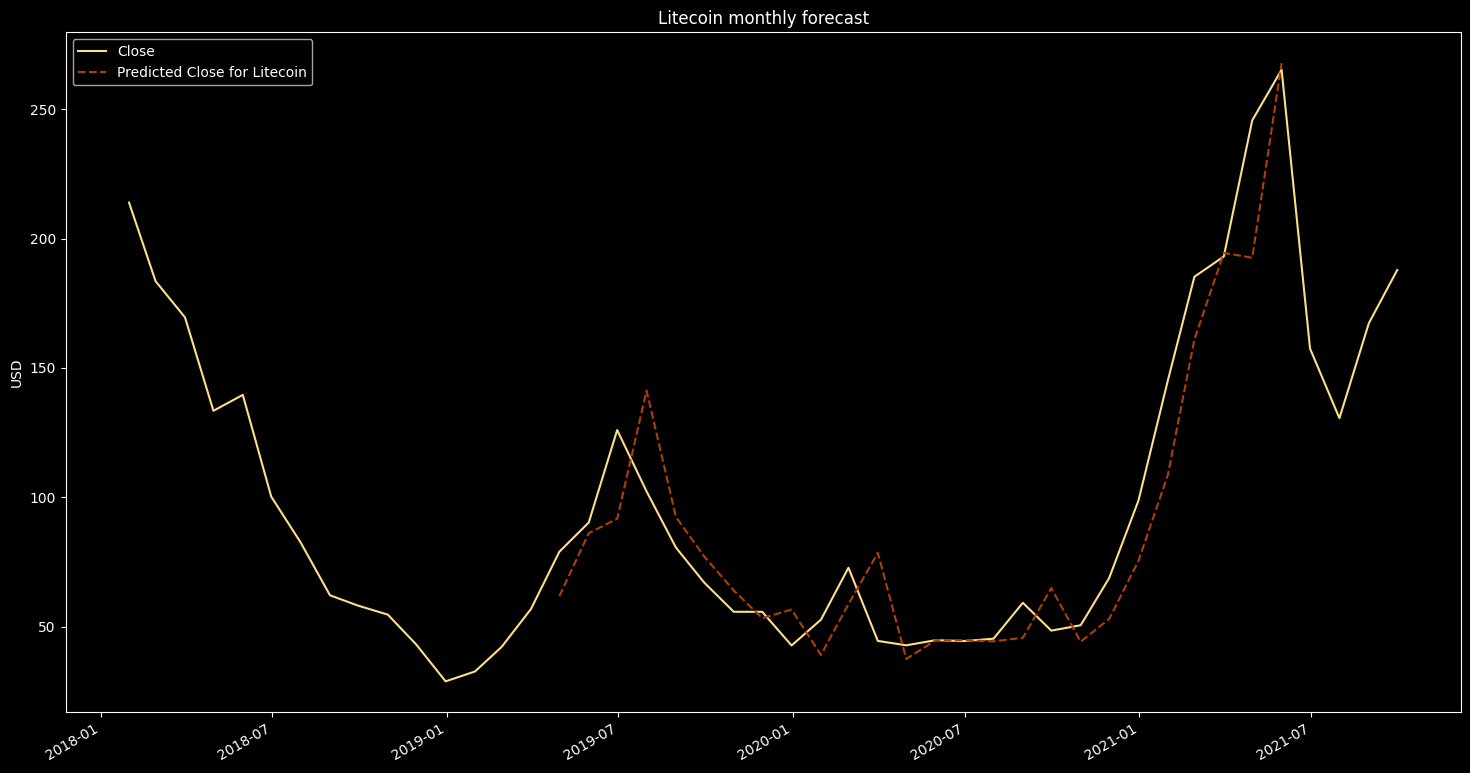

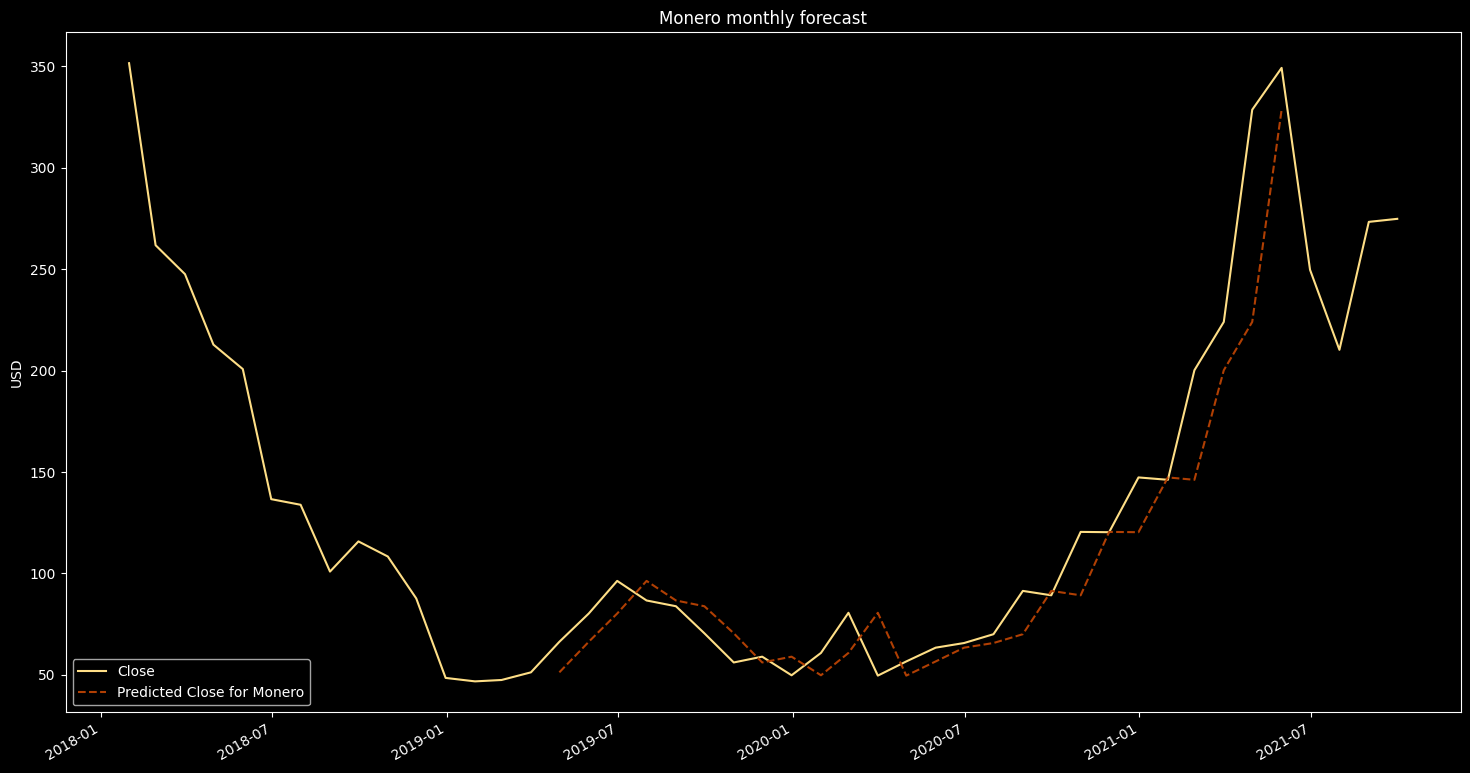

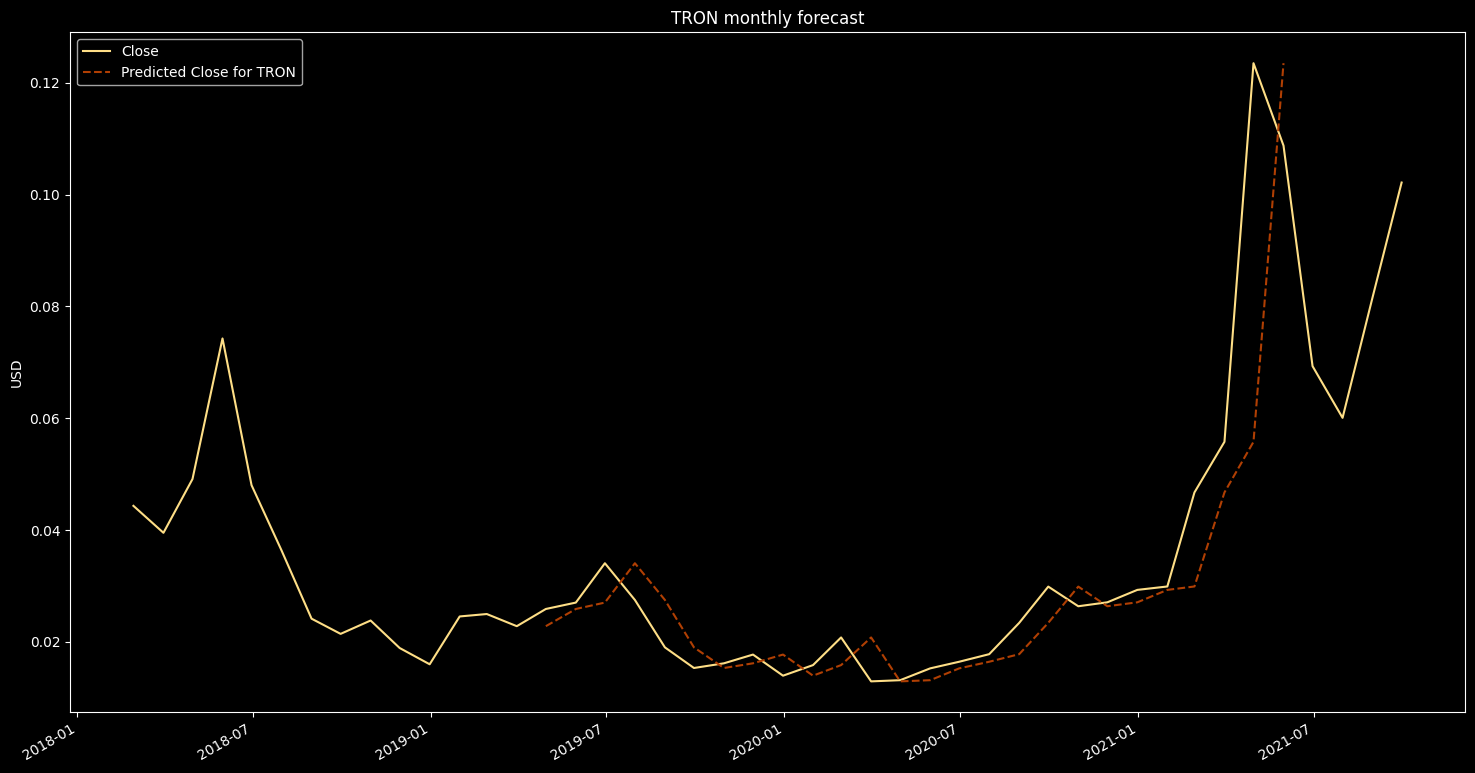

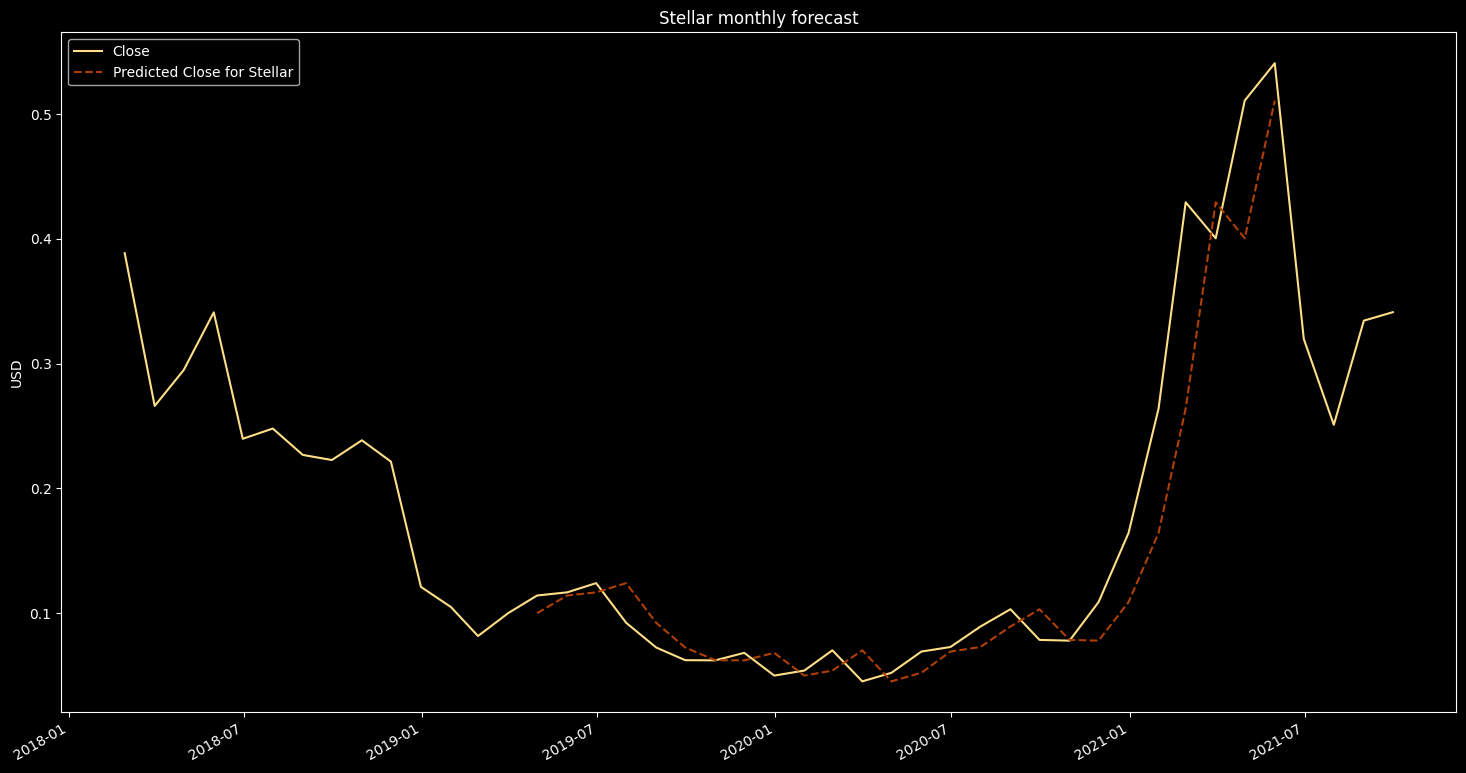

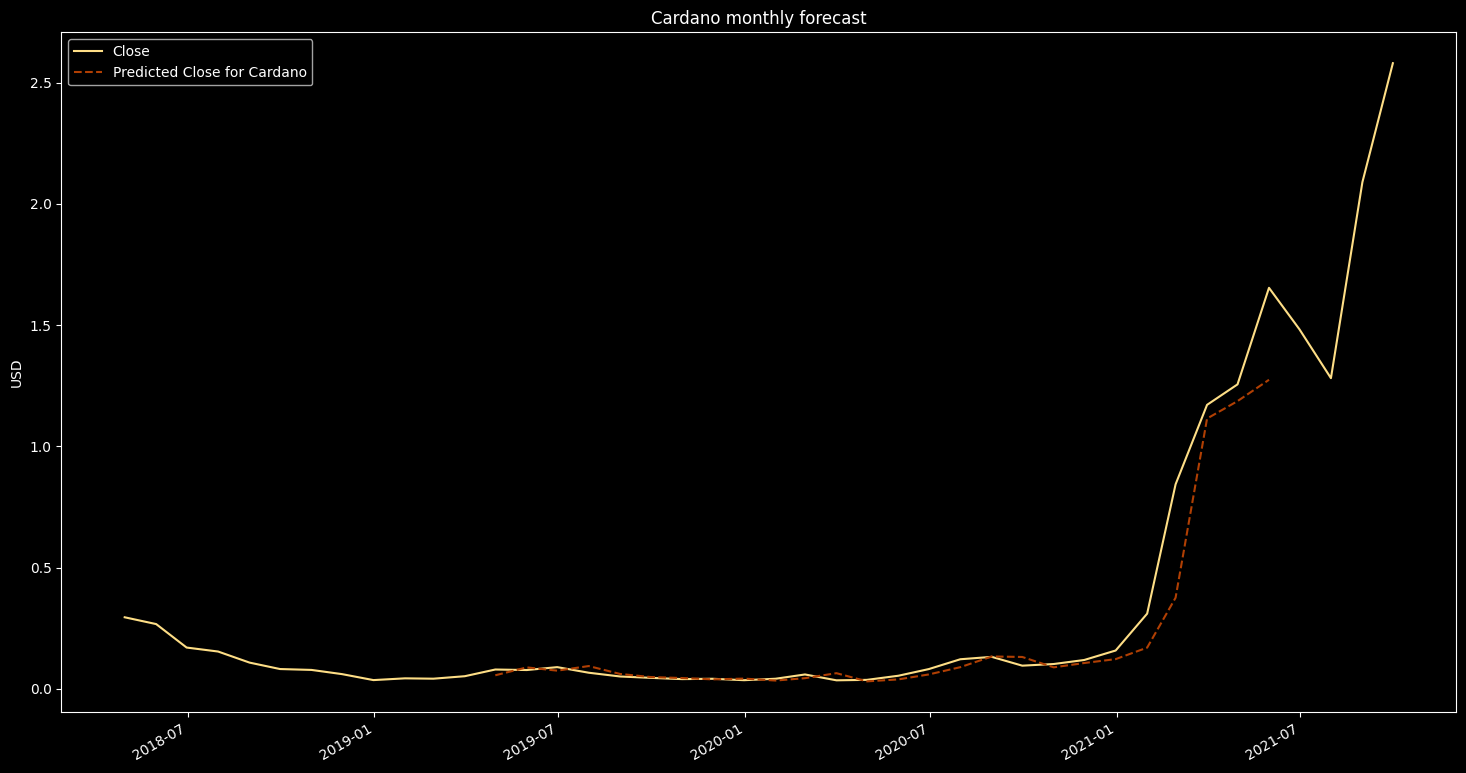

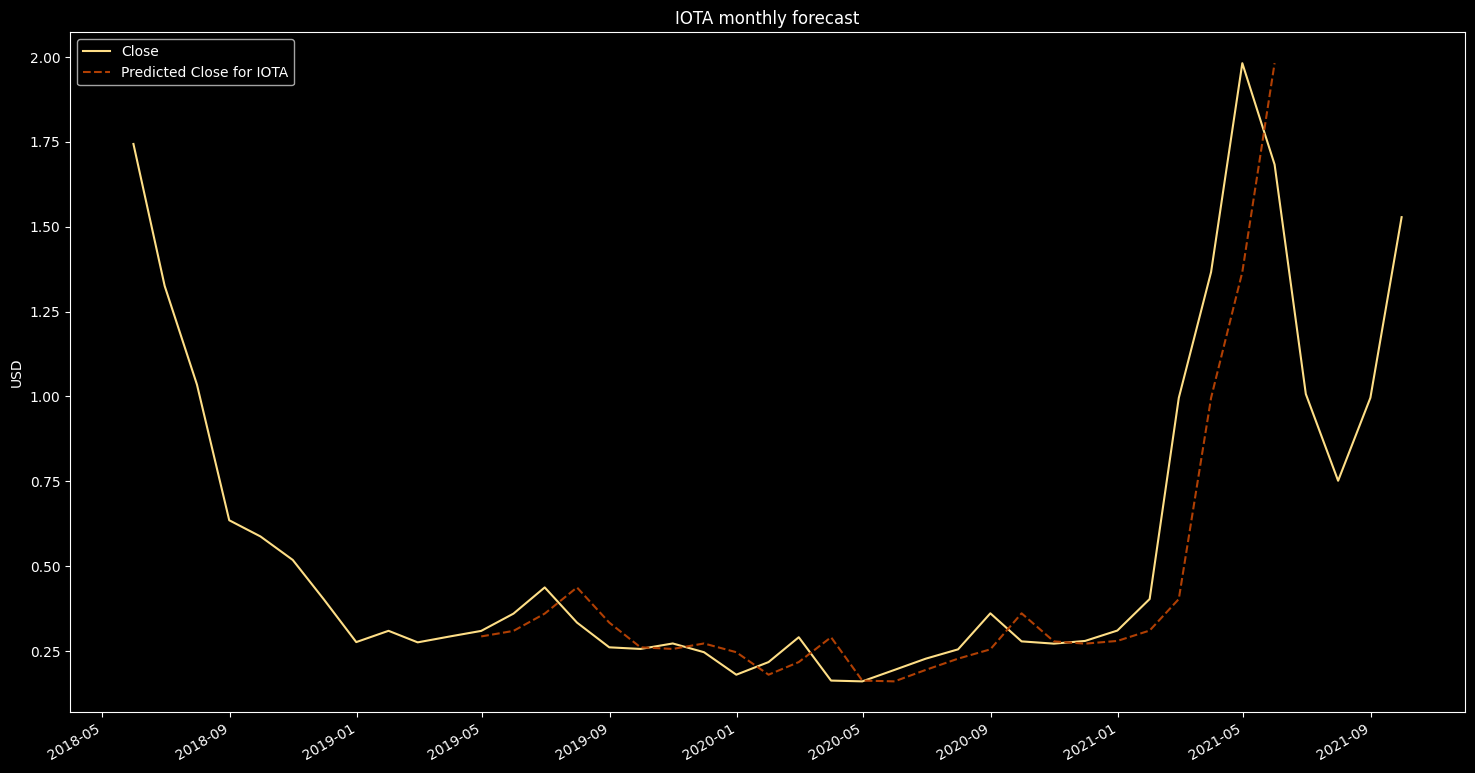

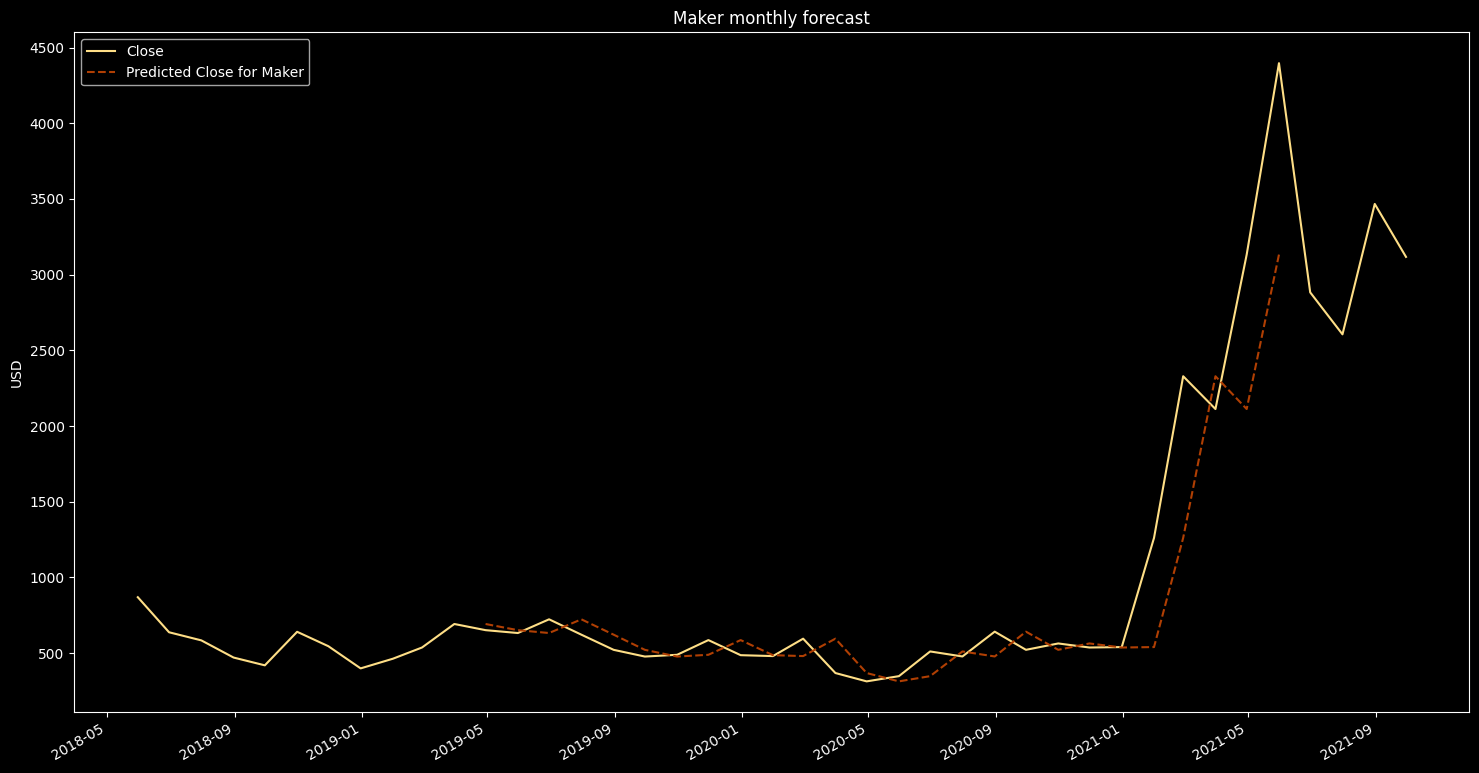

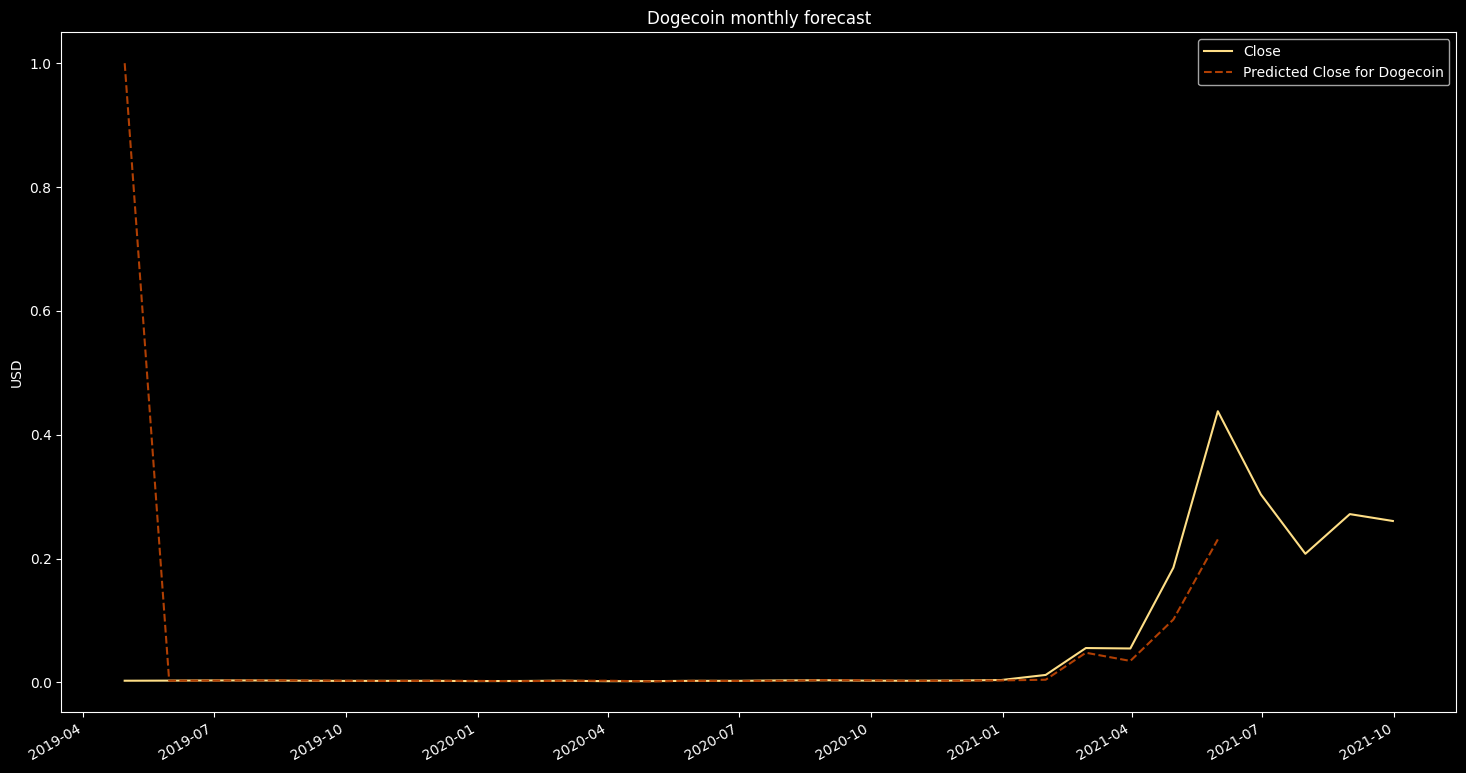

In [47]:
## Loop through each cryptocurrency in the crypto_data_mini dictionary
for asset_id, crypto_data in crypto_data_mini.items():
    # Apply Box-Cox transformation to the "Close" column
    crypto_month = crypto_data.resample("M").mean()
    crypto_month["close_box"], lmbda = stats.boxcox(crypto_month.Close)
    
    # Define parameters for SARIMAX (same as before)
    qs = range(0, 3)
    ps = range(0, 3)
    d = 1
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    
    # Model Selection
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        try:
            model = SARIMAX(crypto_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print(f"bad parameter combination: {param}")
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    # Get predictions for the future dates
    date_list = [datetime(2021, 6, 20), datetime(2021, 7, 20), datetime(2021, 8, 21), datetime(2021, 9, 21)]
    future = pd.DataFrame(index=date_list, columns=crypto_month.columns)
    crypto_month_pred = pd.concat([crypto_month[['Close']], future])
    crypto_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2019, 4, 30), end=datetime(2021, 5, 31)), lmbda)
    
    # Plot the results
    plt.figure(figsize=(18, 10))
    crypto_month_pred.Close.plot(color='#fede86')
    crypto_month_pred.forecast.plot(color='#b03f03', ls='--', label=f'Predicted Close for {crypto_labels[asset_id]}')
    plt.legend()
    plt.title(f'{crypto_labels[asset_id]} monthly forecast')
    plt.ylabel('USD')
    plt.show()


Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Bitcoin Cash:
MAE: 164.0584
MSE: 132278.8143
RMSE: 363.7015
R²: 0.0699
--------------------------------------------------


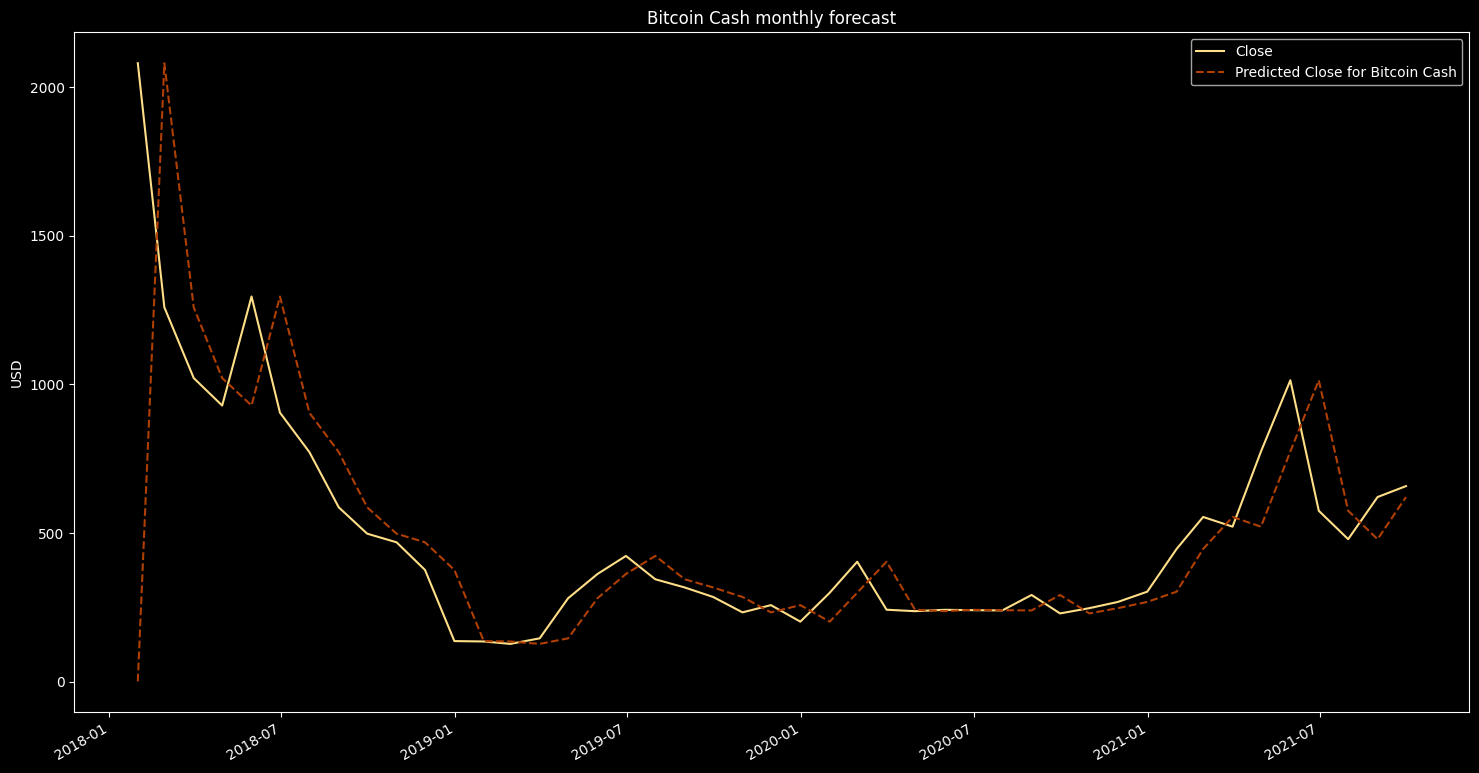

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Binance Coin:
MAE: 29.5414
MSE: 6739.2139
RMSE: 82.0927
R²: 0.6543
--------------------------------------------------


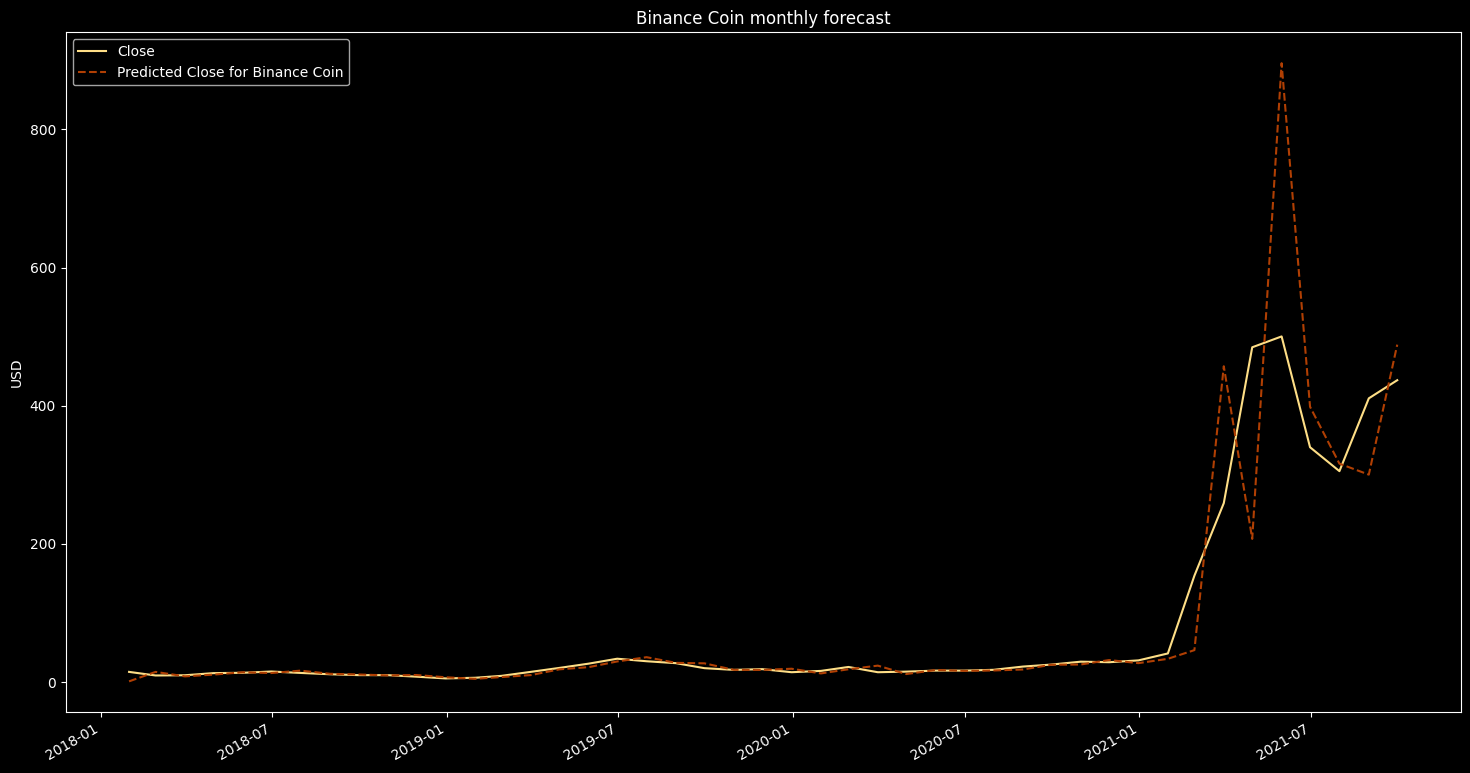

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Bitcoin:
MAE: 2416.6895
MSE: 15941451.5568
RMSE: 3992.6747
R²: 0.9308
--------------------------------------------------


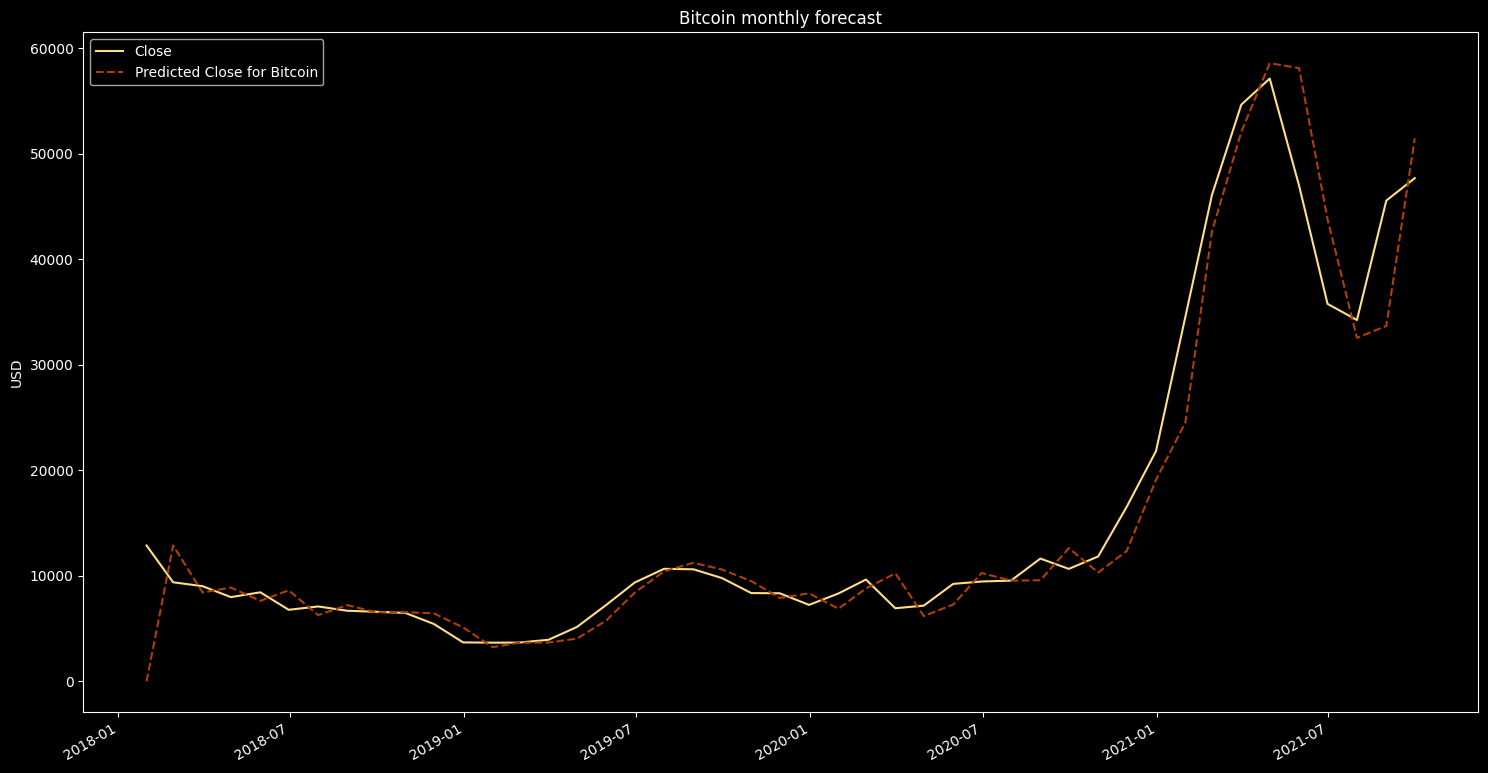

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for EOS.IO:
MAE: 1.3653
MSE: 5.1821
RMSE: 2.2764
R²: 0.3012
--------------------------------------------------


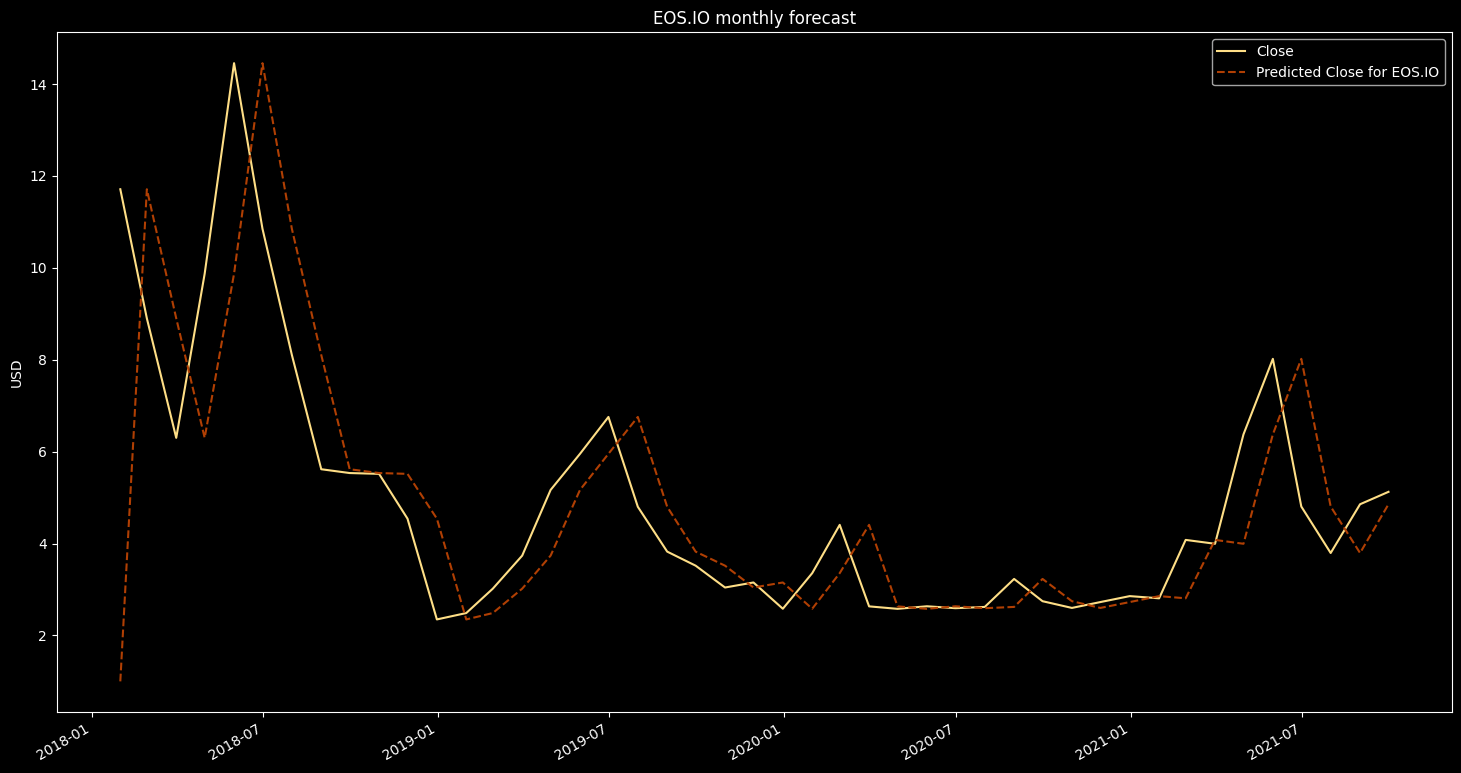

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Ethereum Classic:
MAE: 4.7725
MSE: 122.3416
RMSE: 11.0608
R²: 0.6159
--------------------------------------------------


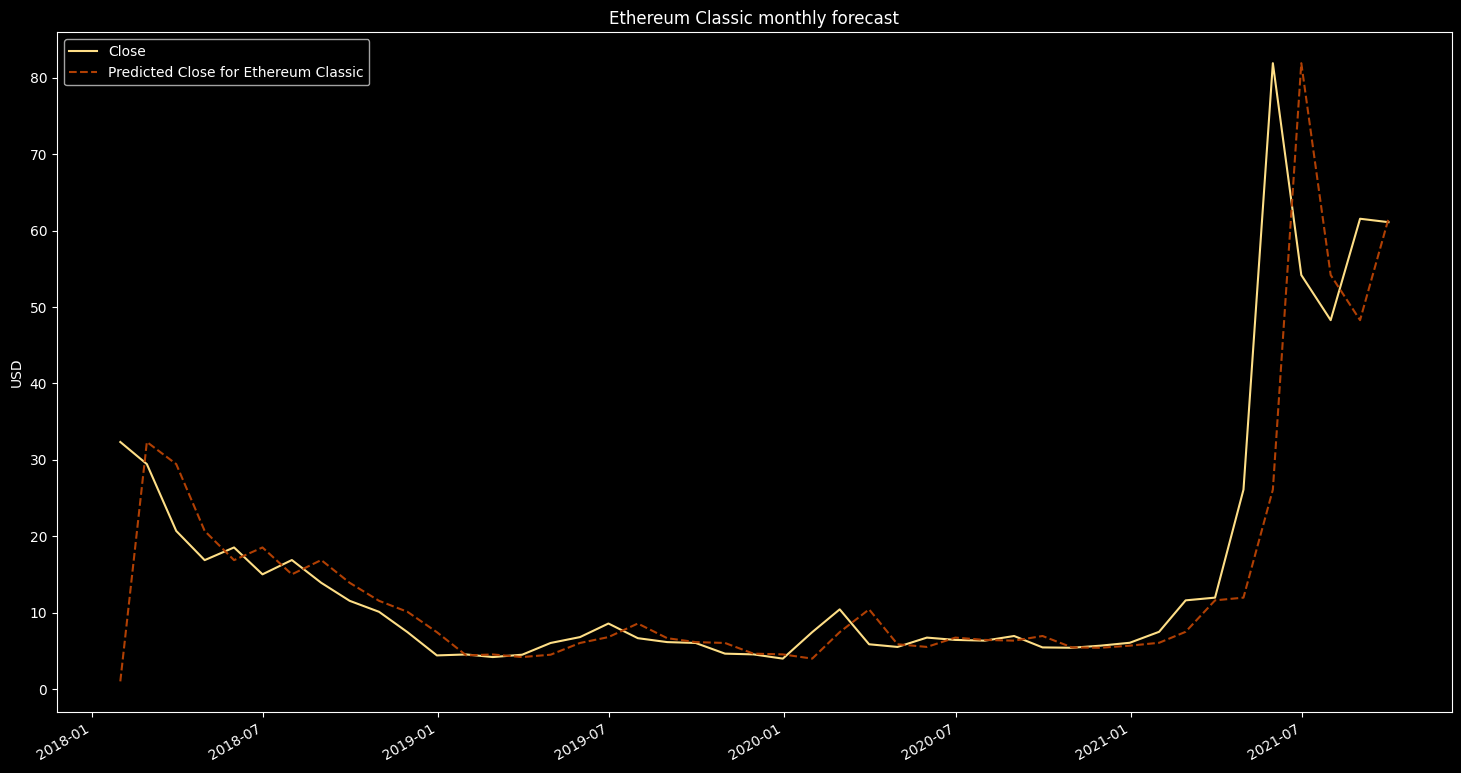

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Ethereum:
MAE: 185.4522
MSE: 109582.7121
RMSE: 331.0328
R²: 0.8630
--------------------------------------------------


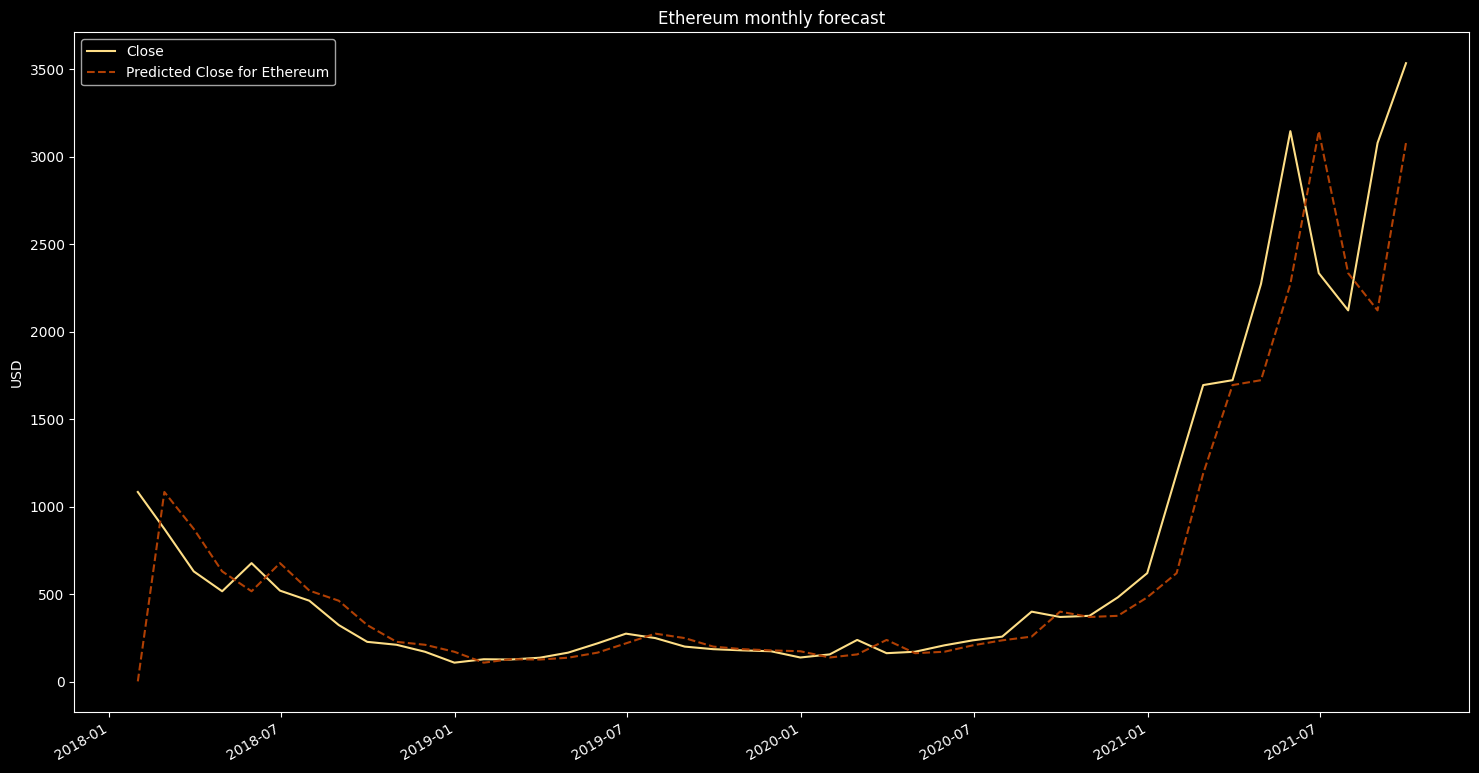

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Litecoin:
MAE: 21.7120
MSE: 1658.5254
RMSE: 40.7250
R²: 0.5612
--------------------------------------------------


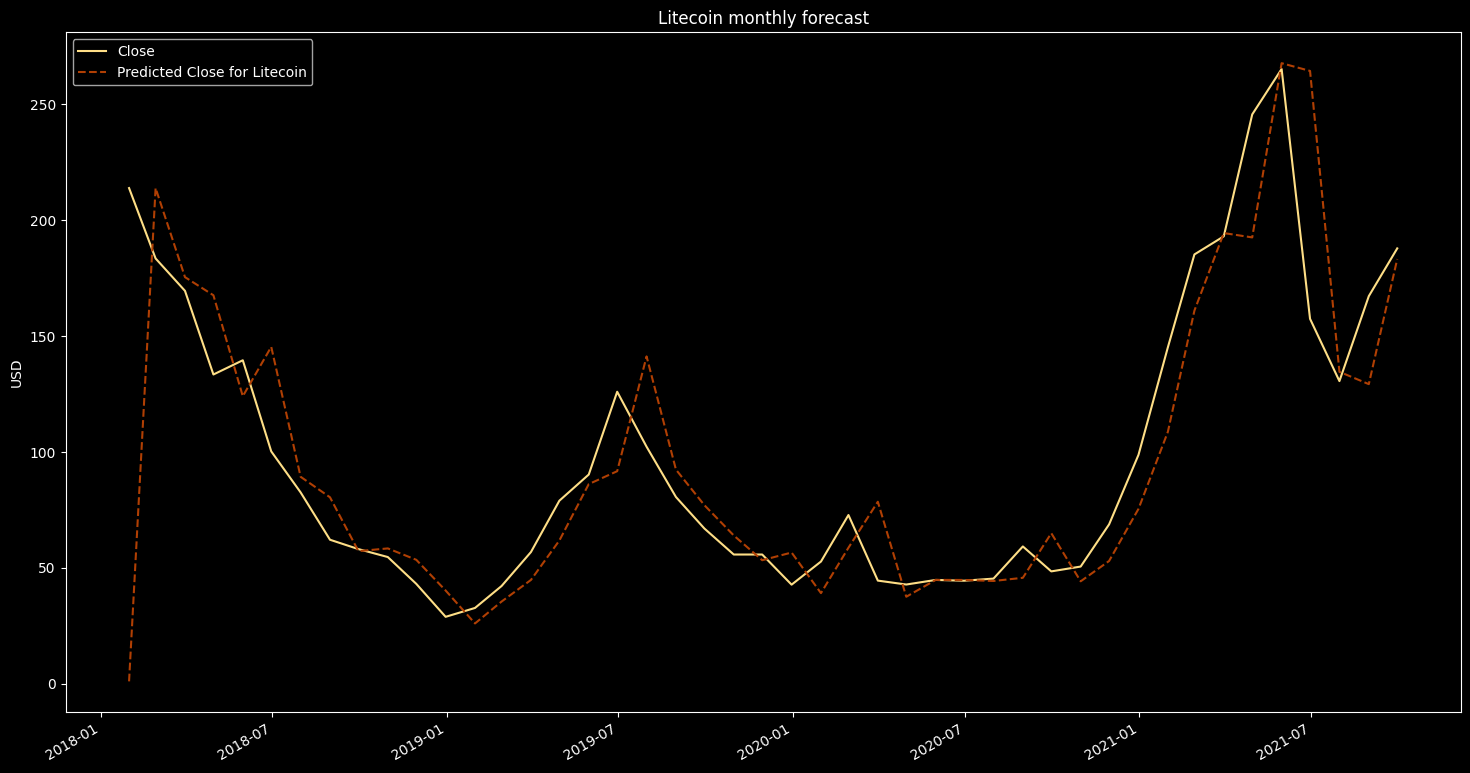

Start date: 2018-01-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Monero:
MAE: 30.2004
MSE: 3896.3474
RMSE: 62.4207
R²: 0.5019
--------------------------------------------------


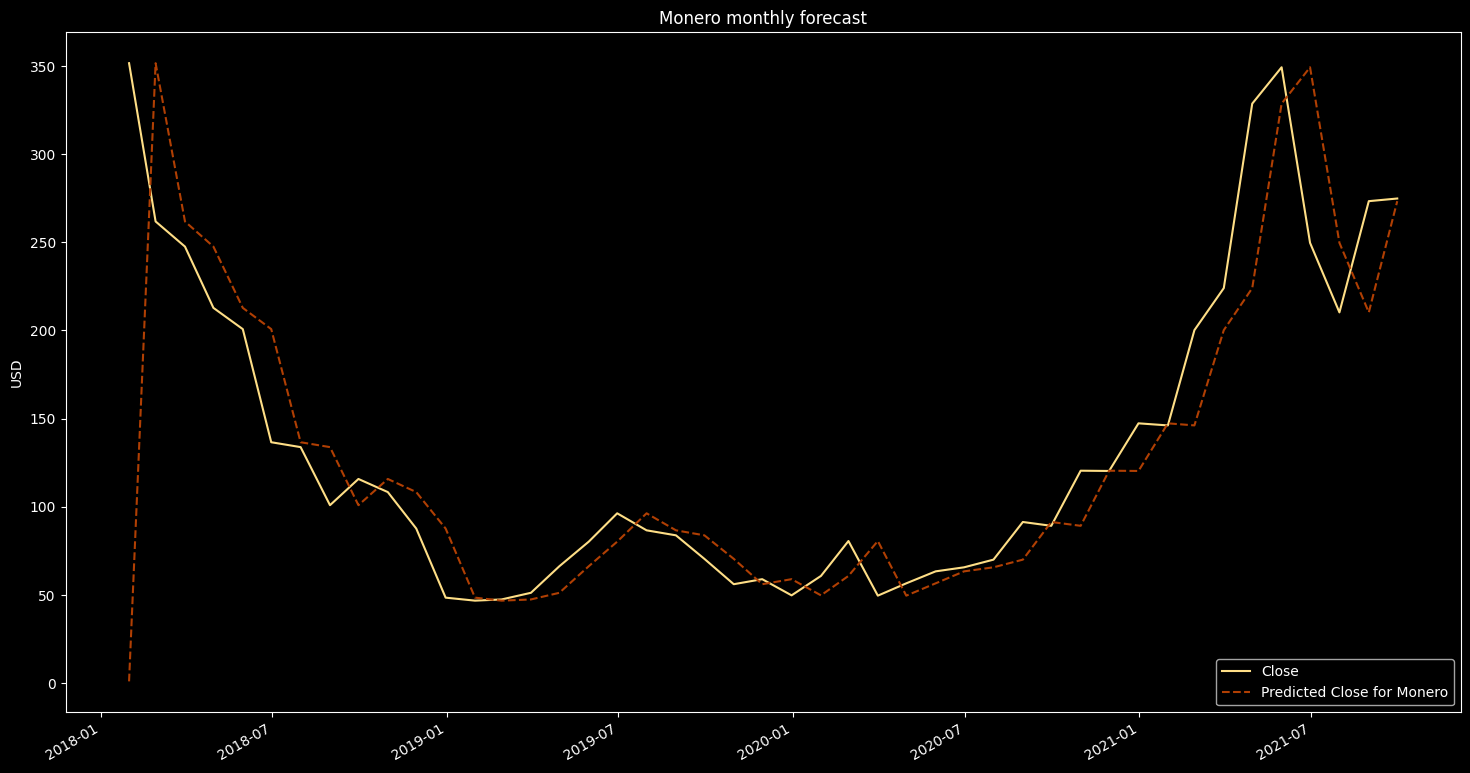

Start date: 2018-02-28 00:00:00
End date: 2021-09-30 00:00:00
Metrics for TRON:
MAE: 0.0305
MSE: 0.0210
RMSE: 0.1449
R²: -29.2056
--------------------------------------------------


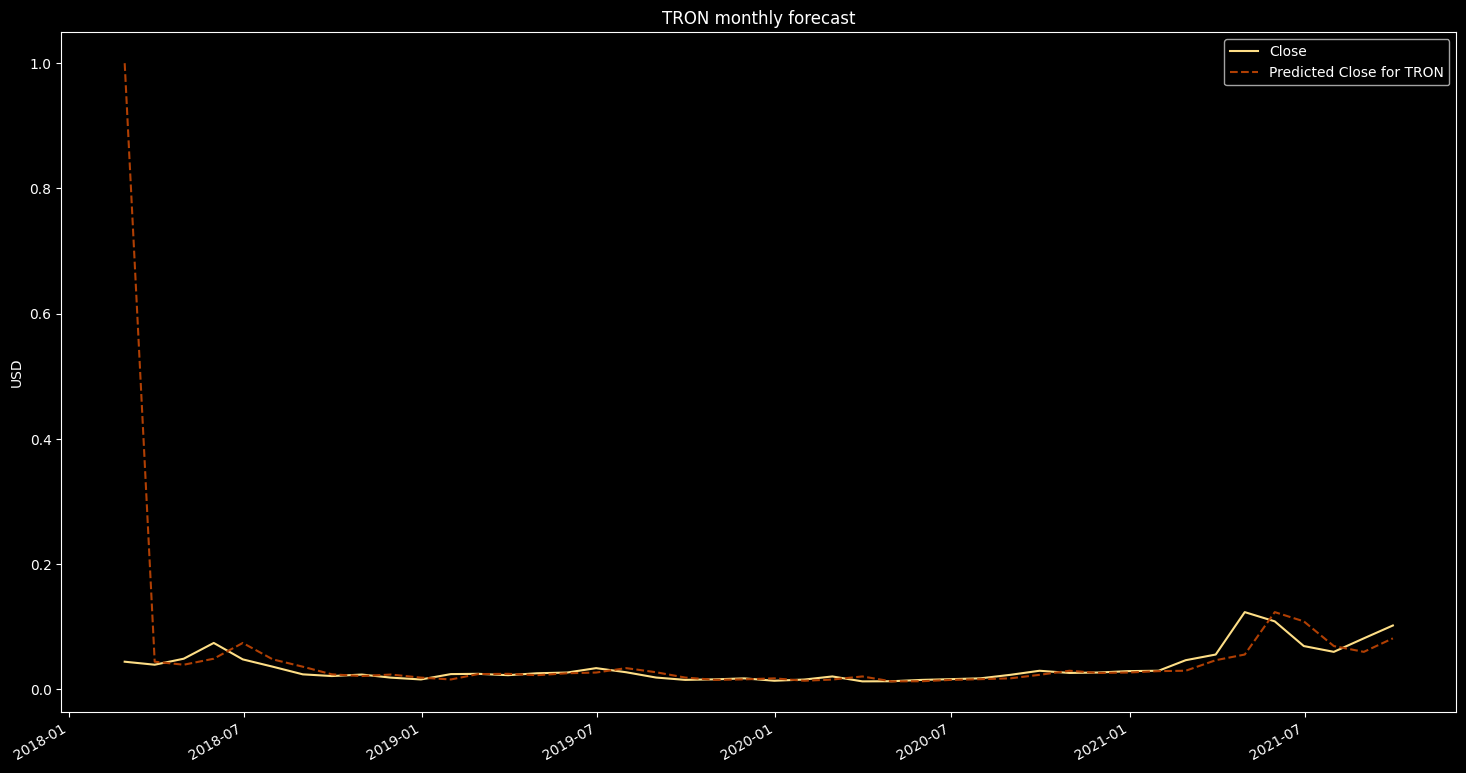

Start date: 2018-02-28 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Stellar:
MAE: 0.0517
MSE: 0.0122
RMSE: 0.1102
R²: 0.3113
--------------------------------------------------


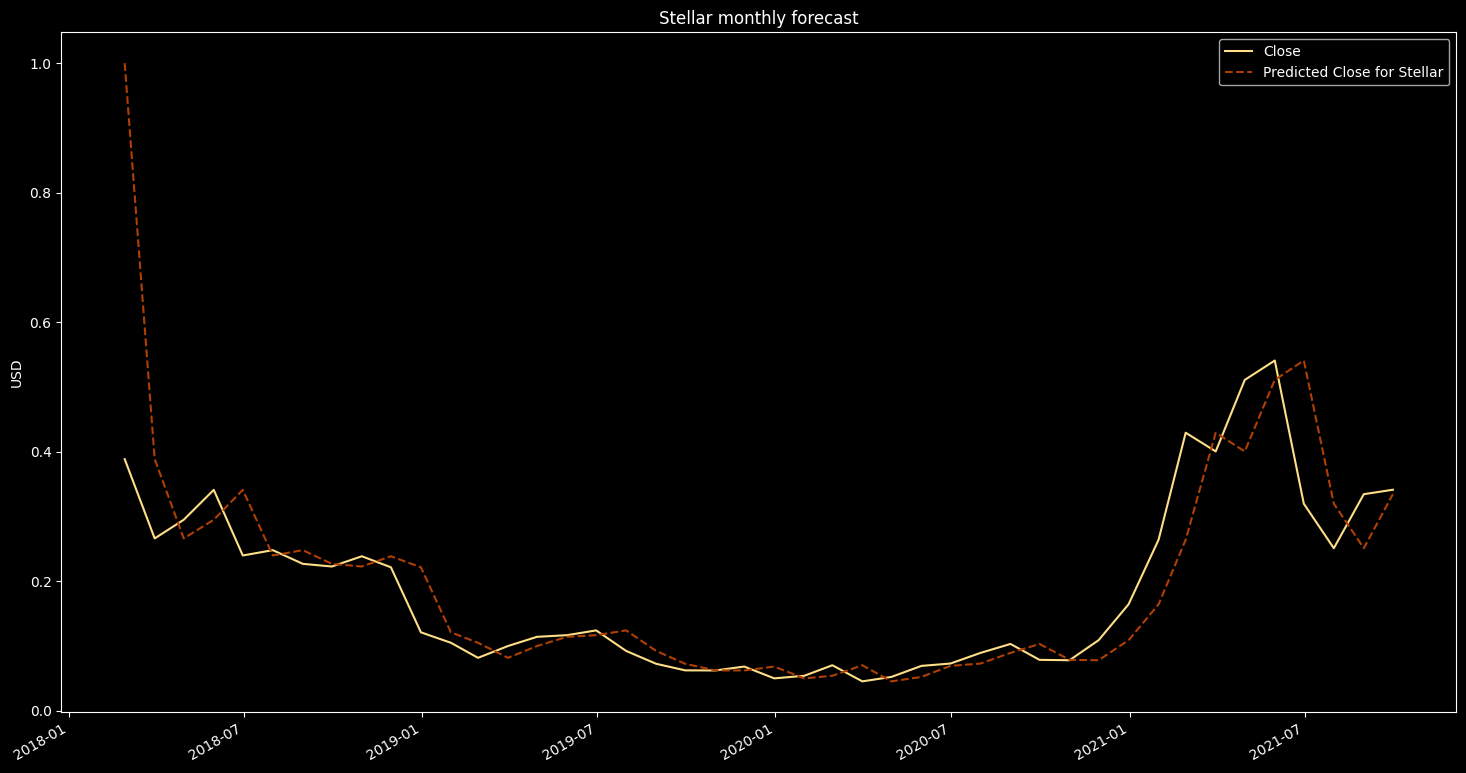

Start date: 2018-04-30 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Cardano:
MAE: 0.0905
MSE: 0.0414
RMSE: 0.2034
R²: 0.8909
--------------------------------------------------


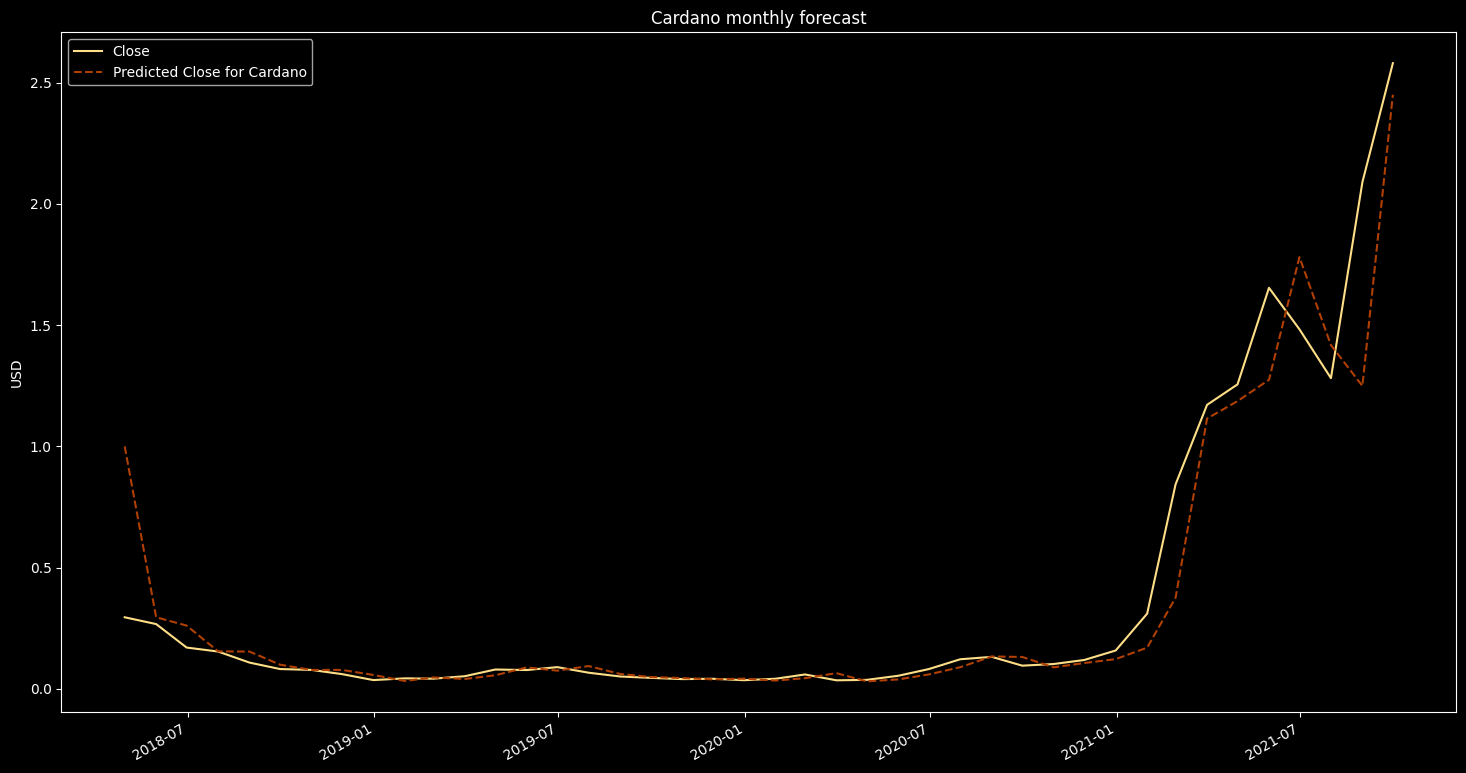

Start date: 2018-05-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for IOTA:
MAE: 0.1702
MSE: 0.0712
RMSE: 0.2668
R²: 0.7054
--------------------------------------------------


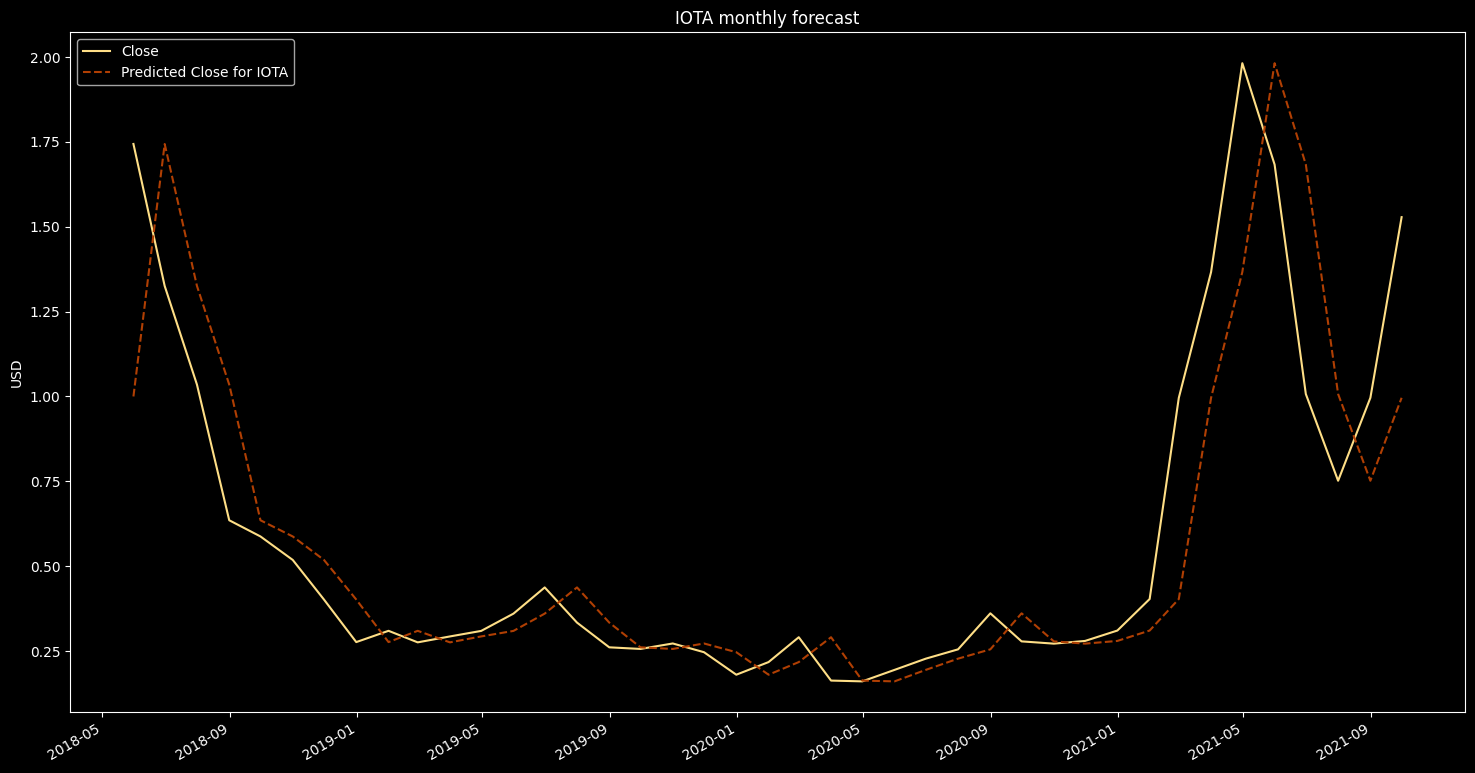

Start date: 2018-05-31 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Maker:
MAE: 267.3623
MSE: 212494.2312
RMSE: 460.9710
R²: 0.7970
--------------------------------------------------


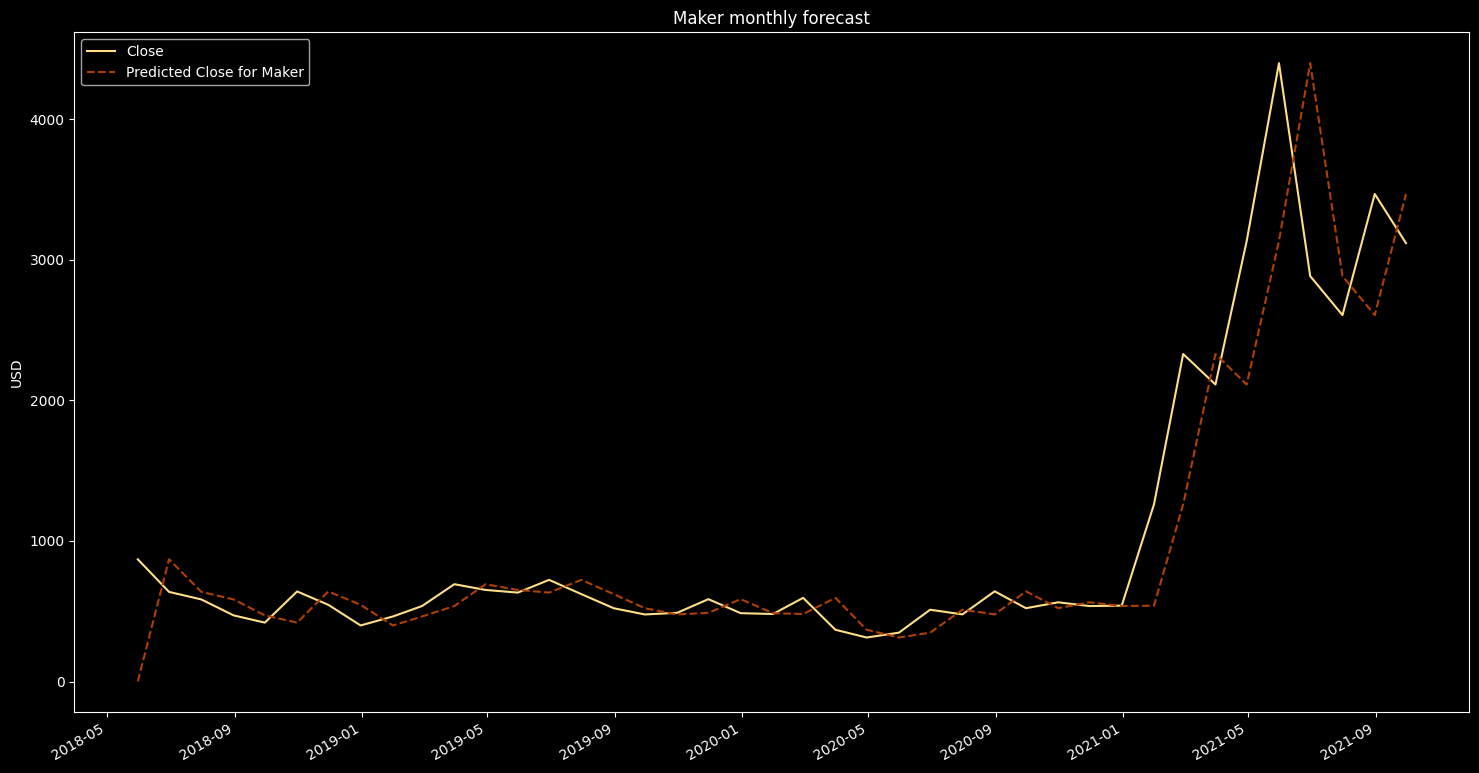

Start date: 2019-04-30 00:00:00
End date: 2021-09-30 00:00:00
Metrics for Dogecoin:
MAE: 0.0602
MSE: 0.0413
RMSE: 0.2031
R²: -2.1255
--------------------------------------------------


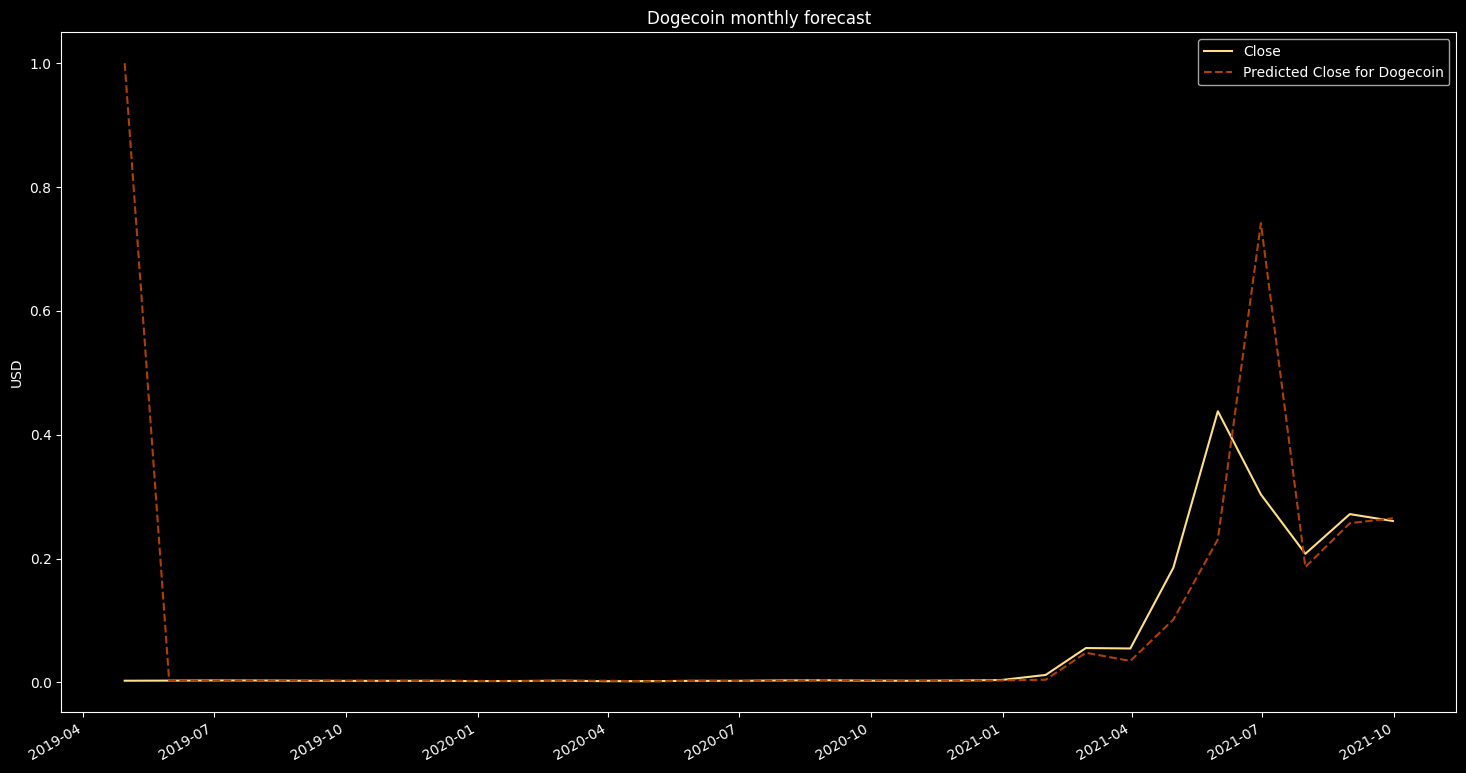

In [78]:
from sklearn.metrics import r2_score

## Loop through each cryptocurrency in the crypto_data_mini dictionary
for asset_id, crypto_data in crypto_data_mini.items():
    # Apply Box-Cox transformation to the "Close" column
    crypto_month = crypto_data.resample("M").mean()
    crypto_month["close_box"], lmbda = stats.boxcox(crypto_month.Close)
    
    # Define parameters for SARIMAX (same as before)
    qs = range(0, 3)
    ps = range(0, 3)
    d = 1
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    
    # Model Selection
    results = []
    best_aic = float("inf")
    for param in parameters_list:
        try:
            model = SARIMAX(crypto_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print(f"bad parameter combination: {param}")
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    # Define the start and end dates
    start_date = crypto_data.index.min()
    end_date = crypto_data.index.max()

    # Find the closest valid date if not found in the index
    if start_date not in crypto_month.index:
        # Calculate the absolute time difference between start_date and each index value
        time_diff = (crypto_month.index - start_date).to_numpy().astype('timedelta64[s]')
        start_date_loc = abs(time_diff).argmin()  # Find the index of the minimum difference
        start_date = crypto_month.index[start_date_loc]
        print(f"Start date: {start_date}")
    
    if end_date not in crypto_month.index:
        # Calculate the absolute time difference between end_date and each index value
        time_diff = (crypto_month.index - end_date).to_numpy().astype('timedelta64[s]')
        end_date_loc = abs(time_diff).argmin()  # Find the index of the minimum difference
        end_date = crypto_month.index[end_date_loc]
        print(f"End date: {end_date}")
    
    # Get predictions for the future dates
    date_list = [datetime(2021, 6, 20), datetime(2021, 7, 20), datetime(2021, 8, 21), datetime(2021, 9, 21)]
    future = pd.DataFrame(index=date_list, columns=crypto_month.columns)
    crypto_month_pred = pd.concat([crypto_month[['Close']], future])
    crypto_month_pred['forecast'] = invboxcox(best_model.predict(start=start_date, end=end_date), lmbda)

    # Now use these dates for prediction
    forecasted_values = best_model.predict(start=start_date, end=end_date)
    
    # Inverse Box-Cox for predictions
    forecasted_values = best_model.predict(start=start_date, end=end_date)
    crypto_month_pred['forecast'] = invboxcox(forecasted_values, lmbda)
    
    # Compute metrics (we need the actual close values for comparison)
    actual_values = crypto_month_pred['Close'].loc[start_date:end_date]
    predicted_values = crypto_month_pred['forecast'].loc[start_date:end_date]
    
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = sqrt(mse)
    r2 = r2_score(actual_values, predicted_values)

    print(f"Metrics for {crypto_labels[asset_id]}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)
    
    # Plot the results
    plt.figure(figsize=(18, 10))
    crypto_month_pred.Close.plot(color='#fede86')
    crypto_month_pred.forecast.plot(color='#b03f03', ls='--', label=f'Predicted Close for {crypto_labels[asset_id]}')
    plt.legend()
    plt.title(f'{crypto_labels[asset_id]} monthly forecast')
    plt.ylabel('USD')
    plt.show()

In [1]:
# Now use these dates for prediction
    forecasted_values = best_model.predict(start=start_date, end=end_date)
    
    # Inverse Box-Cox for predictions
    forecasted_values = best_model.predict(start=start_date, end=end_date)
    crypto_month_pred['forecast'] = invboxcox(forecasted_values, lmbda)
    
    # Compute metrics (we need the actual close values for comparison)
    actual_values = crypto_month_pred['Close'][-len(forecasted_values):]
    predicted_values = crypto_month_pred['forecast'][-len(forecasted_values):]
    
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = sqrt(mse)
    
    print(f"Metrics for {crypto_labels[asset_id]}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print("-" * 50)

IndentationError: unexpected indent (202907352.py, line 2)